In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from matplotlib.lines import Line2D

import seaborn as sns
import warnings
import os

import math
from math import ceil

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support as scorer

from apyori import apriori

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('./data_labels_mainData.csv')

In [3]:
data

InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0          22405          1  22405.png   fibroblast         0            0
1          22406          1  22406.png   fibroblast         0            0
2          22407          1  22407.png   fibroblast         0            0
3          22408          1  22408.png   fibroblast         0            0
4          22409          1  22409.png   fibroblast         0            0
...          ...        ...        ...          ...       ...          ...
9891        1625         60   1625.png   epithelial         2            1
9892        1626         60   1626.png   epithelial         2            1
9893        1627         60   1627.png   epithelial         2            1
9894        1628         60   1628.png   epithelial         2            1
9895        1629         60   1629.png   epithelial         2            1

[9896 rows x 6 columns]

In [4]:
data.shape

(9896, 6)

# Exploratory Data Analysis

## Strategy
 - Look at the basic information of the dataframe, and check for missing values
 - Checking the value counts of each column to understand the distribution of cancerous and cell types
 - Understanding the correlation between the columns
 - Assessing the class balance for cancerous cell identification and cell type classification
 - Checking which patients have cancer, and analyzing the number cancerous cell images by each patient
 - Checking which cell types are cancerous, and analyzing the number of cancerous cell images by cell types
 - Putting it all together and visualizing the breakdown of each patient's different cell types and whether or not they're cancerous
 - Rule Learning to understand the correlation and association between cancerous cells and cell types
 - Image analysis to understand what constitues a cancerous cell visually

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


<span style="font-size:1em;">✔</span> **Observations:**

- There are no missing values in the dataset, so we don't have to do anything to deal with it

## Checking the value counts of each column

In [10]:
for column in data.columns:
    print(column + ": " + str(data[column].unique()))
    print(data[column].value_counts())
    print()

InstanceID: [22405 22406 22407 ...  1627  1628  1629]
18431    1
1466     1
19907    1
1474     1
11892    1
        ..
4783     1
16489    1
17069    1
17032    1
21085    1
Name: InstanceID, Length: 9896, dtype: int64

patientID: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
54    389
29    355
9     348
8     332
20    325
18    320
17    310
10    302
51    286
55    263
23    254
7     253
41    250
21    224
40    209
14    207
6     198
50    195
24    192
49    187
25    180
13    180
52    178
5     169
33    163
58    161
19    158
26    157
22    152
57    149
48    147
43    137
31    137
3     136
42    136
47    133
53    132
12    130
36    128
4     127
15    125
44    121
46    120
59    115
60    115
16    111
30    110
39    105
32     99
56     92
38     84
45     74
37     71
11     56
2      33
1      19
27     17
28     15
34  

<span style="font-size:1em;">✔</span> **Observations:**
 - There is an uneven balance of patient data, this needs to be explored further
 - There is an uneven balance of cell type data, this needs to be explored further
 - ~41% of the images have cancerous cells while ~59% are non-cancerous.  

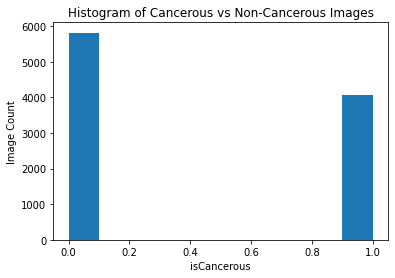

In [112]:
plt.hist(data['isCancerous'])
plt.xlabel("isCancerous")
plt.ylabel("Image Count")
plt.title("Histogram of Cancerous vs Non-Cancerous Images")
plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - As can be seen from the histogram, there is a slight imbalance between the two classes; a ratio of approximately 3:2 in number of instances between the negative and positive target classes.
 - It will be worth checking if the same is the case for the extra dataset

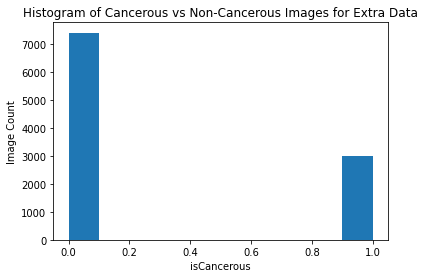

In [116]:
data_extra = pd.read_csv('./data_labels_extraData.csv')

plt.hist(data_extra['isCancerous'])
plt.xlabel("isCancerous")
plt.ylabel("Image Count")
plt.title("Histogram of Cancerous vs Non-Cancerous Images for Extra Data")
plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - The class imbalance in the extra dataset is more pronounced than was the case for the first dataset, indicating that there are less instances of cancerous cells in practice than we were originally led to believe.

## Understanding the correlation between columns

It is also possible to examine the relationship of the isCancerous variable with the cell type as we are given both for each entry in the first dataset. To determine the strength of the relationship between each cell type and likelihood of being cancer cells, the type of cells must be decomposed into binary variables.

In [189]:
data = pd.concat([data, pd.get_dummies(data['cellTypeName'])], axis=1)
data = data.drop(['cellTypeName'], axis=1)
data = data.drop(['cellType'], axis=1)

The correlations between whether a cell was cancerous and each cell type were as follows.

In [190]:
main_data.corr()['isCancerous']

InstanceID     -0.436191
patientID      -0.001213
isCancerous     1.000000
epithelial      1.000000
fibroblast     -0.406599
inflammatory   -0.492457
others         -0.337944
Name: isCancerous, dtype: float64

<span style="font-size:1em;">✔</span> **Observations:**
 - It can be observed that there is a negative correlation between all cell types and isCancerous, except for epithelial cells, of which all in the dataset were cancerous.

## Checking which patients have cancer

In [7]:
patients_with_cancer = data['patientID'][data['isCancerous']==1].unique()
print(patients_with_cancer)

[ 5  6  7  8  9 10 13 14 17 18 19 20 21 22 30 31 32 36 38 40 41 42 43 46
 47 48 49 50 51 52 53 54 55 60]


In [8]:
len(patients_with_cancer)

34

<span style="font-size:1em;">✔</span> **Observations:**
 - 34/60 patients have cancer, so there is an almost even balance of patients with cancer and patients without cancer in the dataset

## Analysis by each patient

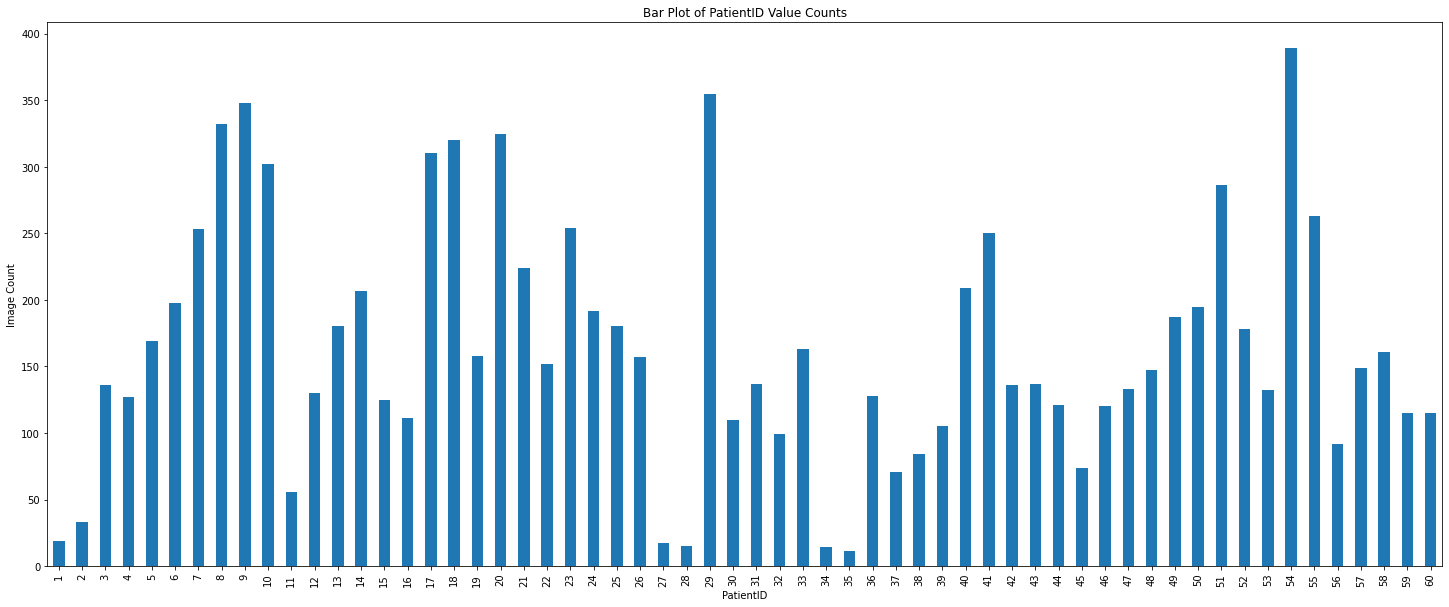

In [11]:
plt.figure(figsize=(25,10))
data.patientID.value_counts().sort_index(ascending=True).plot(kind = 'bar')
plt.xlabel("PatientID")
plt.ylabel("Image Count")
plt.title("Bar Plot of PatientID Value Counts")
plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - As observed already from the value counts, there is an uneven distribution of images across all the patients. 
 - It is worth exploring visually how many of these patients are cancerous

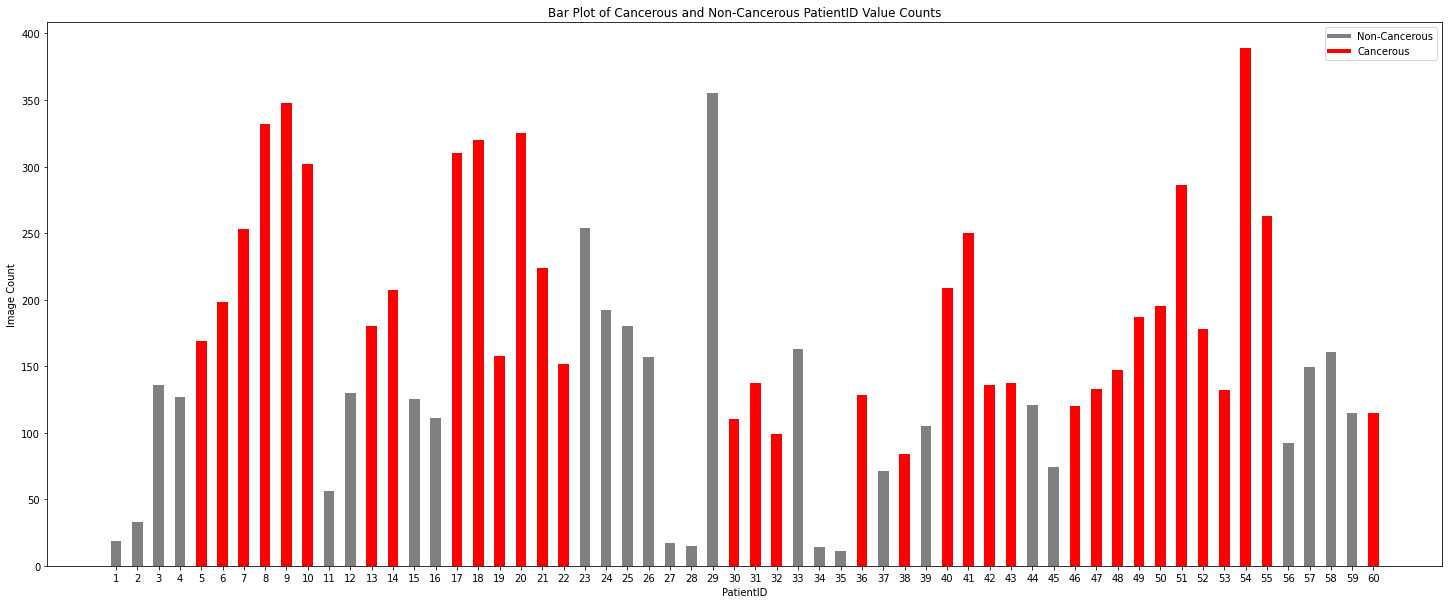

In [12]:
patientID_value_counts = list(data.patientID.value_counts().sort_index(ascending=True))
patientIDs = list(range(1,61))
colors = ['grey' for x in patientIDs]
for i in patients_with_cancer:
    #print(i)
    colors[i-1] = 'red'
    
plt.figure(figsize=(25,10))
plt.xticks(patientIDs)
plt.bar(patientIDs, patientID_value_counts, width=0.5, color= colors)
plt.xlabel("PatientID")
plt.ylabel("Image Count")
plt.title("Bar Plot of Cancerous and Non-Cancerous PatientID Value Counts")


cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='red', lw=4)]

plt.legend(custom_lines, ['Non-Cancerous', 'Cancerous'])

plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - This plot show the 34/60 patients with cancer, and it seems that they have a majority of the data
 - However, not all images for cancerous patients are canerous, so the figure above can be a little misleading
 - It is thus important to similarly see how many images of each cancer patient are cancerous

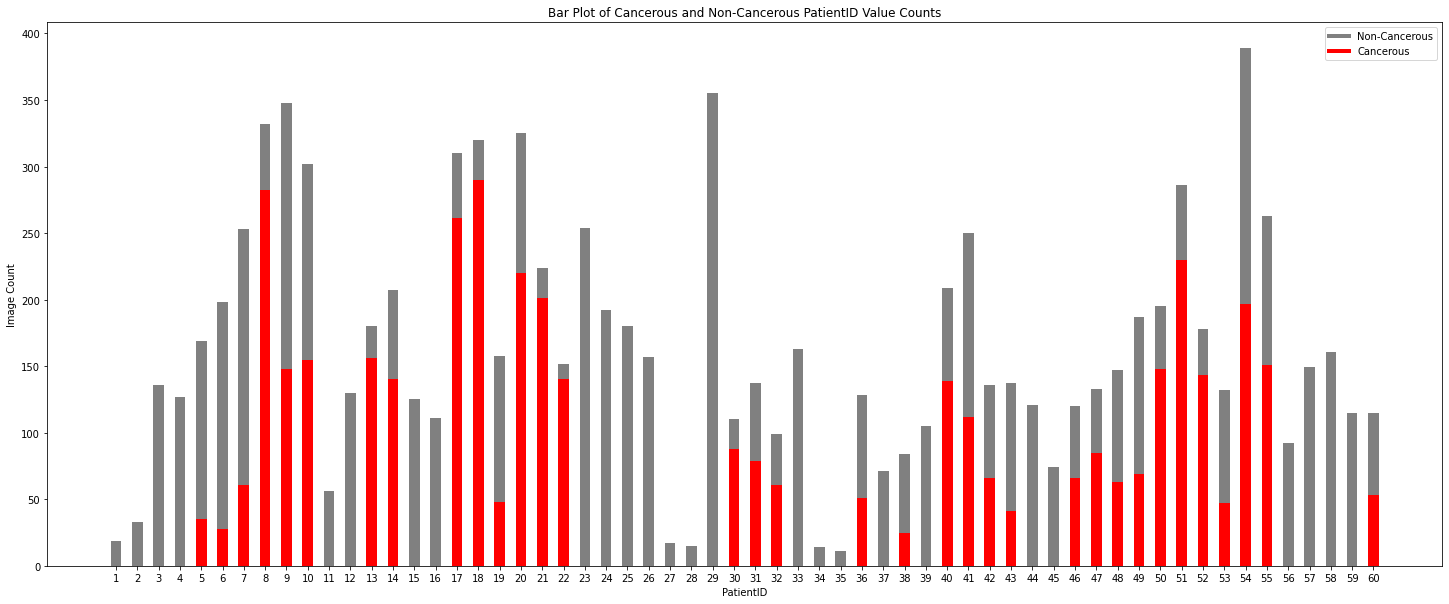

In [15]:
cancerous_value_counts = []
for patientID in patientIDs:
    cancerous_value_counts.append(len(data[data['patientID'] == patientID][data['isCancerous']==1]))
    
plt.figure(figsize=(25,10))
plt.xticks(patientIDs)
plt.bar(patientIDs, patientID_value_counts, width=0.5, color= 'grey')
plt.bar(patientIDs, cancerous_value_counts, width=0.5, color = colors)
plt.xlabel("PatientID")
plt.ylabel("Image Count")
plt.title("Bar Plot of Cancerous and Non-Cancerous PatientID Value Counts")


cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='red', lw=4)]

plt.legend(custom_lines, ['Non-Cancerous', 'Cancerous'])
plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - This figure above paints a more accurate reperesentation of not just the number of cancerous patients, but what proportion of the images related to each cancerous patient are cancerous
 - We can take this a step further by representing the percentages


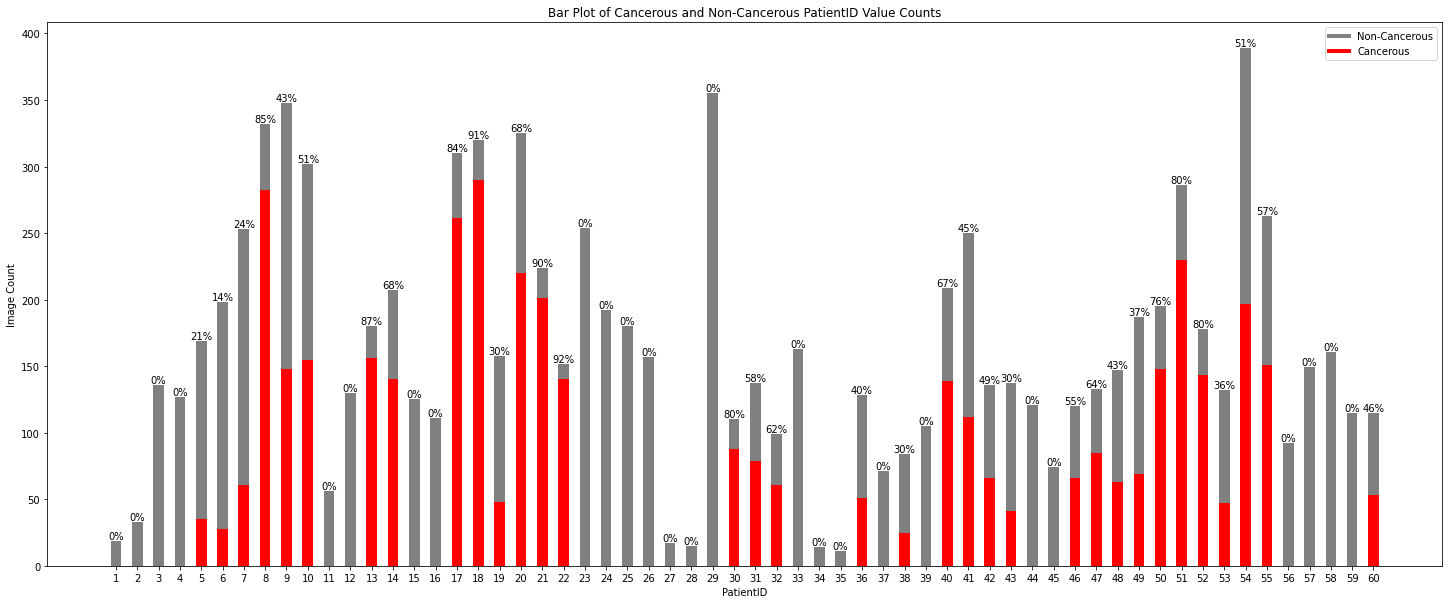

In [16]:
# What percentage, on average of cancerous patients images are actually cancerous?

ratio_cancerous = []
for patientID in patientIDs:
    ratio_cancerous.append(str( round( len(data[data['patientID'] == patientID][data['isCancerous']==1]) / len(data[data['patientID'] == patientID]) * 100 )) + "%")
    
plt.figure(figsize=(25,10))
plt.xticks(patientIDs)
plt.bar(patientIDs, patientID_value_counts, width=0.5, color= 'grey')
plt.bar(patientIDs, cancerous_value_counts, width=0.5, color = colors)
plt.xlabel("PatientID")
plt.ylabel("Image Count")
plt.title("Bar Plot of Cancerous and Non-Cancerous PatientID Value Counts")


cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='red', lw=4)]

plt.legend(custom_lines, ['Non-Cancerous', 'Cancerous'])

for i in range(len(ratio_cancerous)):
    plt.annotate(str(ratio_cancerous[i]), xy=(patientIDs[i],patientID_value_counts[i]), ha='center', va='bottom')
plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - This figure helps us visualize just what exactly percentage of each canerous patient's images are cancerous
 - It would also be worth further exploring what the value is on average

In [17]:
ratio_sum = 0
for patientID in patients_with_cancer:
    ratio_sum +=  ( len(data[data['patientID'] == patientID][data['isCancerous']==1]) / len(data[data['patientID'] == patientID]) * 100 )
    
ratio_average = ratio_sum / len(patients_with_cancer)

print("Average percentage of cancerous cell images in patients with cancer =  " + str(round(ratio_average,1)))

Average percentage of cancerous cell images in patients with cancer =  56.8


<span style="font-size:1em;">✔</span> **Observations:**
 - This tell us that on average, a 56.8% of cancerous patients' images are cancerous
 - Now we can explore the same for cell types

## Analysis by Cell Type

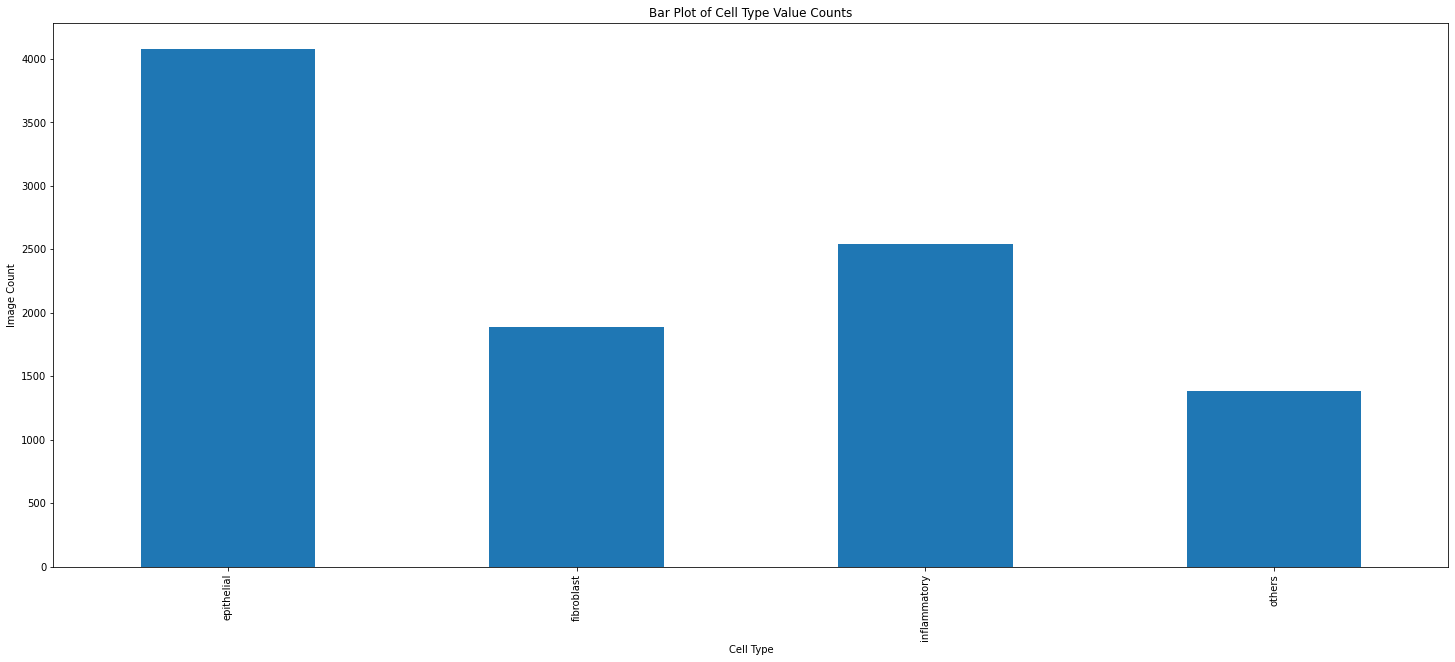

In [18]:
plt.figure(figsize=(25,10))
data.cellTypeName.value_counts().sort_index(ascending=True).plot(kind = 'bar')
plt.xlabel("Cell Type")
plt.ylabel("Image Count")
plt.title("Bar Plot of Cell Type Value Counts")
plt.show()

In [19]:
cellTypes_with_cancer = data['cellTypeName'][data['isCancerous']==1].unique()
cellType_value_counts = data.cellTypeName.value_counts()
cellTypes = list(data['cellTypeName'].unique())
colors = ['grey' for x in cellTypes]

# Checking the order of occurrence of each cell type and its value count
print(cellType_value_counts)

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64


<span style="font-size:1em;">✔</span> **Observations:**
 - Epithelial cells have the most number of images, followed by inflammatory, then fibroblast and then finally others with the least
 - Epithelial cells have more than 2x as many images as fibroblast and others
 - There is a class imbalance in cell type representation - this can affect the output of the classification model
 - As with the PatientIDs, it would be interesting to see how many of each cell type is cancerous


In [20]:
# Now we can put it into a list
cellType_value_counts = list(cellType_value_counts)

# Putting the cell types into the right order
cellTypes = ['epithelial', 'inflammatory', 'fibroblast', 'others']

print(cellTypes_with_cancer)

['epithelial']


<span style="font-size:1em;">✔</span> **Observations:**
 - It seems that epithelial cells are the only cell type that are cancerous

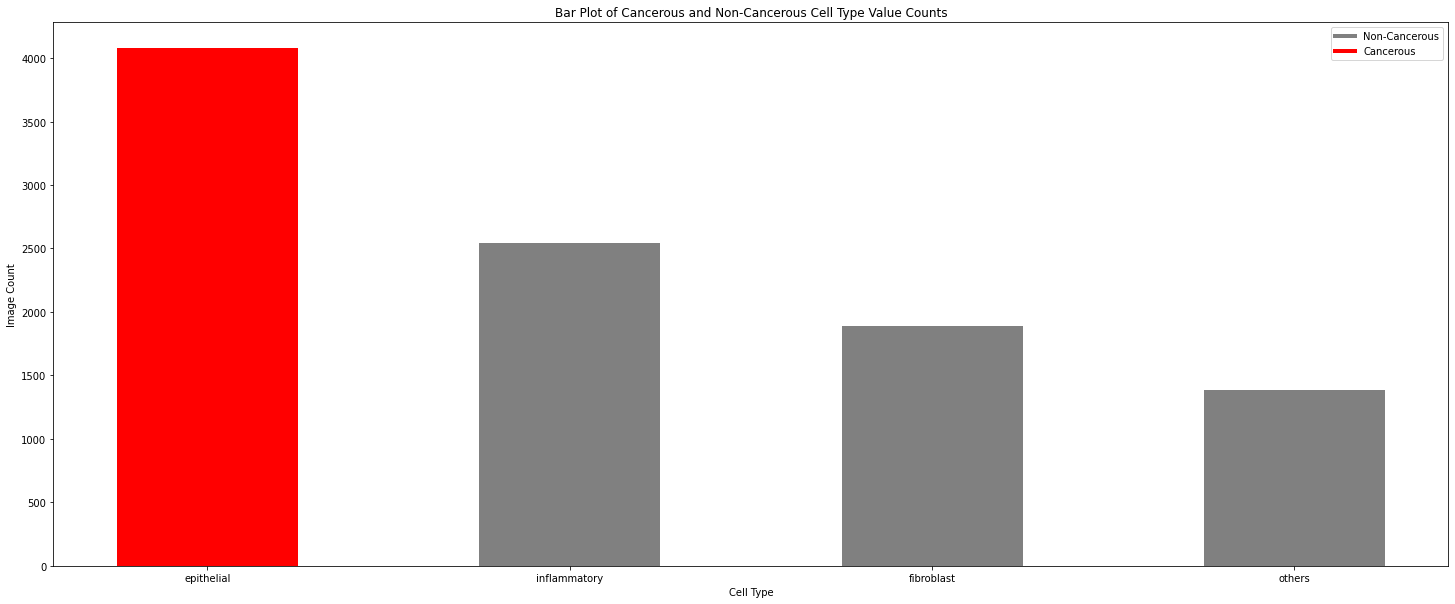

In [21]:
colors[0] = 'red'
plt.figure(figsize=(25,10))
plt.bar(cellTypes, cellType_value_counts, width=0.5, color= colors)
plt.xlabel("Cell Type")
plt.ylabel("Image Count")
plt.title("Bar Plot of Cancerous and Non-Cancerous Cell Type Value Counts")
custom_lines = [Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='red', lw=4)]

plt.legend(custom_lines, ['Non-Cancerous', 'Cancerous'])
plt.show()


<span style="font-size:1em;">✔</span> **Observations:**
 - As revealed by the data already, epithelial cells are the only ones that are cancerous. 
 - Not all images for epithelial cells may necessarily be cancerous though, so just as we did for the patientIDs, we should check what portion of epithelial cells are cancerous.

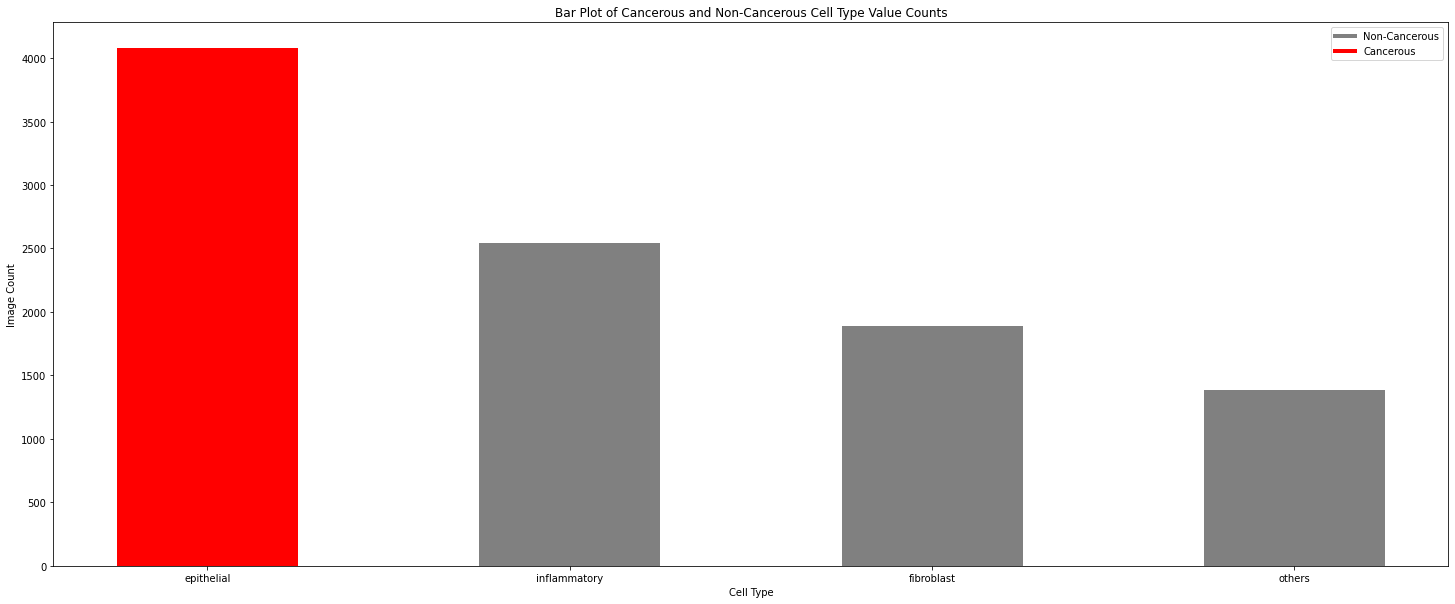

In [22]:
cancerous_value_counts = []
for cellType in cellTypes:
    cancerous_value_counts.append(len(data[data['cellTypeName'] == cellType][data['isCancerous']==1]))

    
plt.figure(figsize=(25,10))

plt.bar(cellTypes, cellType_value_counts, width=0.5, color= 'grey')
plt.bar(cellTypes, cancerous_value_counts, width=0.5, color = colors)
plt.xlabel("Cell Type")
plt.ylabel("Image Count")
plt.title("Bar Plot of Cancerous and Non-Cancerous Cell Type Value Counts")
custom_lines = [Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='red', lw=4)]

plt.legend(custom_lines, ['Non-Cancerous', 'Cancerous'])
plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - All epithelial cells are cancerous, which means that if a patient has an epithelial cell, they have cancer (at least in the context of this dataset) 
 - This also means that all cancerous cells are epithelial in this dataset
 - The previous graph of patientIDs and their corresponding percentage of cancerous images represent epithelial cells in red. It is thus worth exploring what the remaining grey part comprises of in terms of other cell types

In [23]:
for cellType in cellTypes: 
    
    num_patients = len(data['patientID'][data['cellTypeName'] == cellType].unique())
    print(cellType + ": " + str(num_patients))

epithelial: 34
inflammatory: 60
fibroblast: 53
others: 56


<span style="font-size:1em;">✔</span> **Observations:**
 - All patients have inflammatory cells in this dataset

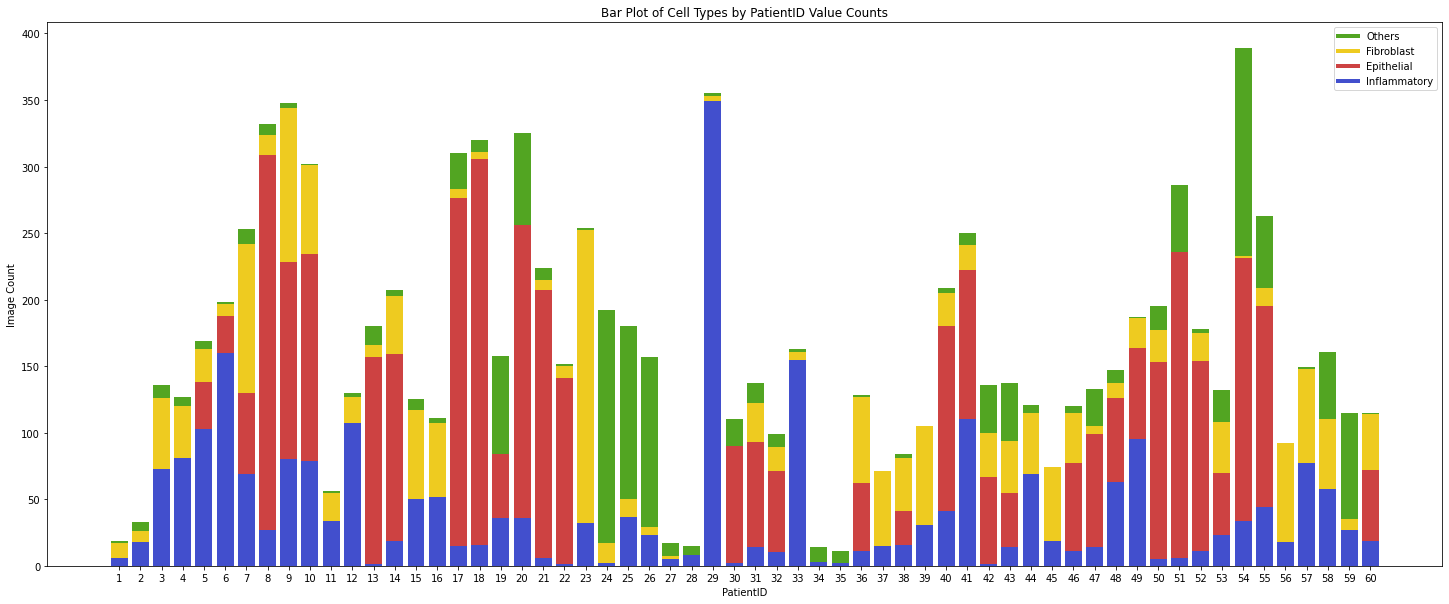

In [24]:
cancerous_value_counts = []
for patientID in patientIDs:
    cancerous_value_counts.append(len(data[data['patientID'] == patientID][data['isCancerous']==1]))
    
colors = ['grey' for x in patientIDs]
for i in patients_with_cancer:
    #print(i)
    colors[i-1] = 'red'

inflammatory_value_counts = []
for patientID in patientIDs:
    inflammatory_value_counts.append(len(data[data['patientID'] == patientID][data['cellTypeName'] == 'inflammatory']))
    
patients_with_inflammatory_cells = data['patientID'][data['cellTypeName'] == 'inflammatory'].unique()
#print(patients_with_inflammatory_cells)

colors = ['grey' for x in patientIDs]
for i in patients_with_inflammatory_cells:
    #print(i)
    colors[i-1] = 'blue'

for i in range(len(cancerous_value_counts)):
    if cancerous_value_counts[i] != 0:
        cancerous_value_counts[i] += inflammatory_value_counts[i]
        
fibroblast_value_counts = []
for patientID in patientIDs:
    fibroblast_value_counts.append(len(data[data['patientID'] == patientID][data['cellTypeName'] == 'fibroblast']))
    
patients_with_fibroblast_cells = data['patientID'][data['cellTypeName'] == 'fibroblast'].unique()
#print(patients_with_fibroblast_cells)

colors = ['grey' for x in patientIDs]
for i in patients_with_fibroblast_cells:
    #print(i)
    colors[i-1] = 'yellow'
    
for i in range(len(fibroblast_value_counts)):
    if fibroblast_value_counts[i] != 0:
        
        if cancerous_value_counts[i] != 0:
            fibroblast_value_counts[i] += cancerous_value_counts[i]
        else:
            fibroblast_value_counts[i] += inflammatory_value_counts[i]

plt.figure(figsize=(25,10))
plt.xticks(patientIDs)
plt.bar(patientIDs, patientID_value_counts, width=0.8, color= (0.321, 0.647, 0.133))
plt.bar(patientIDs, fibroblast_value_counts, width=0.8, color = (0.933, 0.796, 0.125))
plt.bar(patientIDs, cancerous_value_counts, width= 0.8, color = (0.803, 0.258, 0.258))
plt.bar(patientIDs, inflammatory_value_counts, width=0.8, color = (0.258, 0.309, 0.803))


plt.xlabel("PatientID")
plt.ylabel("Image Count")
plt.title("Bar Plot of Cell Types by PatientID Value Counts")
custom_lines = [Line2D([0], [0], color=(0.321, 0.647, 0.133), lw=4),
                Line2D([0], [0], color=(0.933, 0.796, 0.125), lw=4),
                Line2D([0], [0], color=(0.803, 0.258, 0.258), lw=4),
                Line2D([0], [0], color=(0.258, 0.309, 0.803), lw=4),
               ]

plt.legend(custom_lines, ['Others', 'Fibroblast', 'Epithelial', 'Inflammatory'])
plt.show()


<span style="font-size:1em;">✔</span> **Observations:**
 - Every patient in this dataset has inflammatory cells
 - Those who have epithelial cells also always have inflammatory and 'others' cells 

## Rule Learning

Since every epithelial cell is cancerous, we can derive rules from this and test it

In [25]:
# Taken from week 7 lab
def entropy(data, target):
    vCounts = pd.value_counts(data[target])
    dataSize = data.shape[0] # or data[targetClass].size
    entropy_sum = 0
    for value in vCounts:
        proportion = value / dataSize
        entropy_sum = entropy_sum - (proportion * math.log(proportion, 2))
    return entropy_sum

def majority_class(data, target):
    counts = pd.value_counts(data[target])
    max_name = counts.idxmax()
    return max_name

def simpler_rule_learner(data, target):
    all_attributes = set(data.columns)
    all_attributes = all_attributes.difference([target,])
        
    while data.shape[0] > 0:
        if entropy(data, target) == 0:
            print("otherwise =>", majority_class(data,target))
            data = data.iloc[0:0]
        else:
            best_entropy = entropy(data, target)
            best_attribute = ''
            best_value = ''
            best_data = data
            
            for attribue in all_attributes:
                vCounts = pd.value_counts(data[attribue])
                for value in vCounts.axes[0]:
                    data2 = data.loc[data[attribue] == value]
                    if entropy(data2, target) < best_entropy:
                        best_entropy = entropy(data2, target)
                        best_attribute = attribue
                        best_value = value
                        best_data = data2
            
            print(best_attribute, '=', best_value, '=>', majority_class(best_data,target))
            data = data.loc[data[best_attribute] != best_value]
                

In [26]:
rule_learning_data = data[['cellTypeName', 'isCancerous']].copy()

In [30]:
rule_learning_data

cellTypeName  isCancerous
0      fibroblast            0
1      fibroblast            0
2      fibroblast            0
3      fibroblast            0
4      fibroblast            0
...           ...          ...
9891   epithelial            1
9892   epithelial            1
9893   epithelial            1
9894   epithelial            1
9895   epithelial            1

[9896 rows x 2 columns]

In [27]:
print('Entropy for Cancer data: ', entropy(rule_learning_data, 'isCancerous'))

Entropy for Cancer data:  0.9776344556580716


In [28]:
print('Majority for Cancer data Target: ', majority_class(rule_learning_data, 'isCancerous'))

Majority for Cancer data Target:  0


In [29]:
simpler_rule_learner(rule_learning_data, 'isCancerous')

cellTypeName = epithelial => 1
otherwise => 0


<span style="font-size:1em;">✔</span> **Observations:**
 - This confirms our suspicion. 
 - It will be interesting to also check if the rule learning algorithms find that the same is true the other way around, and also to be able to get the support, confidence and lift.

In [39]:
# Code taken from here- https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/

In [31]:
records = []
for i in range(0, 9896):
    records.append([str(rule_learning_data.values[i,j]) for j in range(0, 2)])
    
association_rules = apriori(records)
association_results = list(association_rules)

for item in association_results:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    if len(pair)>1:

        items = [x for x in pair]
        print("Rule: " + items[0] + " -> " + items[1])
        #second index of the inner list
        print("Support: " + str(item[1]))

        #third index of the list located at 0th
        #of the third index of the inner list

        print("Confidence: " + str(item[2][2][2]))
        print("Lift: " + str(item[2][2][3]))
        print("=====================================")

Rule: fibroblast -> 0
Support: 0.19078415521422798
Confidence: 1.0
Lift: 1.7012205604263366
Rule: inflammatory -> 0
Support: 0.2569725141471301
Confidence: 1.0
Lift: 1.7012205604263366
Rule: others -> 0
Support: 0.1400565885206144
Confidence: 1.0
Lift: 1.7012205604263366
Rule: 1 -> epithelial
Support: 0.41218674211802747
Confidence: 1.0
Lift: 2.426084824711939


<span style="font-size:1em;">✔</span> **Observations:**
 - As we can see, this is true even for the other way around, where if the cell is cancerous, it is epithelial with a confidence of 1.0 
 

## Image Analysis

Now we can do a little analysis on the images

First we will plot random images for cancerous and non-cancerous to give context of their appearance, and see if there is any noticeable difference between the two to the untrained naked eye


In [59]:
train_dir = 'patch_images/' # image folder
random_cancerous_images = list(data[data['isCancerous']==1].sample(n=10)['ImageName'])
random_noncancerous_images = list(data[data['isCancerous']==0].sample(n=10)['ImageName'])

Cancerous Cells
4800.png


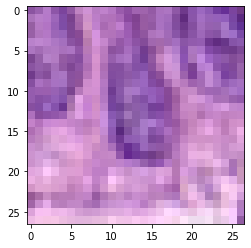

462.png


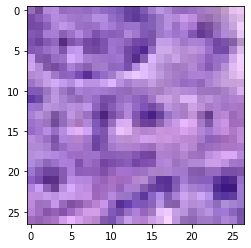

11778.png


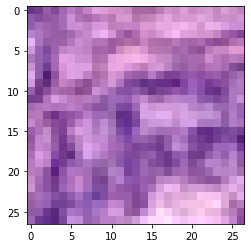

13929.png


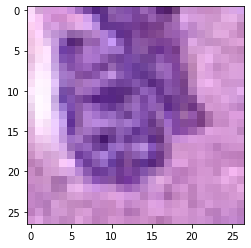

3889.png


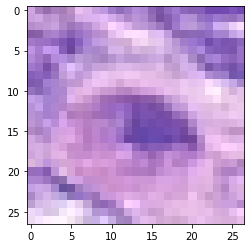

8828.png


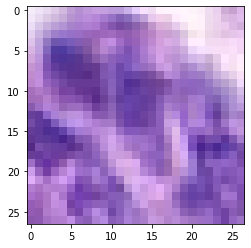

4838.png


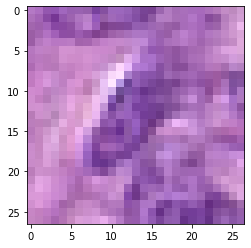

8247.png


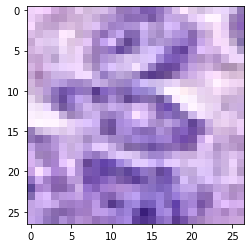

13898.png


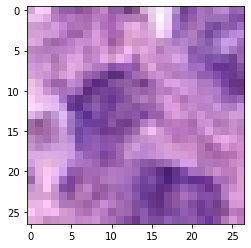

3560.png


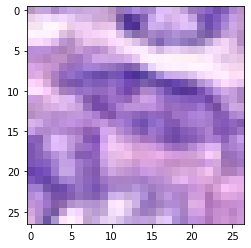

In [56]:
print("Cancerous Cells")
for random_cancerous_image in random_cancerous_images:
    
    print(random_cancerous_image)
    test_img = train_dir+random_cancerous_image
    fn = image.load_img(test_img, target_size = (27,27))
    plt.imshow(fn)
    plt.show()

Non-Cancerous Cells
134.png


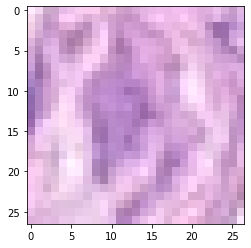

17407.png


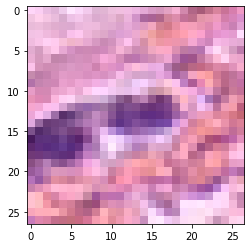

18875.png


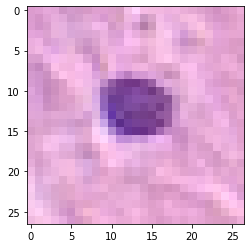

408.png


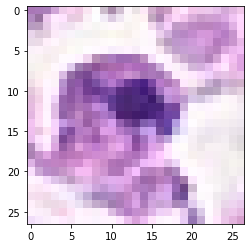

18094.png


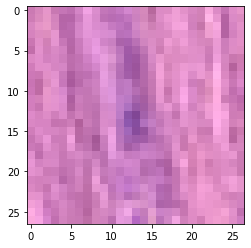

15970.png


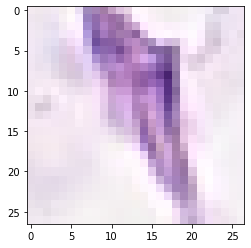

18530.png


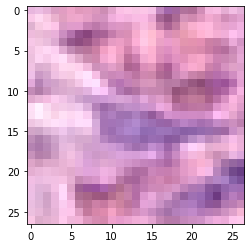

9060.png


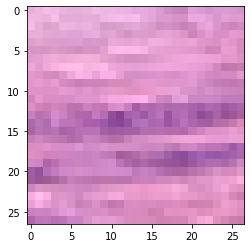

7690.png


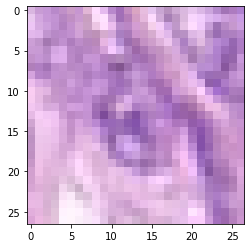

16882.png


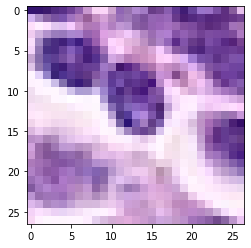

In [57]:
print("Non-Cancerous Cells")
for random_noncancerous_image in random_noncancerous_images:
    
    print(random_noncancerous_image)
    test_img = train_dir+random_noncancerous_image
    fn = image.load_img(test_img, target_size = (27,27))
    plt.imshow(fn)
    plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - To the average person who doesn't specialize in this field, there is no visibly discernible patterns or differences between the two types
 - Further analysis will have to be done to understand these images better

In [60]:
# Some code taken and modified from - https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

cancerous_cell_imgs = list(data['ImageName'][data['isCancerous']==1])
noncancerous_cell_imgs = list(data['ImageName'][data['isCancerous']==0])

# making n X m matrix
def img2np(path, list_of_filename, size = (27, 27)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images = img2np(train_dir, noncancerous_cell_imgs)
cancerous_images = img2np(train_dir, cancerous_cell_imgs)

In [61]:
# making n X m matrix
def img2npColored(path, list_of_filename, size = (27, 27)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size)
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images_colored = img2npColored(train_dir, noncancerous_cell_imgs)
cancerous_images_colored = img2npColored(train_dir, cancerous_cell_imgs)

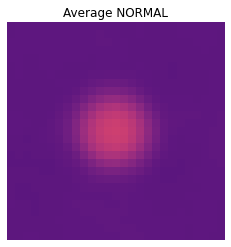

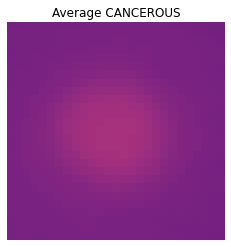

In [101]:
def find_mean_img(full_mat, title, size = (27, 27)):
    
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='magma_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
cancer_mean = find_mean_img(cancerous_images, 'CANCEROUS')

<span style="font-size:1em;">✔</span> **Observations:**
 - The average cancerous cell and average non-cancerous cell images are not too easily distinguished, with only the average cancerous cell image having a larger and more faint center while the non-cancerous images on average are brighter and more concentrated in the center
 - The surrounding colors of the cancerous images are also lighter

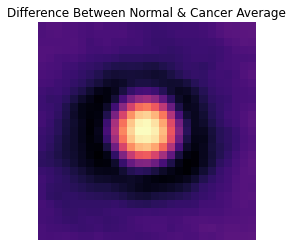

In [107]:
contrast_mean = norm_mean - cancer_mean
plt.imshow(contrast_mean, cmap='magma_r')
plt.title(f'Difference Between Normal & Cancer Average')
plt.axis('off')
plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - The difference between both the averages raises the same observations as above, with the brightness of the center and surrounding colors differing
 - It will be worth lookng at this in different color maps

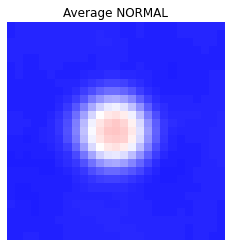

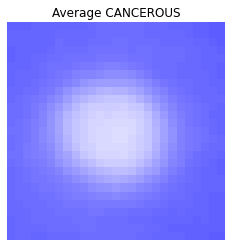

In [103]:
def find_mean_img(full_mat, title, size = (27, 27)):
    
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='seismic_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
cancer_mean = find_mean_img(cancerous_images, 'CANCEROUS')

<span style="font-size:1em;">✔</span> **Observations:**
 - The differences here are similar to the previous colour map, however they make the differences more distinct, and add some visibly differences to the center of the normal cells
 

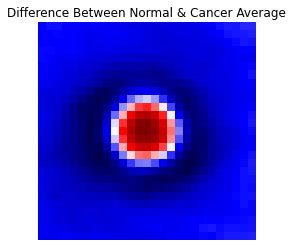

In [108]:
contrast_mean = norm_mean - cancer_mean
plt.imshow(contrast_mean, cmap='seismic_r')
plt.title(f'Difference Between Normal & Cancer Average')
plt.axis('off')
plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - The image here highlight the stark difference in color of the center between the two averages

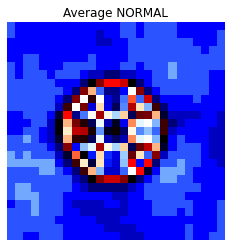

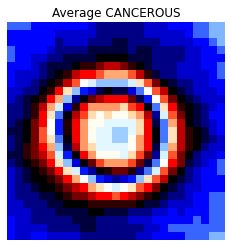

In [104]:
def find_mean_img(full_mat, title, size = (27, 27)):
    
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='flag_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
cancer_mean = find_mean_img(cancerous_images, 'CANCEROUS')

<span style="font-size:1em;">✔</span> **Observations:**
 - This colormap highlights newer differences by exaggerating certain aspects of the two averages - and it paints two very different types of cells on average from the original colormap we looked at
 - The cancerous cell images have a considerably larger center with smaller circular bands inside, wheras the non-cancerous images tend to be concentrated in the center and see to form some kind of a patter
 - The border for the cancerous cell images are also less distinct than the non-cancerous counterpart

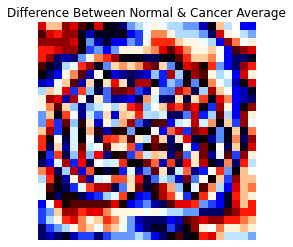

In [109]:
contrast_mean = norm_mean - cancer_mean
plt.imshow(contrast_mean, cmap='flag_r')
plt.title(f'Difference Between Normal & Cancer Average')
plt.axis('off')
plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
 - Due to the exaggeration of this colormap, the difference does not show any discernible way to separate the two

# Evaluation

### Cancerous Cell Identification

The importance of detecting cancers early in order to maximise the likelihood that treatments will be successful, as well as the serious nature of malignant tumours, which left untreated will usually be fatal, means that it is well-advised to take a cautious approach when identifying cancer.

As a result of the relative effectiveness of prevention and early detection, a higher rate of false positives is regarded as acceptable, than false negatives. False positives will inconvenience a patient but generally be identified as such in other examinations (eg, colonoscopies, further biopsies, ct scans). In contrast, the failure to detect a cancer could lead to a patient becoming seriously ill or dying.

Consequently, in the inenvitable tradeoff between recall and precision, high recall will be preferred to minimise false negatives. In addition, accuracy is helpful as a secondary indicator, but the importance of this metric is less than f1-score, for example, as the class imbalances observed earlier can lead to misleadingly high accuracy (from the dominant class being predicted too frequently).

### Cell Type Classification
For cell type there is less imperative to minimise either false positives or negatives, so f1-score which balances the influence of recall and precision should instead be used solely as the primary evaluation metric. Accuracy can again be used as a secondary indicator of model performance. F1-score was used by the authors of the article and study which proudced the source dataset (cropped images of cell nuclei) (Locality Sensitive Deep Learning for Detection and Classification of Nuclei in Routine Colon Cancer Histology Images). From the EDA, it was found that epithelial is most important to classify, because we want to know if patients have cancer. The weight averaged F1-score is important to assess the performance of only classifying epthelial cells. The macro average F1-score is important to assess the performance of classifying all cell types. There is a class imbalance so it's expected that there will be a higher weighted average than macro

In [192]:
def get_f1_score(precision, recall):
    if precision+recall==0:
        return 0
    return 2*((precision*recall)/(precision+recall))

# Model Development - Cancerous Cell Identification 

In [193]:
main_data = pd.read_csv('./data_labels_mainData.csv')
data_extra = pd.read_csv('./data_labels_extraData.csv')

data = pd.concat([main_data, data_extra], axis=0)

# Splitting training and test data about a standard 60/20/20 training/validation/test split.
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)

## Comparing Models and Selecting models to fine-tune

3 Convolutional neural networks (CNNs) were tested and their effectiveness without tuning was compared.

#### Lenet5
The lenet model was designed for identifying handwritten digits in small images of the MNIST dataset (Géron, 2019) and so is thought to demonstrate good performance when identifying small images. Little preprocessing of the input images is required to make them fit this architecture as it takes 32x32 input images. Zero-padding is performed on the image data to make sure it fits the dimensions of the input layer.

In [194]:
INPUT_DIM = (27,27,3)

lenet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.ZeroPadding2D(padding=((2,3), (2,3))),
    
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation="relu"),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

A visual graph of the architecture can be found below.

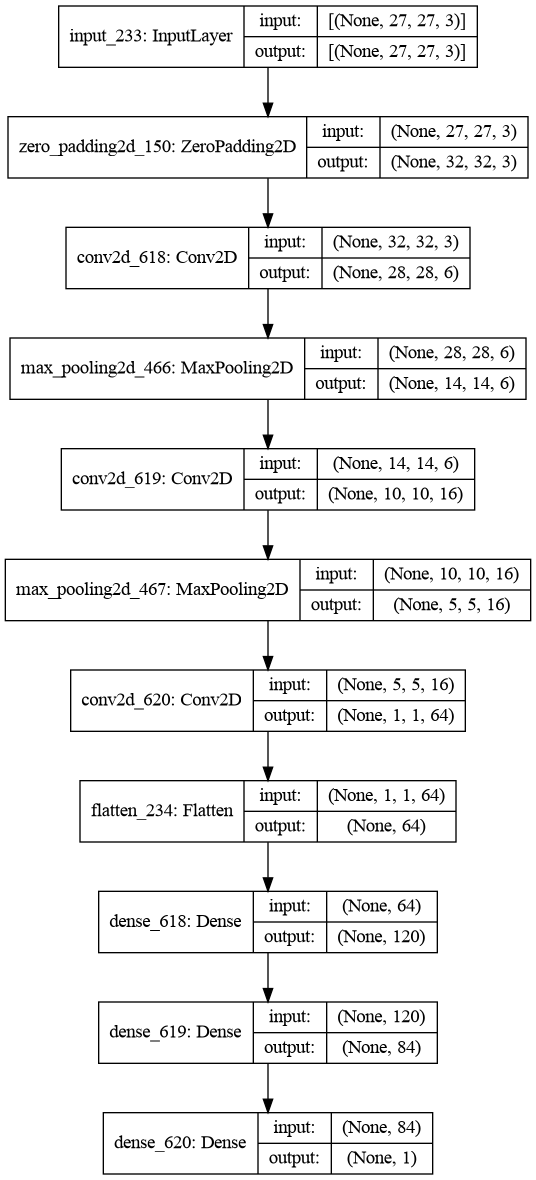

In [195]:
tf.keras.utils.plot_model(lenet, show_shapes=True)

In [196]:
lenet.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

#### Spatially-constrained Model
This CNN architecture is similar to, and inspired by the architecture found to be most effective for the identification of cell-type on this dataset by Sirinukunwattana et al. (2016). Note that it differs in the sense that the classification problem for cancerous cell classification is a binary classification problem. Accordingly, the activiation function has been changed to sigmoid from softmax.

In [ ]:
sc_softmax = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    
    tf.keras.layers.Conv2D(filters=36, kernel_size=4, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


A graph visualising this CNN architecture and showing it's steps can be found below.

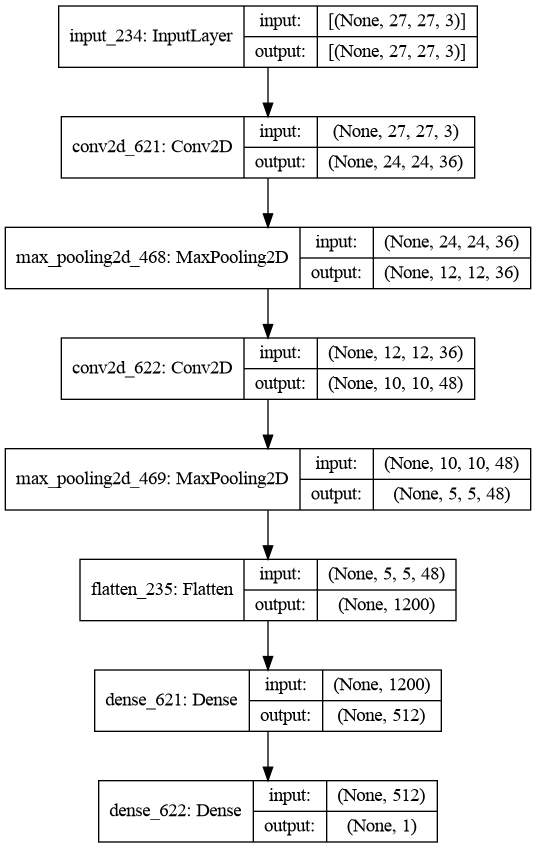

In [198]:
tf.keras.utils.plot_model(sc_softmax, show_shapes=True)

In [199]:
sc_softmax.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

#### Custom model
A small custom cnn architecture was developed from scratch to act as a baseline. It is a best guess of an effective architecture, based on the former two. While it is not expected to perform as well as the former two models, it should be useful as a baseline to assess the performance of the others.

In [200]:
custom_model =  tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu",input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

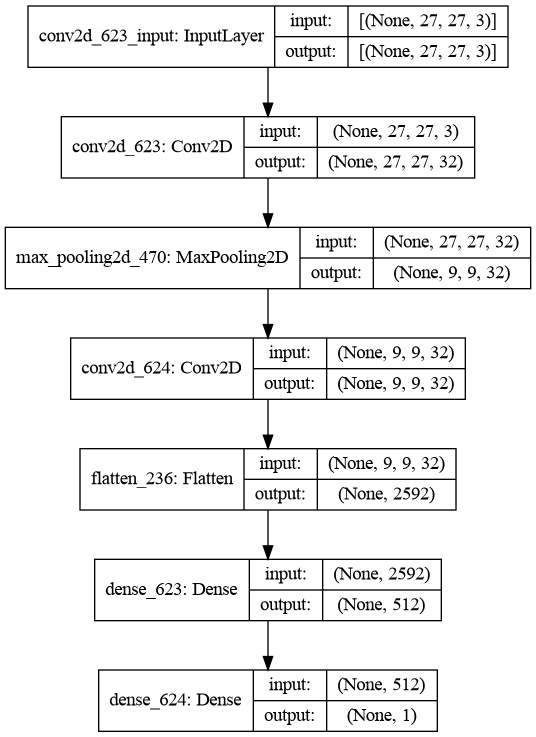

In [201]:
tf.keras.utils.plot_model(custom_model, show_shapes=True)

In [202]:
custom_model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

### Generating input data
Data generators were written to read the images from the file names contained in the attached csvs. They are then converted to tensors.

In [203]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


<ipython-input-203-ee67798763a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['isCancerous'] = test_data['isCancerous'].astype('str')


### Callbacks
Some callbacks were written to ensure early stopping and reporting of progress (fitting the models took considerable time so this was important).

In [204]:
class ProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(epoch, end=", ")

cback = ProgressCallback()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Next the loss curves of the models were tested without hyperparameter tuning to get an idea of which was/were the most promising and warranted further investigation.

In [215]:
lenet_history = lenet.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)
sc_history = sc_softmax.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)
custom_history = custom_model.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

The loss curves, accuracy, Area under curve and recall were plotted to determine the relative efficacy of these architectures.

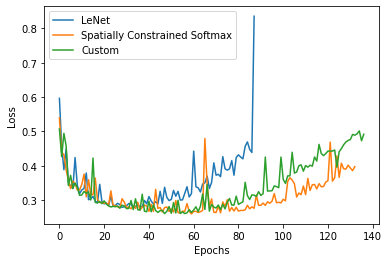

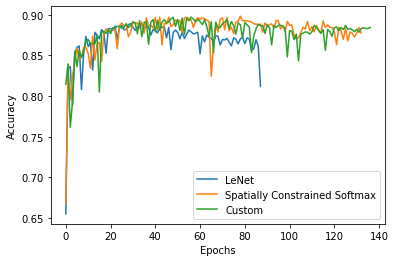

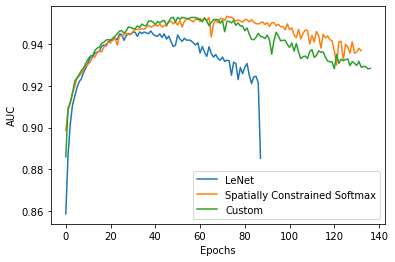

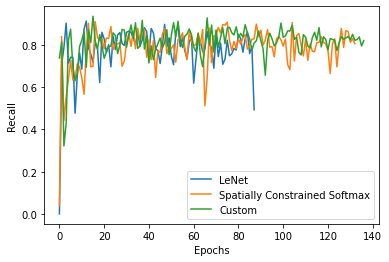

In [67]:
def plot_curve(num_epochs, curves):
    for i in curves:
        fig.plot(range(0,num_epochs), i)

plt.figure()
plt.plot(range(0,len(lenet_history.history['loss'])), lenet_history.history['val_loss'], label="LeNet")
plt.plot(range(0,len(sc_history.history['loss'])), sc_history.history['val_loss'], label="Spatially Constrained Softmax")
plt.plot(range(0,len(custom_history.history['loss'])), custom_history.history['val_loss'], label="Custom")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(range(0,len(lenet_history.history['loss'])), lenet_history.history['val_binary_accuracy'], label="LeNet")
plt.plot(range(0,len(sc_history.history['loss'])), sc_history.history['val_binary_accuracy'], label="Spatially Constrained Softmax")
plt.plot(range(0,len(custom_history.history['loss'])), custom_history.history['val_binary_accuracy'], label="Custom")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(range(0,len(lenet_history.history['loss'])), lenet_history.history['val_auc'], label="LeNet")
plt.plot(range(0,len(sc_history.history['loss'])), sc_history.history['val_auc'], label="Spatially Constrained Softmax")
plt.plot(range(0,len(custom_history.history['loss'])), custom_history.history['val_auc'], label="Custom")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.figure()
plt.plot(range(0,len(lenet_history.history['loss'])), lenet_history.history['val_recall'], label="LeNet")
plt.plot(range(0,len(sc_history.history['loss'])), sc_history.history['val_recall'], label="Spatially Constrained Softmax")
plt.plot(range(0,len(custom_history.history['loss'])), custom_history.history['val_recall'], label="Custom")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()


The spatially constrained softmax model was found to be most effective overall.

# Spatially-Constrained Model
First the spatially-constrained architecture was used as the basis for a model.

The loss functions for classification on training and validation data were plotted to get an idea of the model's efficacy without any hyperparameter tuning or adjustments to the learning rate.

In [68]:
sc_softmax = tf.keras.models.clone_model(sc_softmax)

sc_softmax.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

sc_softmax_history = sc_softmax.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0, callbacks=[cback, early_stopping])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 

In [76]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

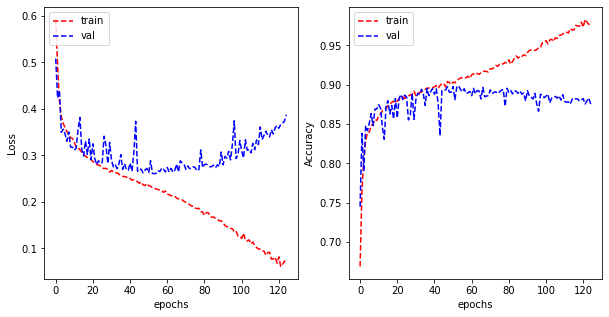

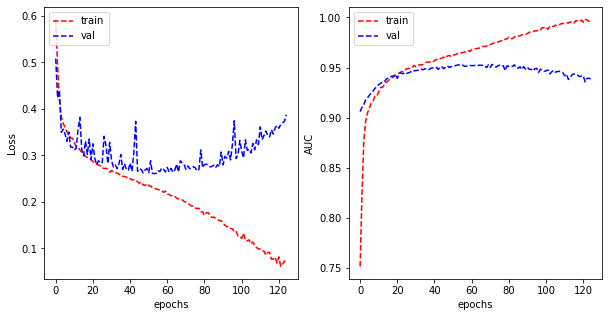

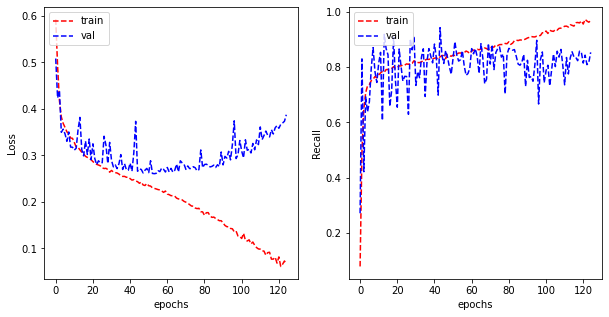

In [77]:
history = sc_softmax_history

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['binary_accuracy'], history.history['val_binary_accuracy'], 
                    metric_name='Accuracy', )


plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['auc'], history.history['val_auc'],
                    metric_name='AUC')

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['recall'], history.history['val_recall'],
                    metric_name='Recall')

It can immediately and easily be observed that the model is overfitting for the training data and that regularisation will be required.

## Regularisation

Dropout layers with different parameters were tested, at intervals of 0.1 between 0 and 1

In [78]:
models = []
models_history = []

for i in range(0,9):    
    sc_softmax = tf.keras.Sequential([
        tf.keras.layers.Input(shape=INPUT_DIM),

        tf.keras.layers.Conv2D(filters=36, kernel_size=4, activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(i/10),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    models.append(i)
    
    sc_softmax.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

    models_history.append(sc_softmax.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0, callbacks=[early_stopping]))
    


The minimum value of the loss function when using dropout (across all epochs) was then plotted for all strengths passed to the dropout layer.

(0.25, 0.3)

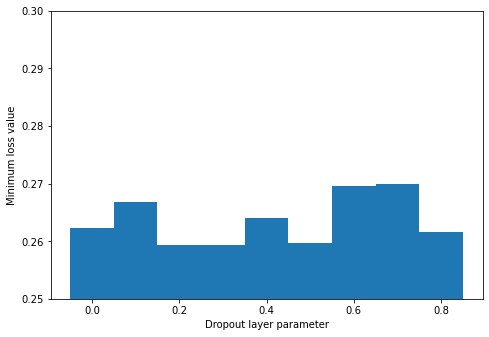

In [79]:
loss_vals = []
for i in models_history:
    loss_vals.append(min(i.history["val_loss"]))
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
plt.xlabel("Dropout layer parameter")
plt.ylabel("Minimum loss value")
plt.bar([i/10 for i in range(0,9)], loss_vals, width=0.1)
axes.set_ylim(0.25,0.3)

While it has little effect, and the effects of the dropout layer could lie within a reasonable margin of error, it can be observed that loss is minimised when the value for the dropout layer is set to 0.2, 0.3 or 0.5. As a result, 0.3 will be chosen as the value for the dropout layer.

The effect of this amount of dropout on overfitting was then plotted (the loss function/evaluation metrics for classification on the training and validation datasets, respectively).

In [101]:
sc_softmax_dropout = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    
    tf.keras.layers.Conv2D(filters=36, kernel_size=4, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


In [102]:
sc_softmax_dropout.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

sc_softmax_dropout_history = sc_softmax_dropout.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0, callbacks=[early_stopping])

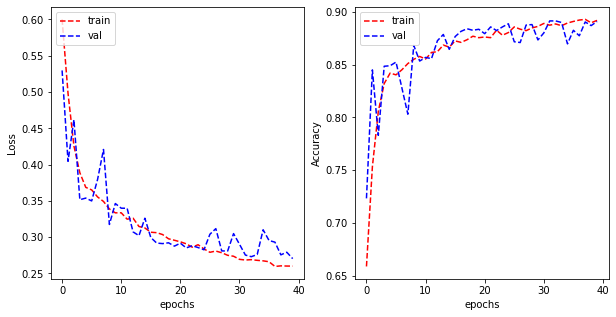

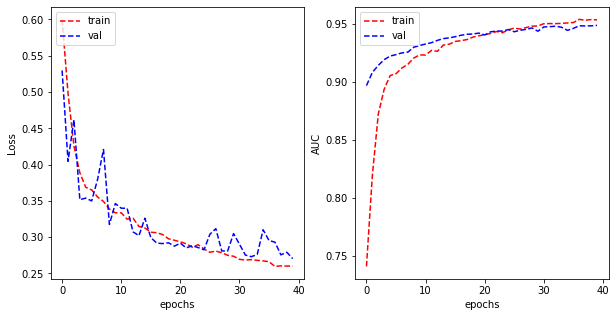

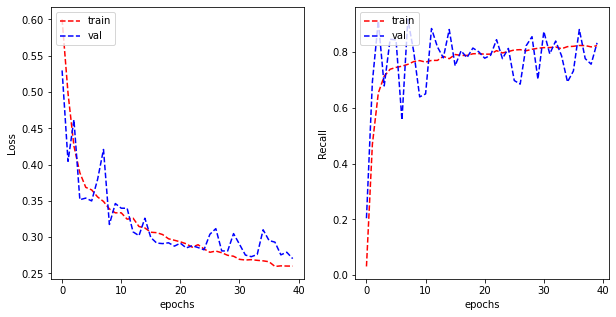

In [103]:
history = sc_softmax_dropout_history

import matplotlib.pyplot as plt
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['binary_accuracy'], history.history['val_binary_accuracy'], 
                    metric_name='Accuracy', )


plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['auc'], history.history['val_auc'],
                    metric_name='AUC')

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['recall'], history.history['val_recall'],
                    metric_name='Recall')

With the addition of a dropout layer, there is a clear improvement to the consistency of performance through reduction of overfitting, but further tuning is required as the loss curves for training and validation diverge. This will be achieved by adjusting the learning rate over time (lowering the learning rate when progressing into subsequent epochs).

### Learning Rate

Adjusting the learning rate as training progresses allows the 

In [106]:
import numpy as np

sc_lr_histories = {}

def get_min_loss(history):
    return min(history.history["val_loss"])

for i in [0.1,0.3,0.5,0.7,0.9]:
    sc_lr_histories[i] = {}
    for j in np.linspace(1, 1e+3, 10):
        sc_lr = tf.keras.Sequential([
            tf.keras.layers.Input(shape=INPUT_DIM),

            tf.keras.layers.Conv2D(filters=36, kernel_size=4, activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=0.1,
                decay_steps=j,
                decay_rate=i,
                staircase=False)

        sc_lr.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])
        sc_lr_histories[i][j] = sc_lr.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


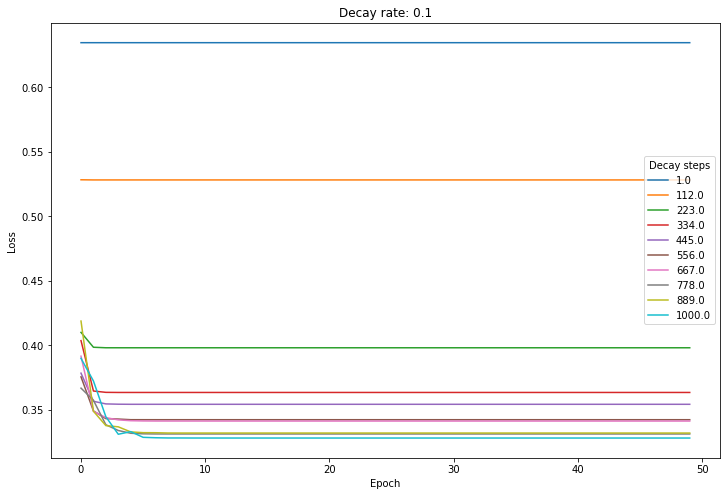

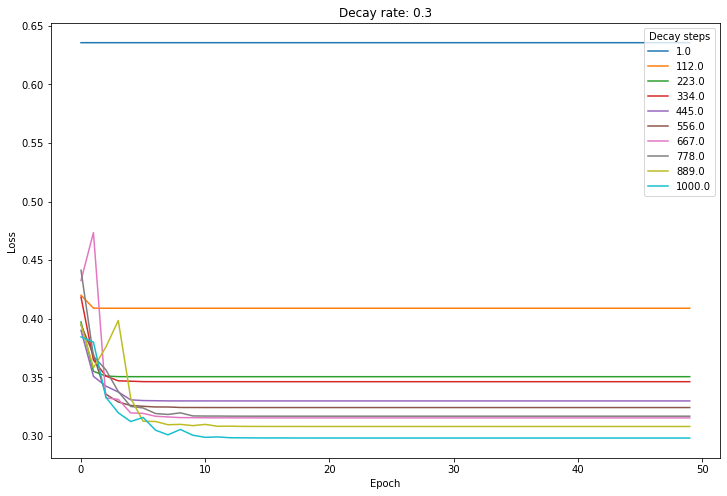

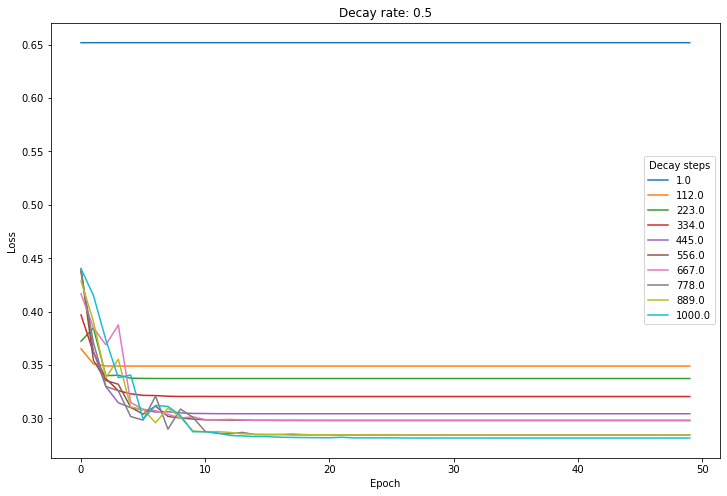

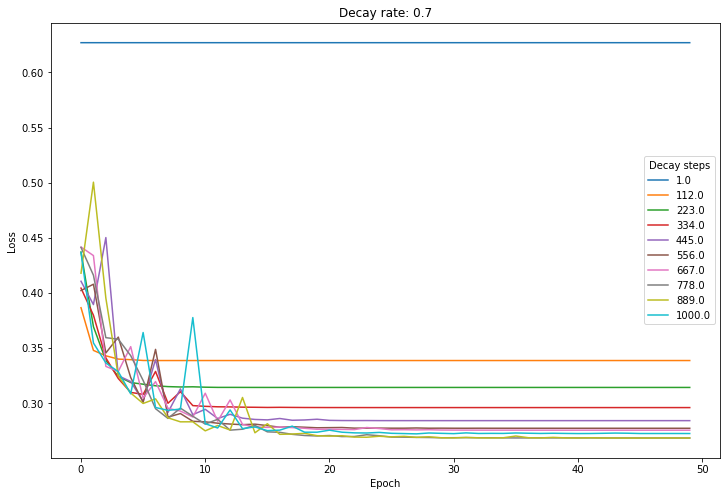

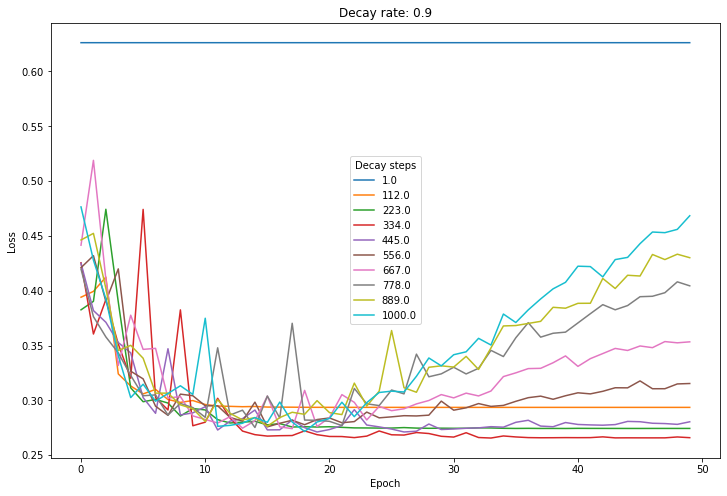

In [110]:
for i in sc_lr_histories.keys():
    plt.figure(figsize=(12,8))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Decay rate: "+str(i))
    for j in sc_lr_histories[i].keys():
        plt.plot(sc_lr_histories[i][j].history["val_loss"], label=str(j))
    plt.legend(title="Decay steps")

In [153]:
sc_lr = tf.keras.Sequential([
            tf.keras.layers.Input(shape=INPUT_DIM),

            tf.keras.layers.Conv2D(filters=36, kernel_size=4, activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

### Data Augmentation
Next, additional data is generated by performing manipulations on the dataset. The resulting modified images contain derivative albeit potentially useful data to serve as insights which can provide additional support in the training step. This can help improve the performance of the model.

In [154]:
def create_augmentation_generator(horizontal_flip=False,
                                vertical_flip = False,
                                rotation_range=None,
                                width_shift_range=None,
                                height_shift_range=None,
                                brightness_range=None,
                                shear_range=0.0):
    train_augment_datagen = ImageDataGenerator(rescale=1./255,
                                               horizontal_flip=horizontal_flip,
                                               vertical_flip=vertical_flip,
                                               rotation_range=rotation_range,
                                               width_shift_range=width_shift_range,
                                               height_shift_range=height_shift_range,
                                               brightness_range=brightness_range,
                                               shear_range=shear_range,
                                               data_format='channels_last')
    val_augment_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

    batch_size = 32

    train_augment_generator = train_augment_datagen.flow_from_dataframe(
            dataframe=train_data,
            directory='./patch_images',
            x_col="ImageName",
            y_col="isCancerous",
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode='binary')

    validation_augment_generator = val_augment_datagen.flow_from_dataframe(
            dataframe=val_data,
            directory='./patch_images',
            x_col="ImageName",
            y_col="isCancerous",
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode='binary')
    
    return train_augment_generator, validation_augment_generator

In [155]:
augmentations = {'Flip': create_augmentation_generator(horizontal_flip=True, vertical_flip=True),
                'Rotate': create_augmentation_generator(rotation_range=90),
                'Translated': create_augmentation_generator(width_shift_range=27/2,
                                                            height_shift_range=27/2),
                'Brightness': create_augmentation_generator(brightness_range=(0.5,1.5)),
                'Shear': create_augmentation_generator(shear_range=90)}

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


Some samples of images on which preprocessing has been performed and which are to be added to the augmented dataset are shown below.

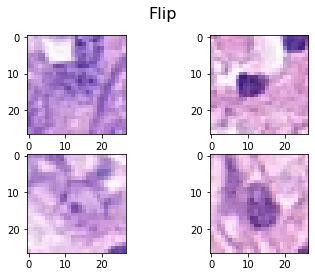

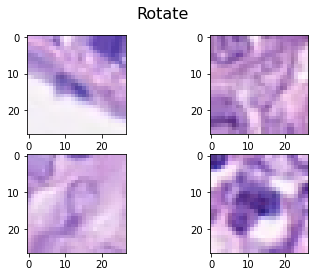

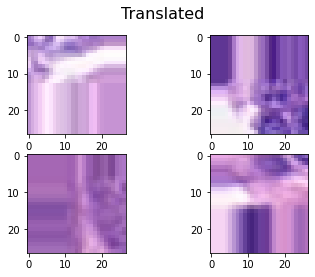

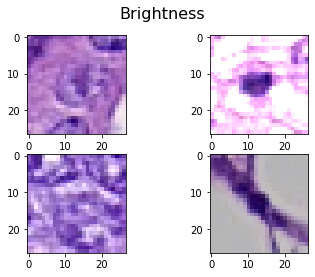

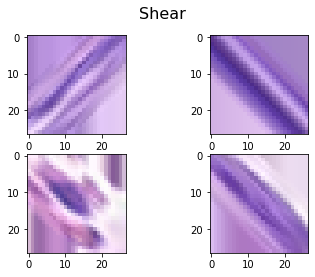

In [156]:
for i in augmentations.keys():
    fig = plt.figure()
    for j in range(4):
        fig.add_subplot(2, 2, j+1)
        img, label = augmentations[i][0].next()
        plt.imshow(img[0])
    fig.suptitle(i, fontsize=16)

It can be easily observed that shear and translate operations lead to significant data loss and will likely lead to lower performance when used to train the model.

In [157]:
def fit_augmentation(train_gen, val_gen, model):
    sc_lr = tf.keras.models.clone_model(model)

    sc_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=0.1,
                decay_steps=250,
                decay_rate=0.9,
                staircase=False)

    sc_lr.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=sc_lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

    return sc_lr.fit_generator(train_gen, validation_data = val_gen, epochs=50, verbose=0, callbacks=[cback])


In [158]:
sc_augmentation_histories = {}
for i in augmentations.keys():
    sc_augmentation_histories[i] = fit_augmentation(augmentations[i][0], augmentations[i][1], sc_lr).history

/home/jye/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/jye/.local/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

In [172]:
def get_min_loss(history):
    return min(history["val_loss"])

def get_max_accuracy(history):
    return max(history["val_binary_accuracy"])

def get_max_auc(history):
    return max(history["val_auc"])

def get_max_f1_score(history):
    f1_scores = []
    for j in zip(history["val_precision"], history["val_recall"]):
        f1_scores.append(get_f1_score(j[0], j[1]))
    return max(f1_scores)

def plot_validation_performance_curves(histories):
    # Loss
    plt.figure(figsize=(12,8))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    for i in histories.keys():
        plt.plot(histories[i]["val_loss"], label=i)
    plt.legend()
    
    # Accuracy
    plt.figure(figsize=(12,8))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    for i in histories.keys():
        plt.plot(histories[i]["val_binary_accuracy"], label=i)
    plt.legend()
    
    # Area under curve.
    plt.figure(figsize=(12,8))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    for i in histories.keys():
        plt.plot(histories[i]["val_auc"], label=i)
    plt.legend()
    
    # F1-Scores
    plt.figure(figsize=(12,8))
    plt.xlabel("Epoch")
    plt.ylabel("F1-Score")
    for i in histories.keys():
        f1_scores = []
        for j in zip(histories[i]["val_precision"], histories[i]["val_recall"]):
            f1_scores.append(get_f1_score(j[0], j[1]))
        plt.plot(f1_scores, label=i)
    plt.legend()

  Augmentation Feature      Loss  Accuracy       AUC  F1-Scores
0                 Flip  0.277654  0.890533  0.945634   0.837838
1               Rotate  0.276708  0.890533  0.946316   0.835526
2           Translated  0.331887  0.863412  0.925706   0.788064
3           Brightness  0.304939  0.871795  0.935253   0.809540
4                Shear  0.293215  0.880671  0.941344   0.823358
5  Flipped and Rotated  0.276869  0.891026  0.945504   0.838686


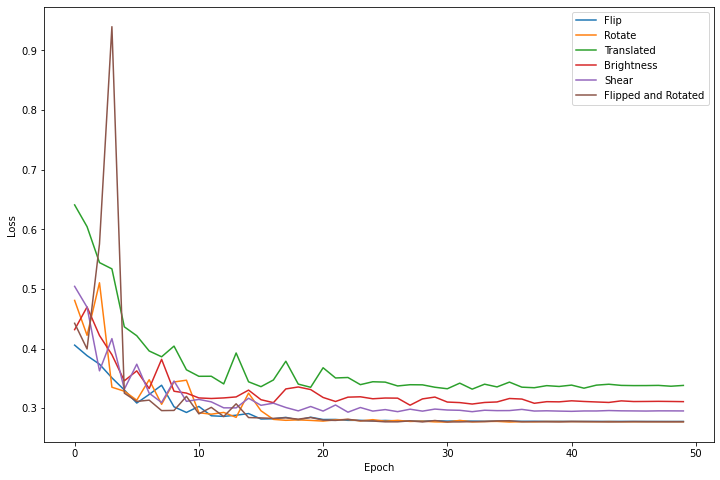

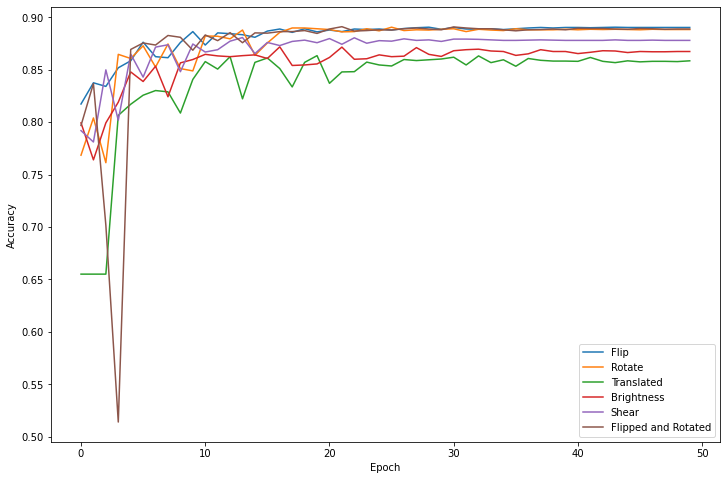

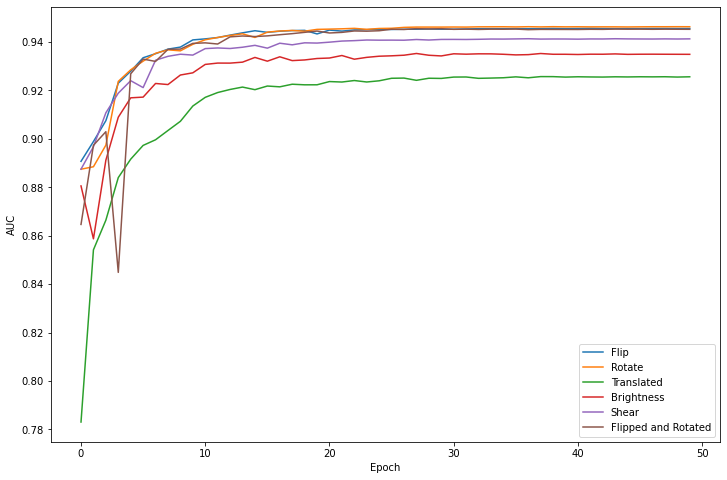

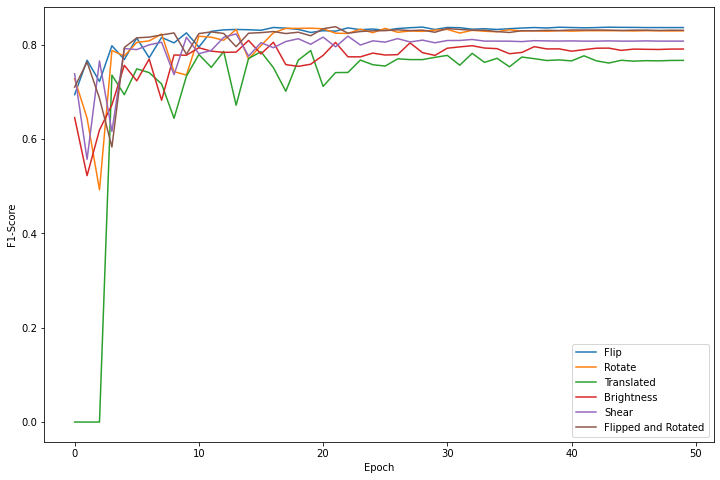

In [173]:
plot_validation_performance_curves(sc_augmentation_histories)

operations = []
losses = []
accuracies = []
auc = []
f1_scores = []
for i in sc_augmentation_histories.keys():
    operations.append(i)
    losses.append(get_min_loss(sc_augmentation_histories[i]))
    accuracies.append(get_max_accuracy(sc_augmentation_histories[i]))
    auc.append(get_max_auc(sc_augmentation_histories[i]))
    f1_scores.append(get_max_f1_score(sc_augmentation_histories[i]))
    
metrics = {"Augmentation Feature": operations, "Loss": losses, "Accuracy": accuracies, "AUC": auc, "F1-Scores": f1_scores}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Of the operations performed for generating additional image data, flipping and rotating the images led to the lowest amount of loss and highest f1-scores. As a result, a combination of these two operations will be evaluated alongside no data augmentation and a combination of all tested augmentations.

In [382]:
flip_rotate_generator = create_augmentation_generator(horizontal_flip=True,
                      vertical_flip = True,
                      rotation_range=90,
                      width_shift_range=None,
                      height_shift_range=None,
                      brightness_range=None,
                      shear_range=None)

sc_augmentation_histories["Flipped and Rotated"] = fit_augmentation(flip_rotate_generator[0], flip_rotate_generator[1], sc_lr).history

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


/home/jye/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/jye/.local/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

In [378]:
mix_generator = create_augmentation_generator(horizontal_flip=True,
                                vertical_flip = True,
                                rotation_range=90,
                                width_shift_range=27/2,
                                height_shift_range=27/2,
                                brightness_range=(0.5,1.5),
                                shear_range=90)
sc_augmentation_histories["Combined"] = fit_augmentation(mix_generator[0], mix_generator[1], sc_lr).history


Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


/home/jye/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/jye/.local/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

In [175]:

none_generator = create_augmentation_generator(horizontal_flip=False,
                                vertical_flip = False,
                                rotation_range=None,
                                width_shift_range=None,
                                height_shift_range=None,
                                brightness_range=None,
                                shear_range=None)
sc_augmentation_histories["None"] = fit_augmentation(none_generator[0], none_generator[1], sc_lr).history

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


/home/jye/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/jye/.local/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

Text(0.5, 0.98, 'Combination of all augmentation operations')

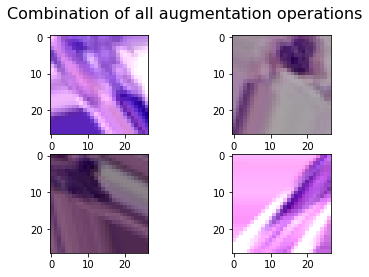

In [386]:
fig = plt.figure()
for j in range(4):
    fig.add_subplot(2, 2, j+1)
    img, label = mix_generator[0].next()
    plt.imshow(img[0])
fig.suptitle("Combination of all augmentation operations", fontsize=16)

It can be observed that combining all operations has lead to significant data loss and loss of feature identifiability. This will likely lead to subpar performance.

  Augmentation Feature      Loss  Accuracy       AUC  F1-Scores
0                 Flip  0.277654  0.890533  0.945634   0.837838
1               Rotate  0.276708  0.890533  0.946316   0.835526
2           Translated  0.331887  0.863412  0.925706   0.788064
3           Brightness  0.304939  0.871795  0.935253   0.809540
4                Shear  0.293215  0.880671  0.941344   0.823358
5  Flipped and Rotated  0.276869  0.891026  0.945504   0.838686
6                 None  0.272447  0.892012  0.947848   0.842105


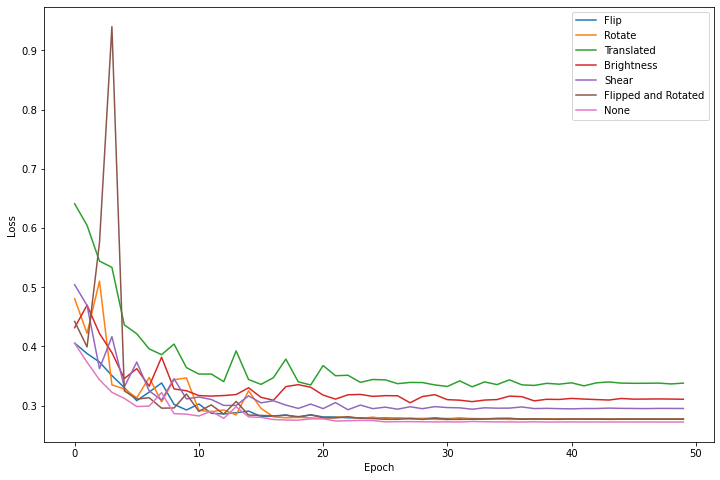

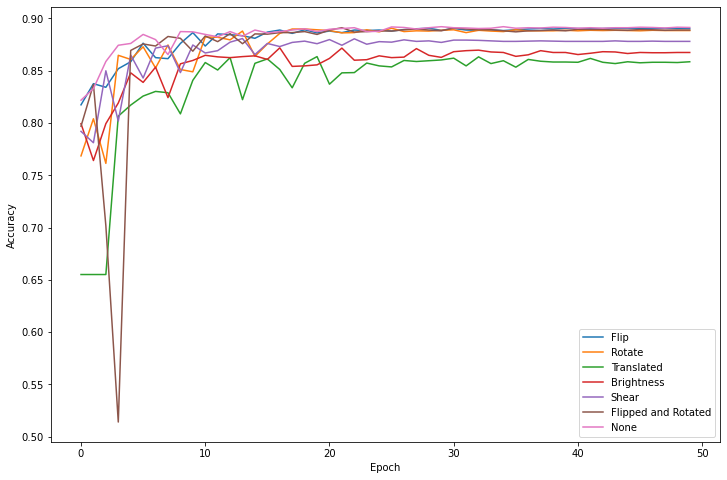

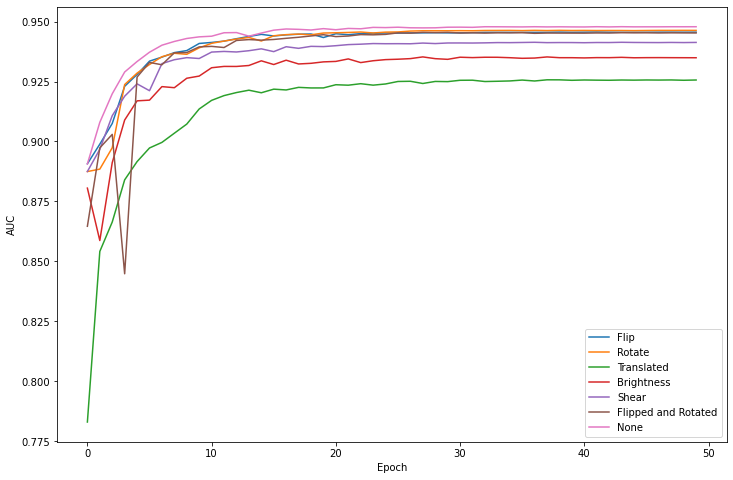

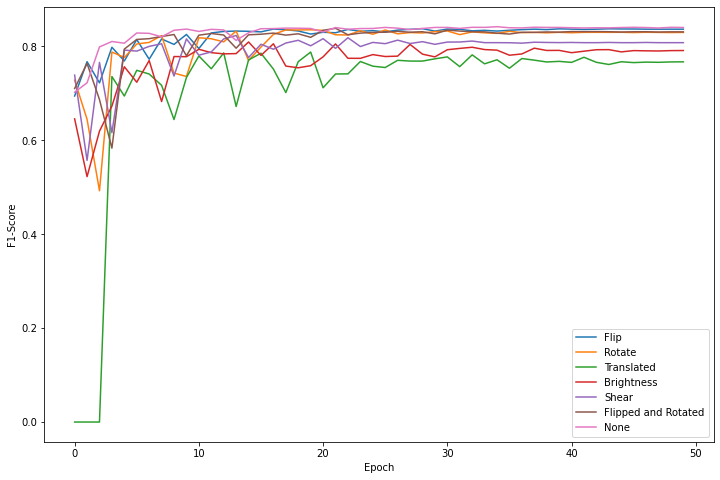

In [176]:
plot_validation_performance_curves(sc_augmentation_histories)

operations = []
losses = []
accuracies = []
auc = []
f1_scores = []
for i in sc_augmentation_histories.keys():
    operations.append(i)
    losses.append(get_min_loss(sc_augmentation_histories[i]))
    accuracies.append(get_max_accuracy(sc_augmentation_histories[i]))
    auc.append(get_max_auc(sc_augmentation_histories[i]))
    f1_scores.append(get_max_f1_score(sc_augmentation_histories[i]))
    
metrics = {"Augmentation Feature": operations, "Loss": losses, "Accuracy": accuracies, "AUC": auc, "F1-Scores": f1_scores}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

As expected, the performance of the model with all augmentation operations combined is relatively poor. It is also  observed that no data augmentation operations provide a significant increase in performance by any metric, and so data augmentation will not be used in conjunction with the spatially-constrained model.

Optimal hyperparameters for spatially constrained softmax:
- Dropout layer with strength of 0.3
- Exponential decay for learning rate with parameters:
    - decay rate = 0.9
    - decay steps = 250

## Lenet Model

A model based on the LeNet5 Convolution neural network (CNN) architecture was also tested with the same methods applied to the spatially-constrained model. Despite not performing as well as the custom model without hyperparameter tuning, there are indications that this CNN architecture is well-suited to serve as the basis for a model to tackle the problem at hand. The architecture has been used and tested widely, while being designed to effectively classify MNIST images (Géron, 2019) which are of a similar size to the histology patch images that we are processing.

In [111]:
import tensorflow as tf
INPUT_DIM=(27,27,3)
lenet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.ZeroPadding2D(padding=((2,3), (2,3))),
    
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation="relu"),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [112]:
lenet.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

In [113]:
lenet_history = lenet.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0, callbacks=[cback, early_stopping])


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 

The learning curves of the Lenet model are plotted prior to hyperparamter tuning.

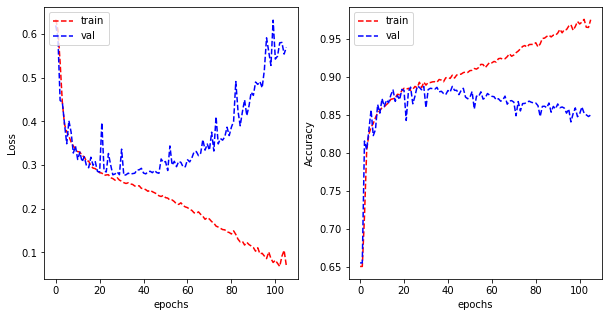

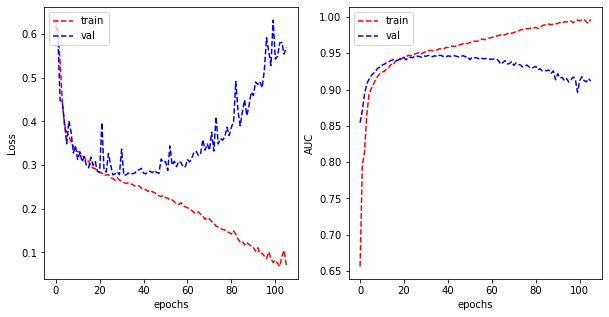

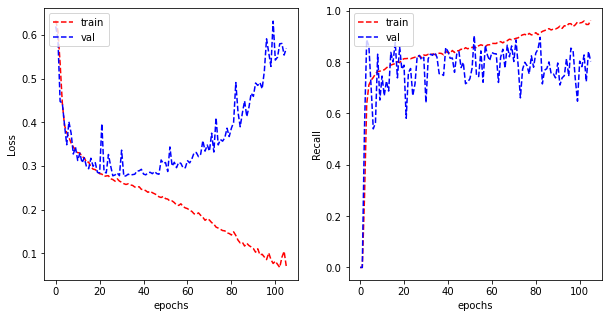

In [114]:
history = lenet_history

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['binary_accuracy'], history.history['val_binary_accuracy'], 
                    metric_name='Accuracy', )


plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['auc'], history.history['val_auc'],
                    metric_name='AUC')

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['recall'], history.history['val_recall'],
                    metric_name='Recall')

The model is signficantly overfitted to the training data, meaning that performance on validation/test data is inconsistent.

The Lenet architecture deomonstrates similar maximum performance to the spaitally-constrained model for this problem, and may outperform it through hyperparameter tuning.

In [115]:
def get_f1_score(precision, recall):
    if precision+recall==0:
        return 0
    return 2*((precision*recall)/(precision+recall))

## Regularisation

Dropout layers with different parameters were tested, at intervals of 0.1 between 0 and 1

In [168]:
sc_lr = tf.keras.Sequential([
            tf.keras.layers.Input(shape=INPUT_DIM),

            tf.keras.layers.Conv2D(filters=36, kernel_size=4, activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

In [169]:
models = []
models_history = []

for i in range(0,9):
    lenet_dropout = tf.keras.Sequential([
        tf.keras.layers.Input(shape=INPUT_DIM),
        tf.keras.layers.ZeroPadding2D(padding=((2,3), (2,3))),

        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation="relu"),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dropout(i*0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    models.append(i)
    
    lenet_dropout.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

    models_history.append(lenet_dropout.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0, callbacks=[early_stopping]))
    


(0.25, 0.3)

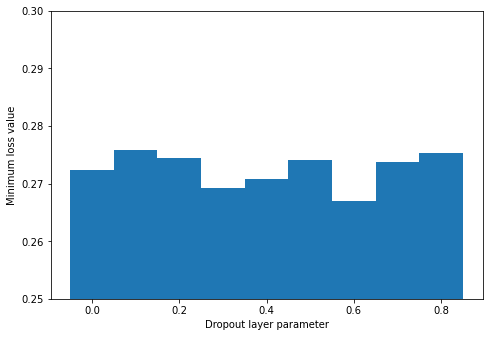

In [207]:
loss_vals = []
for i in models_history:
    loss_vals.append(min(i.history["val_loss"]))
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
plt.xlabel("Dropout layer parameter")
plt.ylabel("Minimum loss value")
plt.bar([i/10 for i in range(0,9)], loss_vals, width=0.1)
axes.set_ylim(0.25,0.3)

The lenet model  does not appear to benefit substantially or consistently from the use of a dropout layer, and so it will not be used.

### Learning Rate
An exponential decay function was used to alter the learning rate. A time-consuming grid-search was performed to determine the optimal pair of number of steps per decay and decay rate for minimum loss.

In [217]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

lenet_lr_histories = {}

def get_min_loss(history):
    return min(history.history["val_loss"])

for i in [0.1,0.3,0.5,0.7,0.9]:
    lenet_lr_histories[i] = {}
    for j in np.linspace(1, 1e+3, 10):
        lenet_lr = tf.keras.Sequential([
            tf.keras.layers.Input(shape=INPUT_DIM),
            tf.keras.layers.ZeroPadding2D(padding=((2,3), (2,3))),

            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

            tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

            tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation="relu"),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=0.1,
                decay_steps=j,
                decay_rate=i,
                staircase=False)
        
        lenet_lr.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])
        lenet_lr_histories[i][j] = lenet_lr.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)



Learning Rate: 0.10
   Learning Rate      Loss  Accuracy       AUC  F1-Score
0            1.0  0.685852  0.655079  0.617474  0.000000
1          112.0  0.620369  0.655079  0.843438  0.000000
2          223.0  0.393877  0.843688  0.903405  0.757088
3          334.0  0.361853  0.849359  0.911055  0.776108
4          445.0  0.416941  0.814103  0.877065  0.712879
5          556.0  0.338513  0.862179  0.920400  0.797976
6          667.0  0.338859  0.857002  0.919172  0.788538
7          778.0  0.330876  0.862673  0.923100  0.796067
8          889.0  0.333183  0.861933  0.921663  0.791362
9         1000.0  0.329256  0.865878  0.922774  0.799853

Learning Rate: 0.30
   Learning Rate      Loss  Accuracy       AUC  F1-Score
0            1.0  0.669587  0.655079  0.764497  0.000000
1          112.0  0.473358  0.798570  0.874685  0.631484
2          223.0  0.353205  0.852564  0.914365  0.780147
3          334.0  0.344325  0.857495  0.916595  0.788784
4          445.0  0.326781  0.863412  0.924952

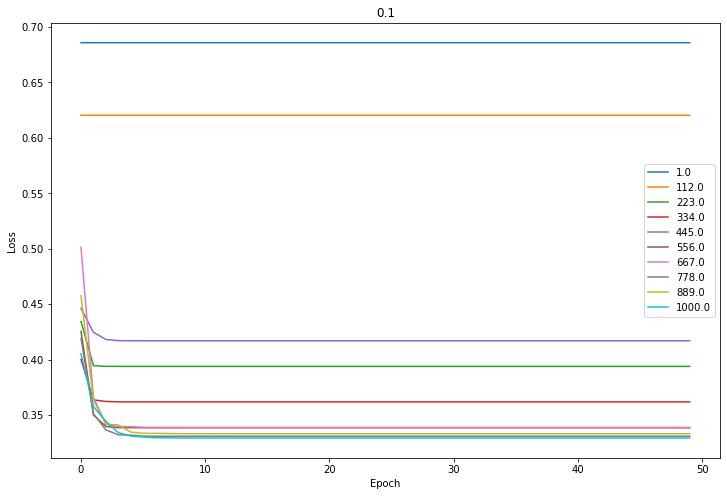

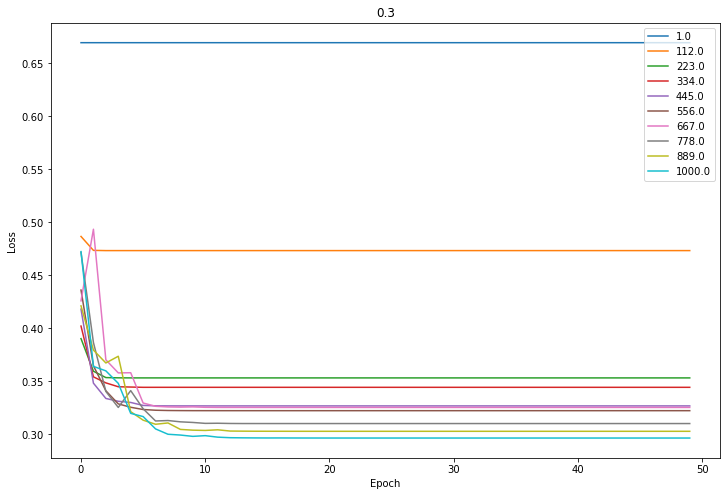

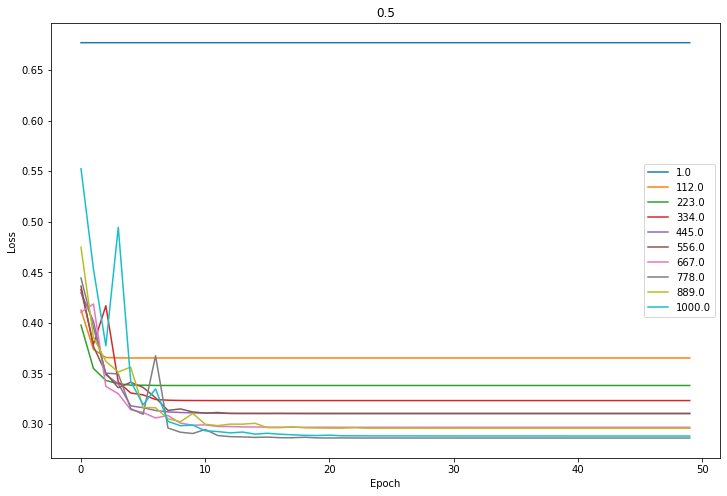

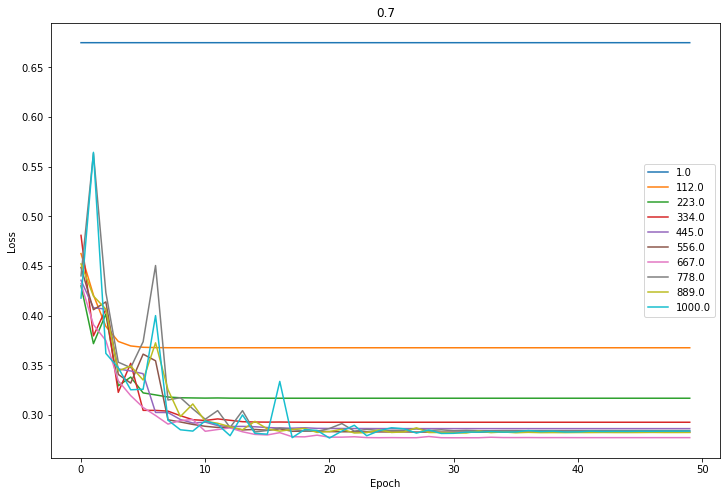

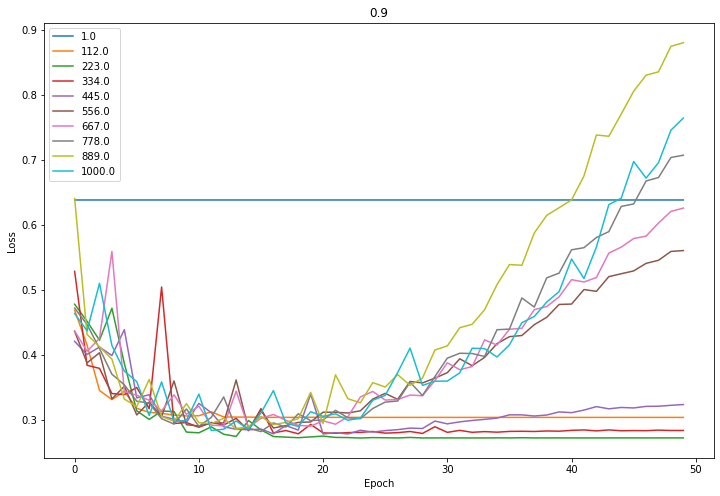

In [218]:
for i in lenet_lr_histories.keys():
    plt.figure(figsize=(12,8))
    plt.title(str(i))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    for j in lenet_lr_histories[i].keys():
        plt.plot(lenet_lr_histories[i][j].history["val_loss"], label=str(j))
    plt.legend()
    
    lrates = []
    losses = []
    accuracies = []
    auc = []
    f1_scores = []
    flipped_rotated = []
    combined = []
    none = []


    
    print("\nLearning Rate: %.2f"%i)
    for j in lenet_lr_histories[i].keys():
        lrates.append(j)
        losses.append(get_min_loss(lenet_lr_histories[i][j]))
        accuracies.append(get_max_accuracy(lenet_lr_histories[i][j].history))
        auc.append(get_max_auc(lenet_lr_histories[i][j].history))
        f1_scores.append(get_max_f1_score(lenet_lr_histories[i][j].history))
    
    metrics = {"Learning Rate": lrates,
               "Loss": losses,
               "Accuracy": accuracies,
               "AUC": auc,
               "F1-Score": f1_scores}
    metrics_df = pd.DataFrame(metrics)
    print(metrics_df)
    


Step size=250 (a rounded number nearest to 223.0), decay rate=0.9 is chosen as this minimises the loss function and provides the near-best f1-score of all hyperparameters tested.

### Data Augmentation
As with the Spatially-constrained model, data augmentation of a similar nature is performed and tested on the lenet-based model.

In [232]:
def create_augmentation_generator(horizontal_flip=False,
                                vertical_flip = False,
                                rotation_range=None,
                                width_shift_range=None,
                                height_shift_range=None,
                                brightness_range=None,
                                shear_range=0.0):
    train_augment_datagen = ImageDataGenerator(rescale=1./255,
                                               horizontal_flip=horizontal_flip,
                                               vertical_flip=vertical_flip,
                                               rotation_range=rotation_range,
                                               width_shift_range=width_shift_range,
                                               height_shift_range=height_shift_range,
                                               brightness_range=brightness_range,
                                               shear_range=shear_range,
                                               data_format='channels_last')
    val_augment_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

    batch_size = 32

    train_augment_generator = train_augment_datagen.flow_from_dataframe(
            dataframe=train_data,
            directory='./patch_images',
            x_col="ImageName",
            y_col="isCancerous",
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode='binary')

    validation_augment_generator = val_augment_datagen.flow_from_dataframe(
            dataframe=val_data,
            directory='./patch_images',
            x_col="ImageName",
            y_col="isCancerous",
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode='binary')
    
    return train_augment_generator, validation_augment_generator

def fit_augmentation(train_gen, val_gen, model):
    sc_lr = tf.keras.models.clone_model(model)

    sc_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=0.1,
                decay_steps=250,
                decay_rate=0.9,
                staircase=False)

    sc_lr.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=sc_lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

    return sc_lr.fit_generator(train_gen, validation_data = val_gen, epochs=50, verbose=0, callbacks=[cback])


augmentations = {'Flip': create_augmentation_generator(horizontal_flip=True, vertical_flip=True),
                'Rotate': create_augmentation_generator(rotation_range=90),
                'Translated': create_augmentation_generator(width_shift_range=27/2,
                                                            height_shift_range=27/2),
                'Brightness': create_augmentation_generator(brightness_range=(0.5,1.5)),
                'Shear': create_augmentation_generator(shear_range=90)}

lenet_augmentation_histories = {}
for i in augmentations.keys():
    lenet_augmentation_histories[i] = fit_augmentation(augmentations[i][0], augmentations[i][1], lenet_lr).history

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 0, 1,

In [233]:
def get_min_loss(history):
    return min(history["val_loss"])

def get_max_accuracy(history):
    return max(history["val_binary_accuracy"])

def get_max_auc(history):
    return max(history["val_auc"])

def get_max_f1_score(history):
    f1_scores = []
    for j in zip(history["val_precision"], history["val_recall"]):
        f1_scores.append(get_f1_score(j[0], j[1]))
    return max(f1_scores)


  Augmentation Feature      Loss  Accuracy       AUC  F1-Scores
0                 Flip  0.274047  0.890039  0.947110   0.837242
1               Rotate  0.284611  0.888314  0.942243   0.833700
2           Translated  0.319072  0.867604  0.931350   0.798801
3           Brightness  0.303315  0.877959  0.934648   0.820714
4                Shear  0.293304  0.883876  0.941006   0.819471


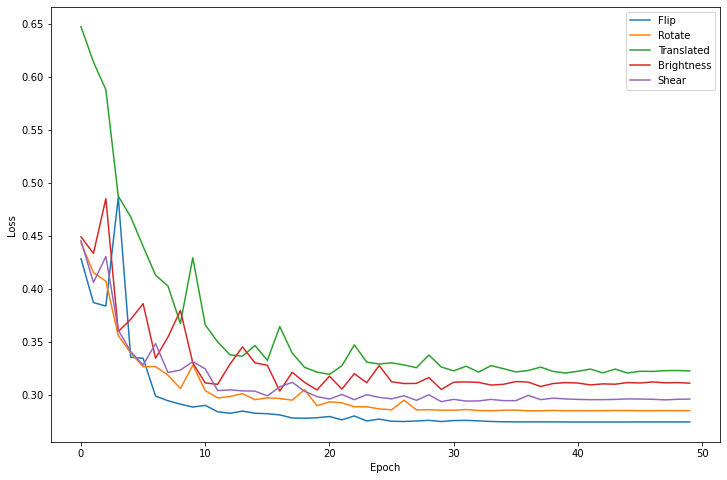

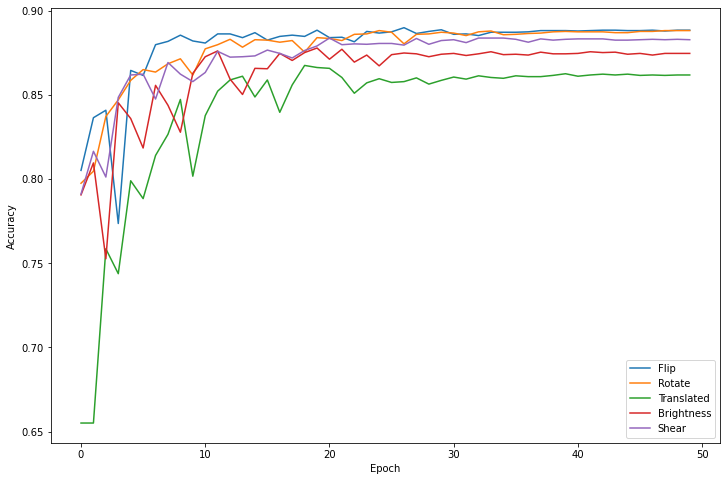

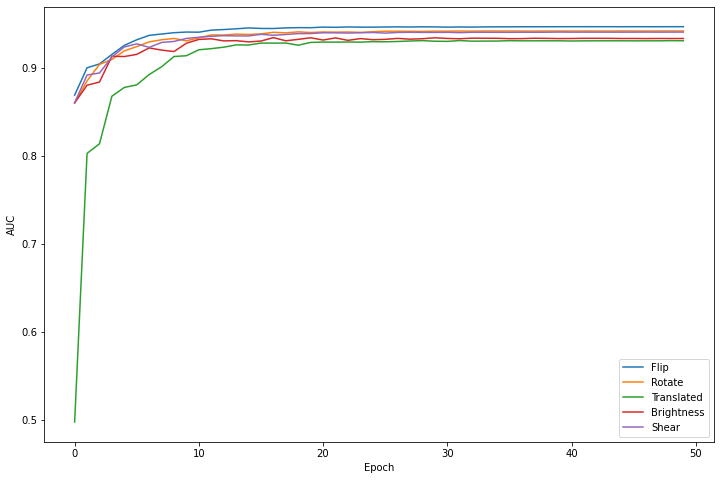

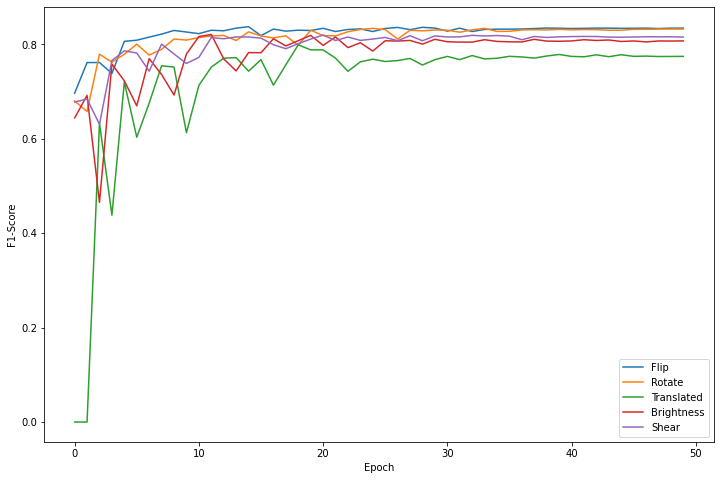

In [234]:
plot_validation_performance_curves(lenet_augmentation_histories)

operations = []
losses = []
accuracies = []
auc = []
f1_scores = []
flipped_rotated = []
combined = []
none = []

for i in lenet_augmentation_histories.keys():
    operations.append(i)
    losses.append(get_min_loss(lenet_augmentation_histories[i]))
    accuracies.append(get_max_accuracy(lenet_augmentation_histories[i]))
    auc.append(get_max_auc(lenet_augmentation_histories[i]))
    f1_scores.append(get_max_f1_score(lenet_augmentation_histories[i]))
    
metrics = {"Augmentation Feature": operations,
           "Loss": losses,
           "Accuracy": accuracies,
           "AUC": auc,
           "F1-Scores": f1_scores}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Of the operations performed for generating additional image data, flipping and rotating the images led to the lowest amount of loss and highest f1-scores. As a result, a combination of these two operations will be evaluated alongside no data augmentation and a combination of all tested augmentations.

In [235]:
flip_rotate_generator = create_augmentation_generator(horizontal_flip=True,
                      vertical_flip = True,
                      rotation_range=90,
                      width_shift_range=None,
                      height_shift_range=None,
                      brightness_range=None,
                      shear_range=None)

sc_augmentation_histories["Flipped and Rotated"] = fit_augmentation(flip_rotate_generator[0], flip_rotate_generator[1], lenet_lr).history

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

In [236]:
mix_generator = create_augmentation_generator(horizontal_flip=True,
                                vertical_flip = True,
                                rotation_range=90,
                                width_shift_range=27/2,
                                height_shift_range=27/2,
                                brightness_range=(0.5,1.5),
                                shear_range=90)
lenet_augmentation_histories["Combined"] = fit_augmentation(mix_generator[0], mix_generator[1], lenet_lr).history


Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

In [237]:

none_generator = create_augmentation_generator(horizontal_flip=False,
                                vertical_flip = False,
                                rotation_range=None,
                                width_shift_range=None,
                                height_shift_range=None,
                                brightness_range=None,
                                shear_range=None)
lenet_augmentation_histories["None"] = fit_augmentation(none_generator[0], none_generator[1], lenet_lr).history

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

It can be observed that combining all operations has lead to significant data loss and loss of feature identifiability. This will likely lead to subpar performance.

  Augmentation Feature      Loss  Accuracy       AUC  F1-Scores
0                 Flip  0.274047  0.890039  0.947110   0.837242
1               Rotate  0.284611  0.888314  0.942243   0.833700
2           Translated  0.319072  0.867604  0.931350   0.798801
3           Brightness  0.303315  0.877959  0.934648   0.820714
4                Shear  0.293304  0.883876  0.941006   0.819471
5             Combined  0.430123  0.798323  0.878863   0.646036
6                 None  0.282413  0.889300  0.944009   0.836299


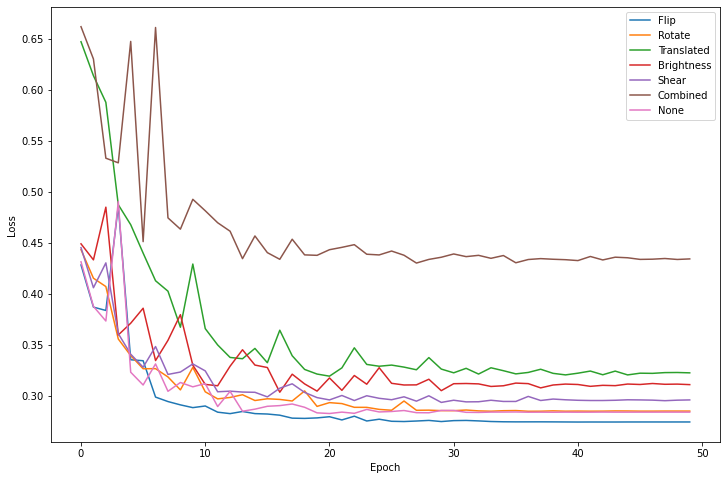

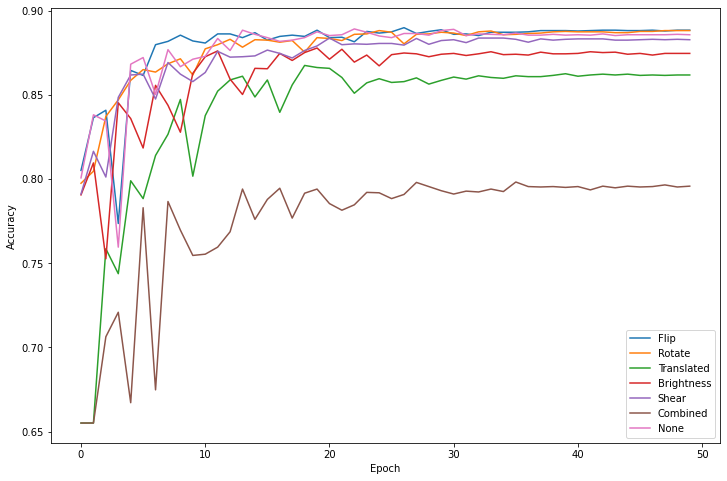

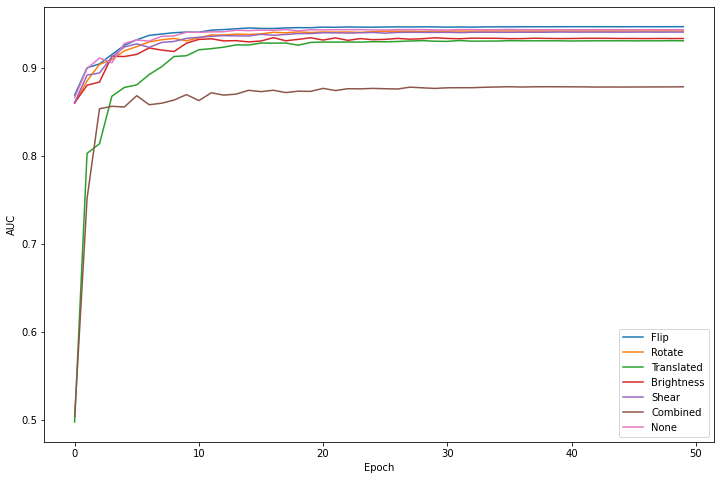

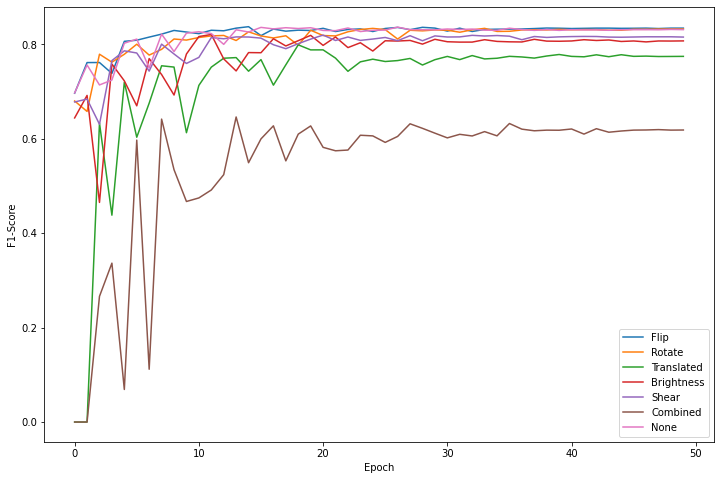

In [238]:
plot_validation_performance_curves(lenet_augmentation_histories)

operations = []
losses = []
accuracies = []
auc = []
f1_scores = []
for i in lenet_augmentation_histories.keys():
    operations.append(i)
    losses.append(get_min_loss(lenet_augmentation_histories[i]))
    accuracies.append(get_max_accuracy(lenet_augmentation_histories[i]))
    auc.append(get_max_auc(lenet_augmentation_histories[i]))
    f1_scores.append(get_max_f1_score(lenet_augmentation_histories[i]))
    
metrics = {"Augmentation Feature": operations, "Loss": losses, "Accuracy": accuracies, "AUC": auc, "F1-Scores": f1_scores}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

As expected, the performance of the model with all augmentation operations combined is relatively poor. It is also  observed that no data augmentation operations provide a significant increase in performance by any metric, and so data augmentation will not be used in conjunction with the spatially-constrained model.

## Evaluation and Final Judgement

### Evaluation
#### Comparing the performance of models with different hyperparameters

In [150]:
hyperparameters_lr = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1,
        decay_steps=250,
        decay_rate=0.9,
        staircase=True)

lenet_hyperparameters = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.ZeroPadding2D(padding=((2,3), (2,3))),

    tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation="relu"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lenet_hyperparameters.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hyperparameters_lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])
lenet_hyperparameters_history = lenet_hyperparameters.fit_generator(train_generator, validation_data = test_generator, epochs=150, verbose=0)


In [151]:
sc_hyperparameters = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    
    tf.keras.layers.Conv2D(filters=36, kernel_size=4, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

sc_hyperparameters.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hyperparameters_lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

sc_hyperparameters_history = sc_hyperparameters.fit_generator(train_generator, validation_data = test_generator, epochs=150, verbose=0, callbacks=[cback])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 

                          Name      Loss  Accuracy       AUC  F1-Scores
0                        Lenet  0.271097  0.893491  0.948979   0.843750
1        Spatially-constrained  0.263771  0.898422  0.951984   0.849635
2                  Lenet tuned  0.287740  0.887574  0.941927   0.832075
3  Spatially-constrained tuned  0.272344  0.894970  0.947964   0.841871


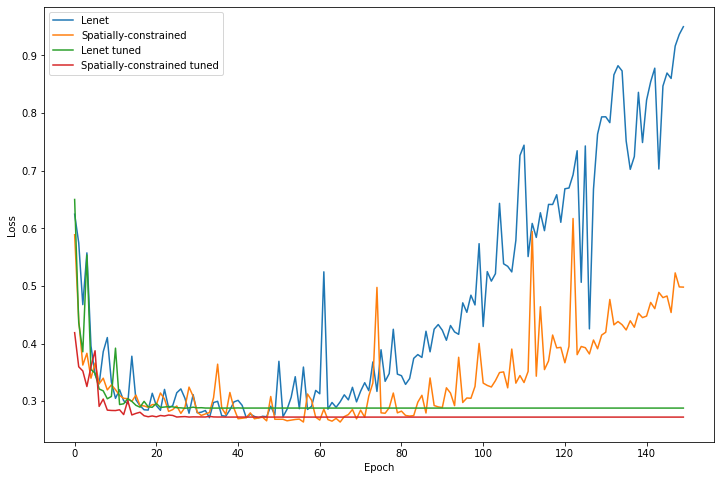

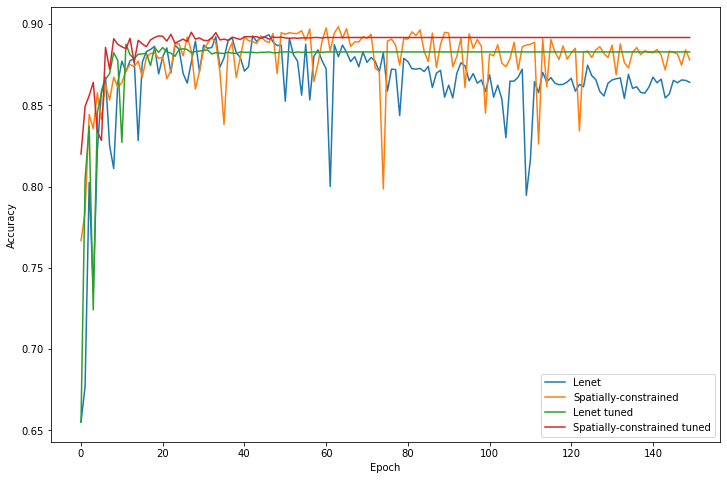

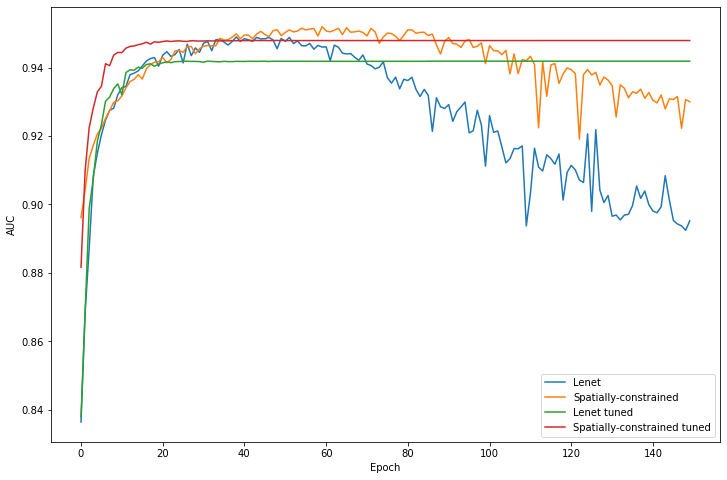

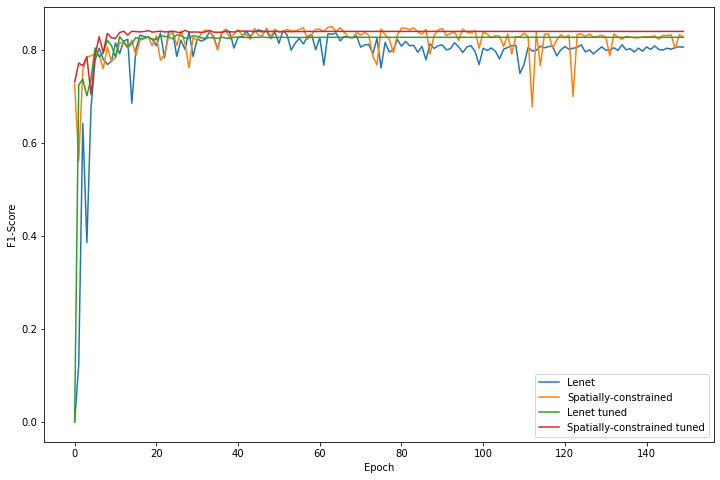

In [225]:
eval_histories = {"Lenet": lenet_history.history, "Spatially-constrained": sc_history.history,
                  "Lenet tuned": lenet_hyperparameters_history.history, "Spatially-constrained tuned": sc_hyperparameters_history.history}

plot_validation_performance_curves(eval_histories)

eval_histories = {"Lenet": lenet_history, "Spatially-constrained": sc_history,
                  "Lenet tuned": lenet_hyperparameters_history, "Spatially-constrained tuned": sc_hyperparameters_history}

names = []
losses = []
accuracies = []
auc = []
f1_scores = []

for i in eval_histories.keys():
    names.append(i)
    losses.append(get_min_loss(eval_histories[i]))
    accuracies.append(get_max_accuracy(eval_histories[i].history))
    auc.append(get_max_auc(eval_histories[i].history))
    f1_scores.append(get_max_f1_score(eval_histories[i].history))
    
metrics = {"Name": names,
           "Loss": losses,
           "Accuracy": accuracies,
           "AUC": auc,
           "F1-Scores": f1_scores}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

It can be observed that the spatially-constrained model performs best at maximum performance, but trails the tuned counterpart on average. If early stopping is used during training, then the untuned spatially-constrained model should be used. It's inconsistent performance is visible in the graphs, particularly it's loss function. Training can be stopped when the loss function begins to increase, however. While the untuned spatially-constrained model demonstrates higher maximum performance, the tuned spatially-constrained model performs better when early stopping is used.

Because it demonstrated the highest maximum F1-score (unlike it's tuned counterpart), it is our judgement that the spatially-constrained model with early stopping during training should be used for this classication task. Early stopping will prevent further training when the loss function begins to diverge. Reducing the learning rate on the other hand had the effect of decreasing the variability of the loss function and lead to more reliably high performance for classification across the validation and test datasets. When a more reliable level of classification performance is desired, it may be well advised to use the tuned model which prevents the loss function from diverging during training.

The spatially constrained model suggested is described in the graph below and is the same as that presented by Sirinukunwattana et. al in their paper (2016).

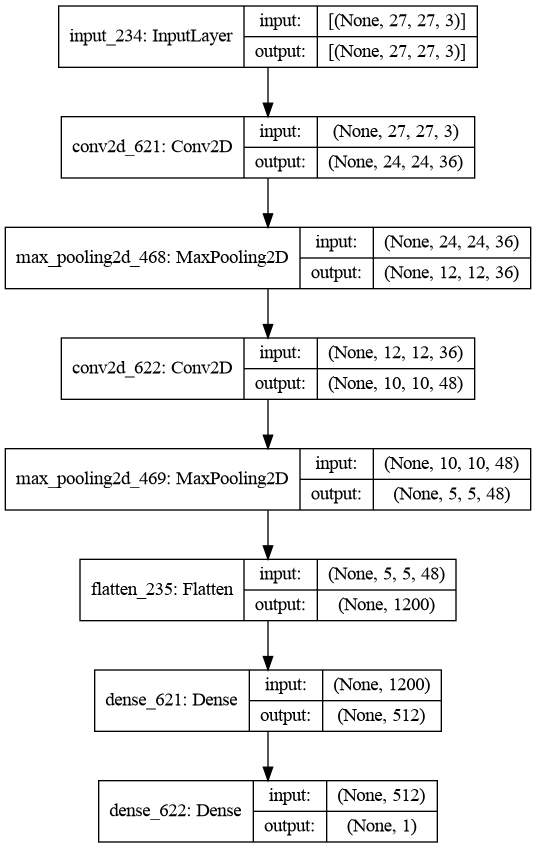

In [227]:
tf.keras.utils.plot_model(sc_softmax, show_shapes=True)

# Model Development - Cell Type Classification

In [3]:
data = pd.read_csv('./data_labels_mainData.csv')

In [4]:
data

InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0          22405          1  22405.png   fibroblast         0            0
1          22406          1  22406.png   fibroblast         0            0
2          22407          1  22407.png   fibroblast         0            0
3          22408          1  22408.png   fibroblast         0            0
4          22409          1  22409.png   fibroblast         0            0
...          ...        ...        ...          ...       ...          ...
9891        1625         60   1625.png   epithelial         2            1
9892        1626         60   1626.png   epithelial         2            1
9893        1627         60   1627.png   epithelial         2            1
9894        1628         60   1628.png   epithelial         2            1
9895        1629         60   1629.png   epithelial         2            1

[9896 rows x 6 columns]

# Strategy
 - Transfer Learning - we will be using the best model that was tuned from cancerous classification and further tune parameters for the task of classifying cell types
 - Then we will try other models from research papers, tune them and compare them all to evaluate and choose the best one
 - From EDA, it was found that epithelial is most important to classify, because we want to know if patients have cancer
 - Weight averaged F1-score is important to assess the performance of only classifying epthelial cells
 - Macro average F1-score is important to assess the performance of classifying all cell types
 - There is a class imbalance so it's expected that there will be a higher weighted average than macro

In [5]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)

In [6]:
INPUT_DIM = (27,27,3)

In [7]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')
test_data['cellType'] = test_data['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range = 90)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 128

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

batch_size = 1
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


# Transfer Learning

In [8]:
class ProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(epoch, end=", ")

cback = ProgressCallback()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [9]:
def learning_scheduler(epoch, lr):
    if epoch>10:
        return lr
    else:
        return lr*tf.math.exp(-0.005)
        
learning_schedule = tf.keras.callbacks.LearningRateScheduler(learning_scheduler, verbose=0)

In [10]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [11]:
def get_max_f1_score(history):
    max_f1 = 0
    for i in range(len(history.history['loss'])):
        recall = history.history['val_recall'][i]
        precision = history.history['val_precision'][i]
        try:
            f1_score = 2*((precision*recall)/(precision+recall))
            if f1_score>max_f1:
                max_f1 = f1_score
        except:
            pass
    return max_f1



First we will try all the different optimizers with the optimal regularization parameters

Adadelta


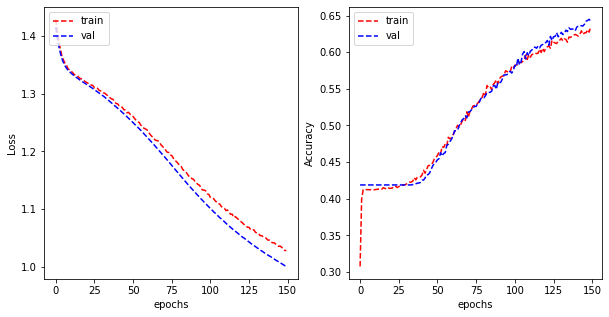

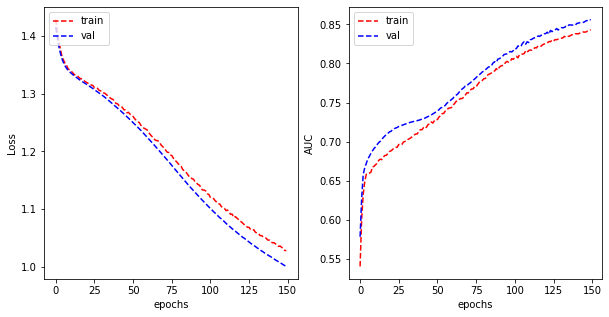

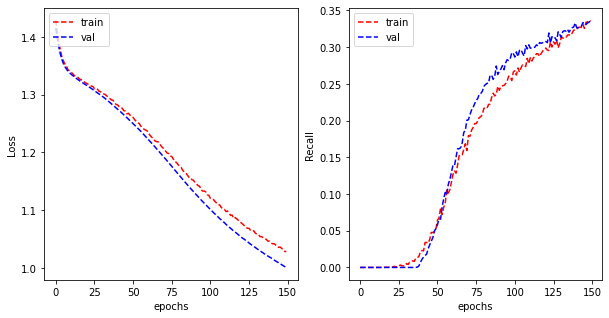

Validation F1-Score: 0.48034620221015334

Test Scores: 
              precision    recall  f1-score   support

           0       0.63      0.36      0.46       372
           1       0.52      0.70      0.59       504
           2       0.69      0.94      0.80       803
           3       0.00      0.00      0.00       301

    accuracy                           0.63      1980
   macro avg       0.46      0.50      0.46      1980
weighted avg       0.53      0.63      0.56      1980

[[134 140  98   0]
 [  9 351 144   0]
 [  1  47 755   0]
 [ 70 140  91   0]]
____________________________________________________________________________________________________
Adagrad


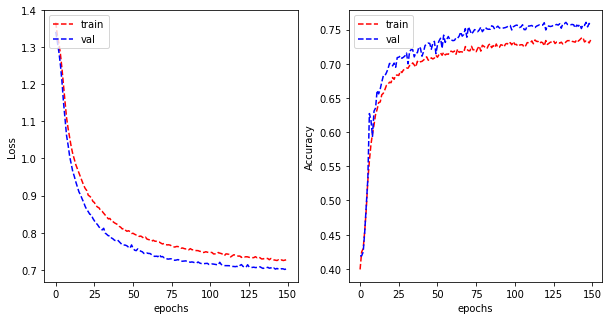

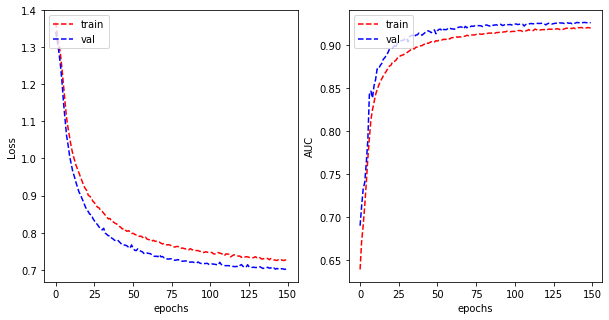

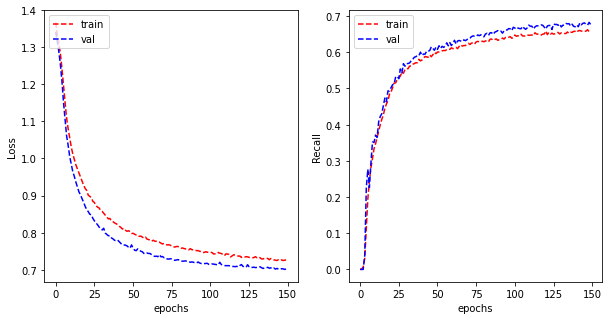

Validation F1-Score: 0.7453793248475082

Test Scores: 
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       372
           1       0.64      0.82      0.72       504
           2       0.81      0.92      0.86       803
           3       0.60      0.17      0.26       301

    accuracy                           0.72      1980
   macro avg       0.67      0.62      0.61      1980
weighted avg       0.70      0.72      0.69      1980

[[220  51  78  23]
 [ 35 411  48  10]
 [ 10  57 735   1]
 [ 86 123  41  51]]
____________________________________________________________________________________________________
Adam


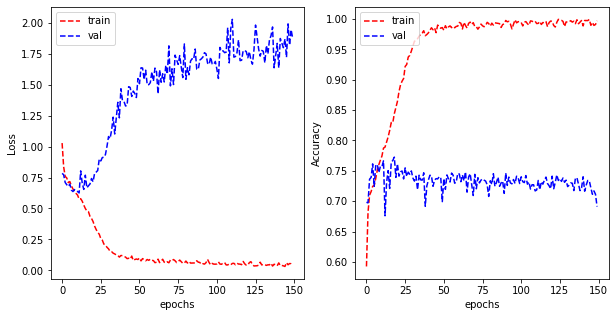

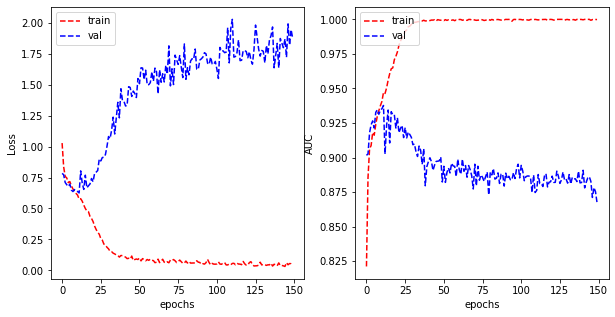

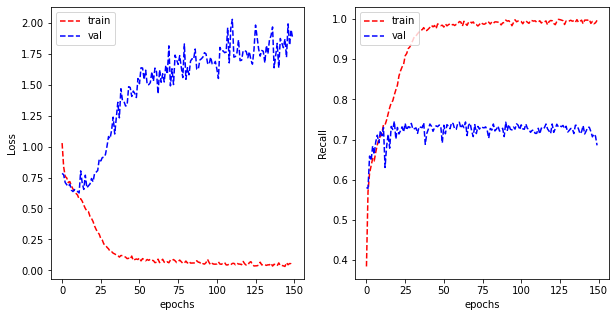

Validation F1-Score: 0.7696404626058133

Test Scores: 
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       372
           1       0.64      0.73      0.68       504
           2       0.89      0.71      0.79       803
           3       0.44      0.45      0.44       301

    accuracy                           0.67      1980
   macro avg       0.63      0.64      0.63      1980
weighted avg       0.69      0.67      0.68      1980

[[252  33  28  59]
 [ 43 366  22  73]
 [101  88 574  40]
 [ 56  88  23 134]]
____________________________________________________________________________________________________
Adamax


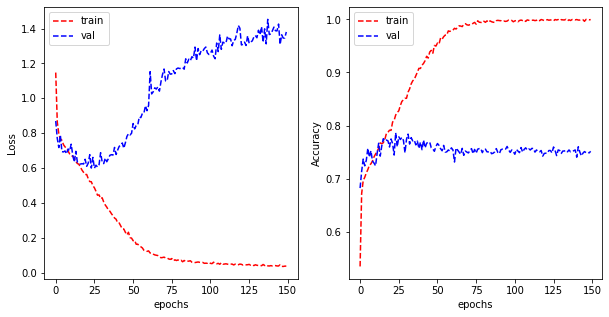

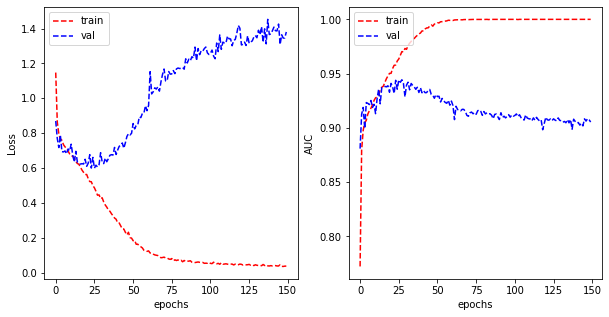

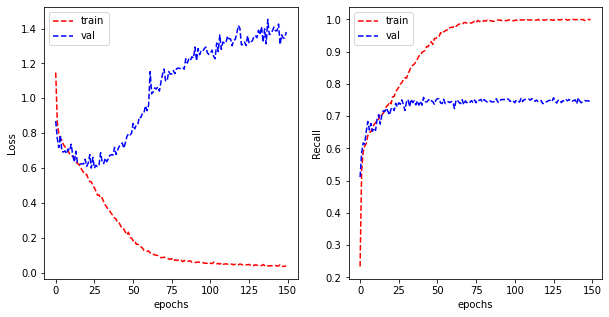

Validation F1-Score: 0.7807570996518046

Test Scores: 
              precision    recall  f1-score   support

           0       0.63      0.73      0.68       372
           1       0.72      0.74      0.73       504
           2       0.84      0.89      0.86       803
           3       0.59      0.37      0.45       301

    accuracy                           0.74      1980
   macro avg       0.70      0.68      0.68      1980
weighted avg       0.73      0.74      0.73      1980

[[271  17  56  28]
 [ 49 373  46  36]
 [ 30  48 712  13]
 [ 77  77  37 110]]
____________________________________________________________________________________________________
Ftrl


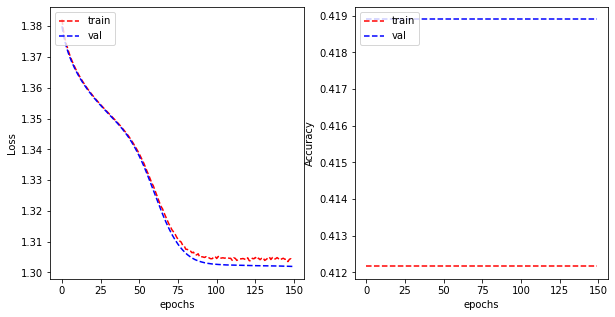

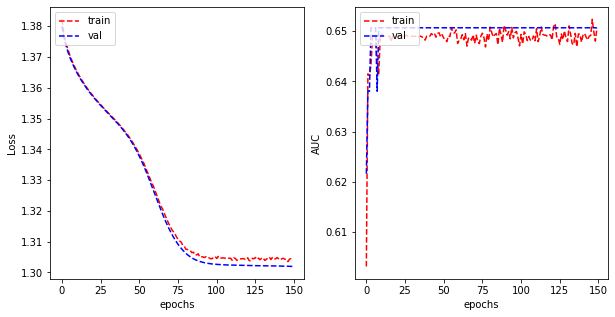

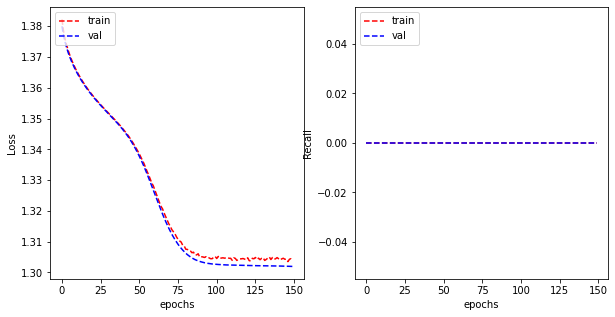

Validation F1-Score: 0

Test Scores: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       372
           1       0.00      0.00      0.00       504
           2       0.41      1.00      0.58       803
           3       0.00      0.00      0.00       301

    accuracy                           0.41      1980
   macro avg       0.10      0.25      0.14      1980
weighted avg       0.16      0.41      0.23      1980

[[  0   0 372   0]
 [  0   0 504   0]
 [  0   0 803   0]
 [  0   0 301   0]]
____________________________________________________________________________________________________
Nadam


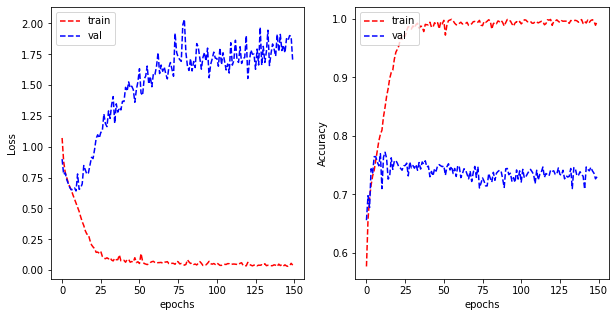

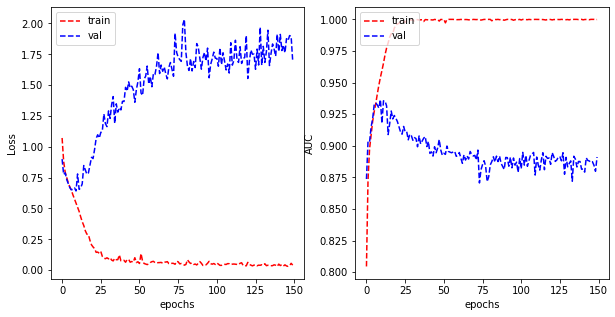

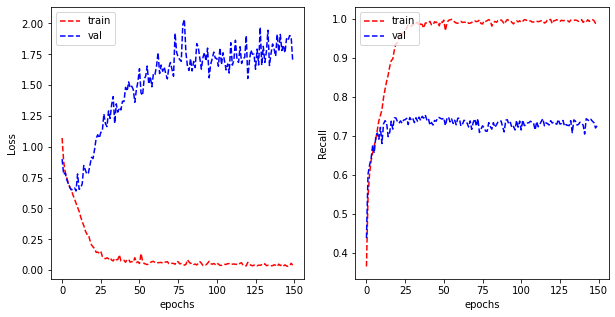

Validation F1-Score: 0.7689881806455672

Test Scores: 
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       372
           1       0.67      0.71      0.69       504
           2       0.84      0.86      0.85       803
           3       0.46      0.41      0.43       301

    accuracy                           0.71      1980
   macro avg       0.66      0.65      0.65      1980
weighted avg       0.70      0.71      0.71      1980

[[230  34  58  50]
 [ 34 359  36  75]
 [ 34  58 694  17]
 [ 57  87  34 123]]
____________________________________________________________________________________________________
RMSprop


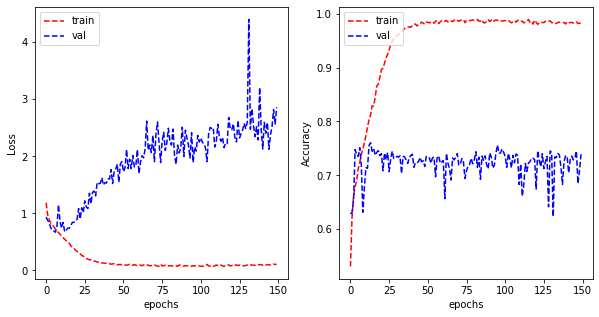

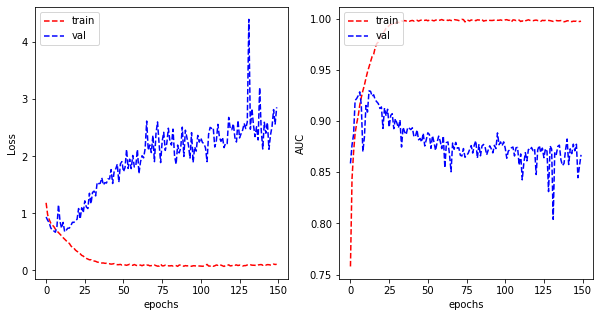

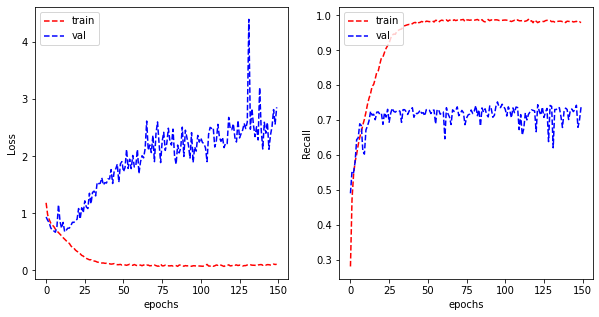

Validation F1-Score: 0.7577836565098275

Test Scores: 
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       372
           1       0.69      0.76      0.73       504
           2       0.84      0.86      0.85       803
           3       0.52      0.38      0.44       301

    accuracy                           0.73      1980
   macro avg       0.68      0.67      0.67      1980
weighted avg       0.72      0.73      0.72      1980

[[248  31  56  37]
 [ 34 385  39  46]
 [ 35  55 692  21]
 [ 60  86  41 114]]
____________________________________________________________________________________________________
SGD


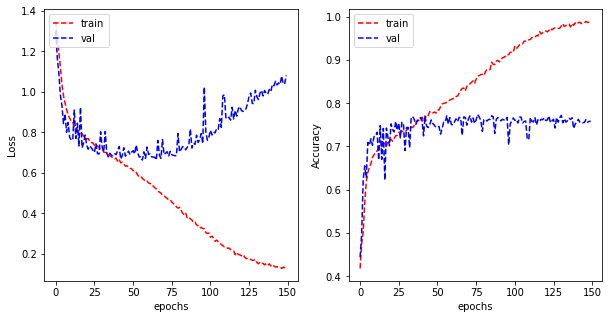

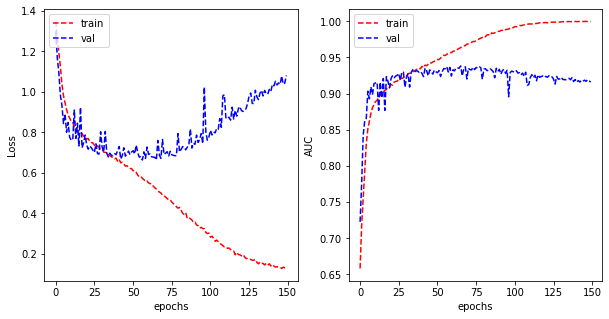

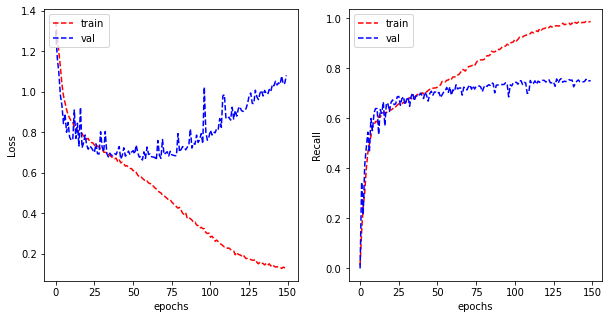

Validation F1-Score: 0.7689549192474903

Test Scores: 
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       372
           1       0.69      0.79      0.74       504
           2       0.82      0.91      0.86       803
           3       0.64      0.34      0.44       301

    accuracy                           0.75      1980
   macro avg       0.71      0.68      0.68      1980
weighted avg       0.74      0.75      0.73      1980

[[252  32  66  22]
 [ 31 400  48  25]
 [ 18  48 727  10]
 [ 59  97  43 102]]
____________________________________________________________________________________________________


In [13]:
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Ftrl', 'Nadam', 'RMSprop', 'SGD']
for optimizer_ in optimizers:
    print(optimizer_)
    
    base_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=INPUT_DIM),

        tf.keras.layers.Conv2D(filters=36, kernel_size=4, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation='softmax'),
    ])

    
    base_model.compile(optimizer=optimizer_,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

    base_model_history = base_model.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)



    history = base_model_history

    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                        metric_name='Accuracy', )


    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['auc'], history.history['val_auc'],
                        metric_name='AUC')

    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['recall'], history.history['val_recall'],
                        metric_name='Recall')

    print("Validation F1-Score: " + str(get_max_f1_score(base_model_history)))

    print()

    print("Test Scores: ")



    scores = base_model.evaluate_generator(test_generator)
    y_pred = base_model.predict(test_generator)

    # Code taken from Ruwan's troubleshooting post
    # setup data some placeholders
    batch_size_ = 1
    y_hat_all = list()
    y_all = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            y_hat = base_model.predict(x, verbose=0)
            y_hat = np.argmax(y_hat, axis = 1)
            y = np.argmax(y, axis = 1)
            y_hat_all = y_hat_all + y_hat.tolist()
            y_all = y_all + y.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break

    print(classification_report(y_all,y_hat_all))
    print(confusion_matrix(y_all, y_hat_all))


    
    print("____________________________________________________________________________________________________")

**Observations:**
 - Adadelta:
     - Seems to be underfitting, more epochs will be necessary to train it properly and assess
     - F1-Score for epithelial cells is 0.8 which is good, but the F1-Score for other cell types is poor, and is 0 for "Others" 
 - Adagrad: 
     - As with Adadelta, more epochs will be necessary to prevent underfitting
     - Overall better performance over Adadelta, with F1-Score of 0.86 for epithelial cells, and higher F1-Scores for all other cell types, but still not adequate.
 - Adam 
     - Too many epochs, the model seems to be overfitting. The number of epochs need to be reduced. 
     - Performance on test data yields a better overall macro-average, so it's classifying all cell types better than Adagrad, however the F1-Score for epithelial cells is significantly lower than Adagrad
 - Adamax
     - As with Adam, the number of epochs need to be reduced to prevent overfitting.
     - F1-Score for epithelial cells is on par with Adagrad, and the macro-average is the best so far, with moderately better F1-Scores for inflammatory and fibroblast cells
 - Ftrl
     - Worst performing, classifying all cell types as epithelial. 
     - Will be removed for the next set of runs
 - Nadam
     - Overfitting, number of epochs need to be reduced. 
     - Moderate performance, but not better than Adamax
 - RMSprop
     - Overfitting, number of epochs need to be reduced. 
     - Performance almost on par with Adamax
 - SGD
     - Overfitting, number of epochs need to be reduced. 
     - Performance is as good as Adaman
     

From the observations above, FTRL was removed as an optimizer, and the number of epochs for each optimizer was adjusted.

Adadelta


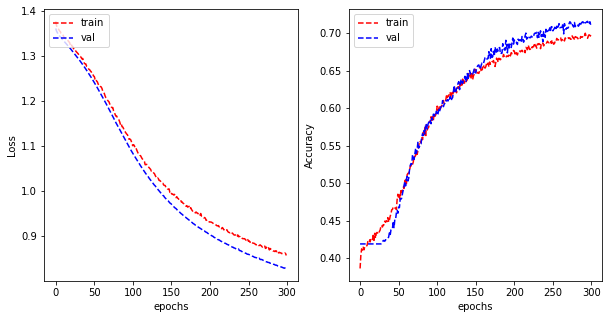

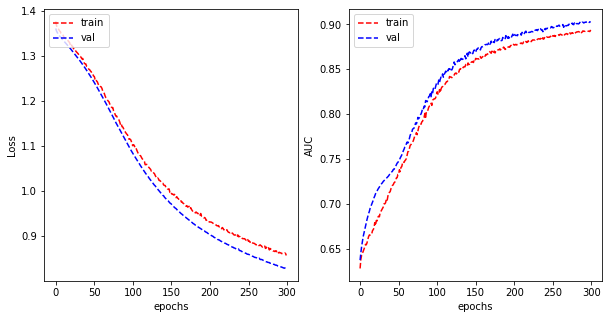

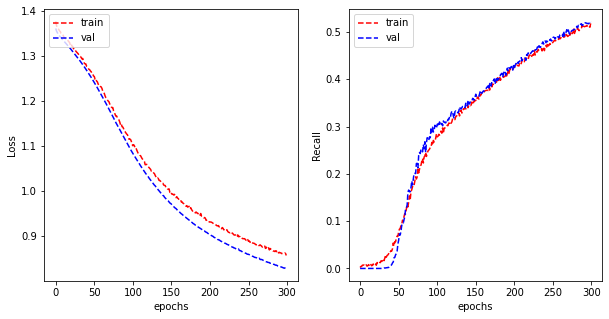

Validation F1-Score: 0.6404459470661883

Test Scores: 
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       372
           1       0.61      0.80      0.69       504
           2       0.77      0.93      0.84       803
           3       1.00      0.02      0.05       301

    accuracy                           0.69      1980
   macro avg       0.74      0.58      0.54      1980
weighted avg       0.73      0.69      0.63      1980

[[206  77  89   0]
 [ 27 402  75   0]
 [  2  56 745   0]
 [115 124  55   7]]
____________________________________________________________________________________________________
Adagrad


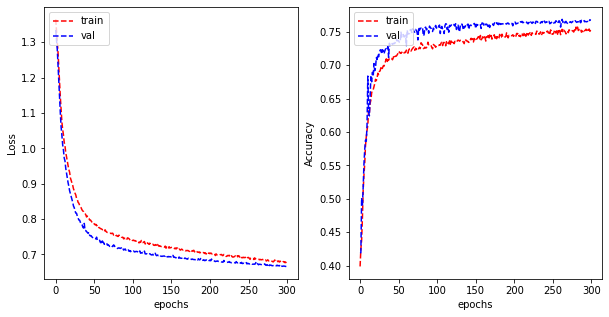

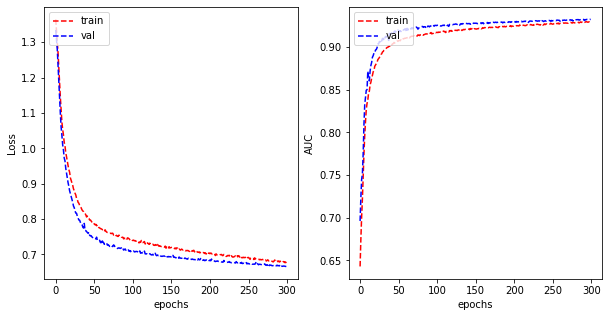

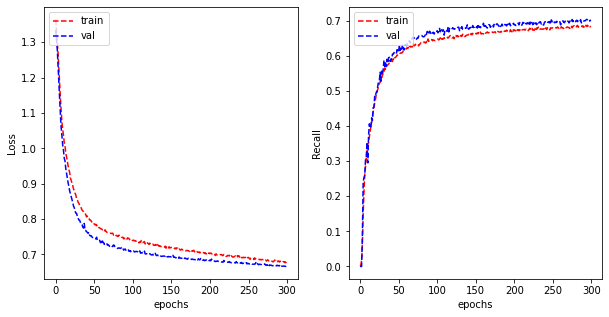

Validation F1-Score: 0.7569331087946404

Test Scores: 
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       372
           1       0.66      0.82      0.73       504
           2       0.83      0.92      0.87       803
           3       0.67      0.21      0.31       301

    accuracy                           0.74      1980
   macro avg       0.70      0.65      0.64      1980
weighted avg       0.73      0.74      0.71      1980

[[244  47  65  16]
 [ 31 413  45  15]
 [ 13  49 741   0]
 [ 84 114  41  62]]
____________________________________________________________________________________________________
Adam


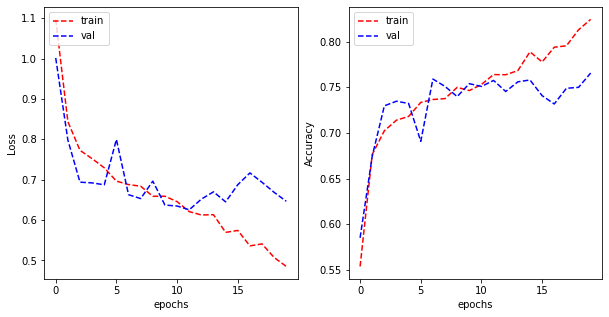

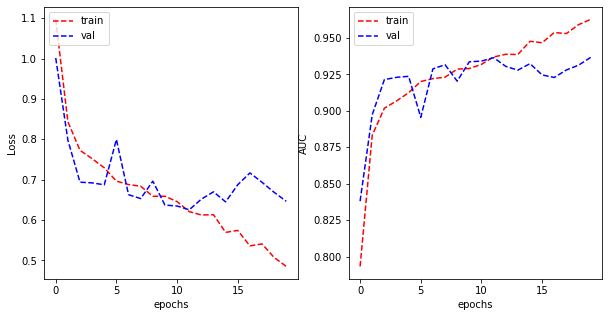

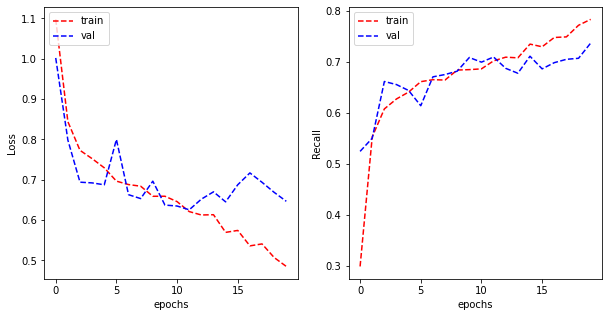

Validation F1-Score: 0.7681770137239677

Test Scores: 
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       372
           1       0.68      0.82      0.74       504
           2       0.85      0.90      0.87       803
           3       0.63      0.38      0.47       301

    accuracy                           0.75      1980
   macro avg       0.72      0.69      0.69      1980
weighted avg       0.75      0.75      0.74      1980

[[244  36  63  29]
 [ 37 413  28  26]
 [ 21  51 719  12]
 [ 46 106  36 113]]
____________________________________________________________________________________________________
Adamax


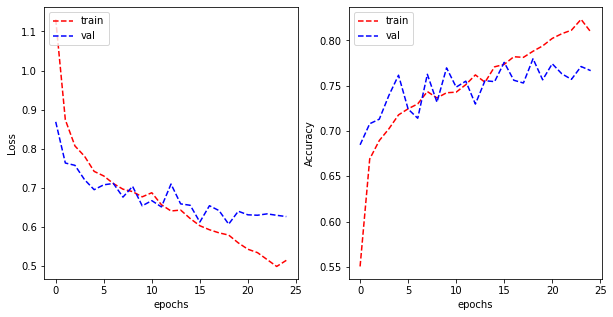

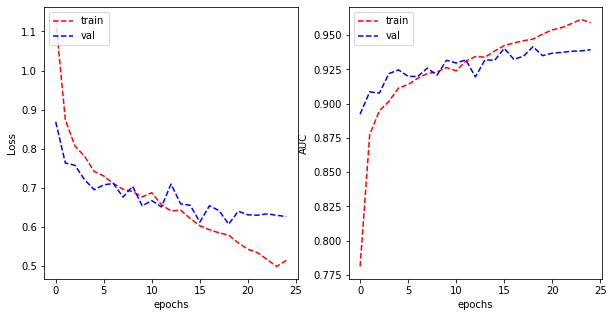

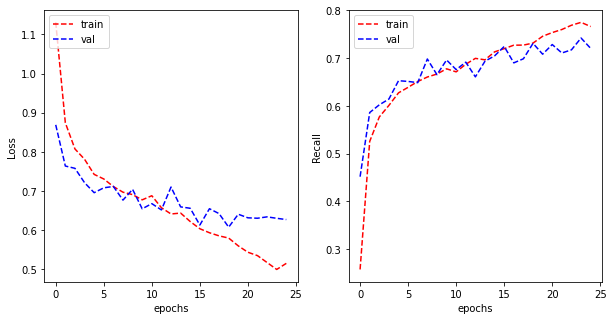

Validation F1-Score: 0.7746252957363977

Test Scores: 
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       372
           1       0.74      0.75      0.75       504
           2       0.81      0.94      0.87       803
           3       0.72      0.24      0.35       301

    accuracy                           0.75      1980
   macro avg       0.72      0.67      0.66      1980
weighted avg       0.74      0.75      0.72      1980

[[274  19  70   9]
 [ 52 377  58  17]
 [ 17  29 755   2]
 [102  82  46  71]]
____________________________________________________________________________________________________
Nadam


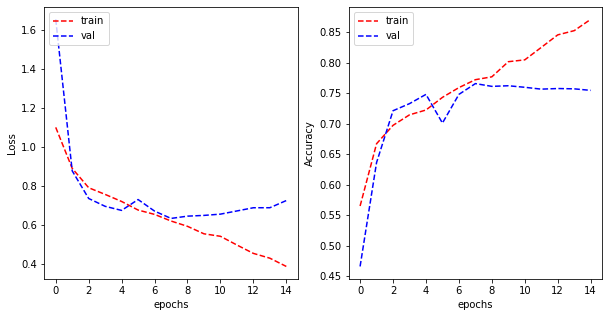

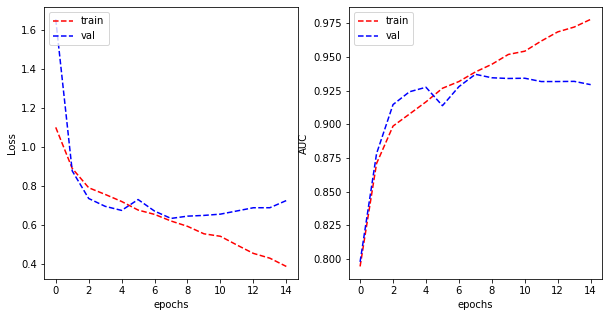

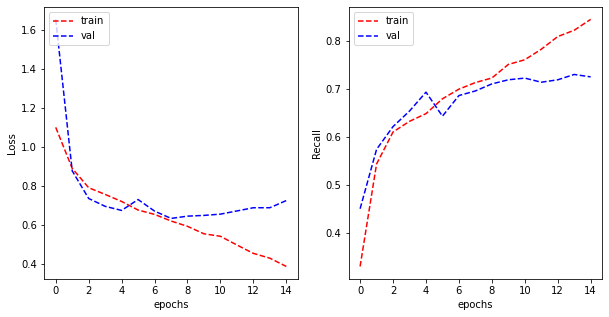

Validation F1-Score: 0.7619047549203767

Test Scores: 
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       372
           1       0.73      0.72      0.72       504
           2       0.79      0.94      0.86       803
           3       0.59      0.32      0.41       301

    accuracy                           0.74      1980
   macro avg       0.70      0.66      0.67      1980
weighted avg       0.72      0.74      0.72      1980

[[247  25  81  19]
 [ 28 364  73  39]
 [  9  32 755   7]
 [ 74  80  52  95]]
____________________________________________________________________________________________________
RMSprop


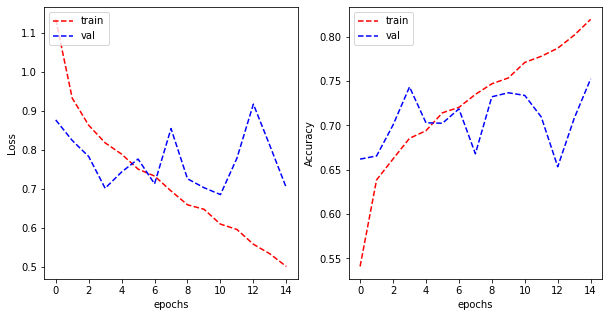

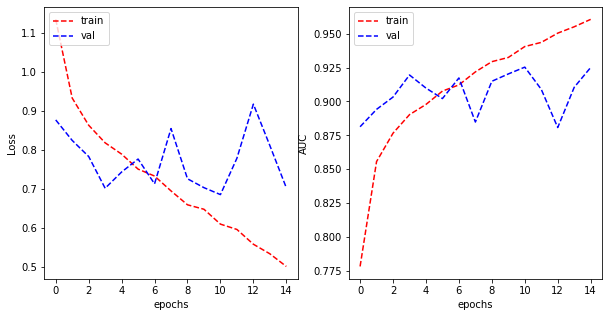

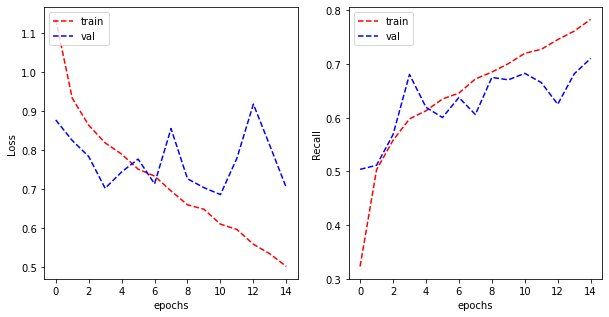

Validation F1-Score: 0.7476734844047427

Test Scores: 
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       372
           1       0.66      0.83      0.74       504
           2       0.85      0.86      0.86       803
           3       0.57      0.49      0.53       301

    accuracy                           0.75      1980
   macro avg       0.72      0.69      0.70      1980
weighted avg       0.75      0.75      0.74      1980

[[218  39  77  38]
 [ 16 418  20  50]
 [ 13  75 694  21]
 [ 33  97  25 146]]
____________________________________________________________________________________________________
SGD


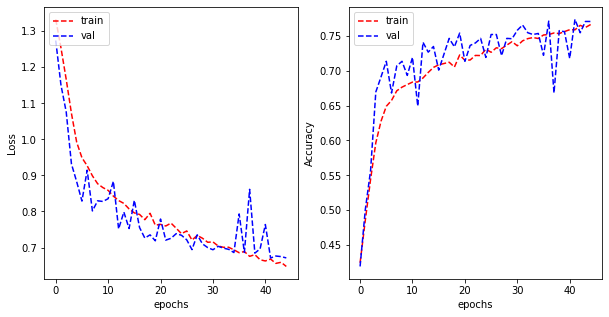

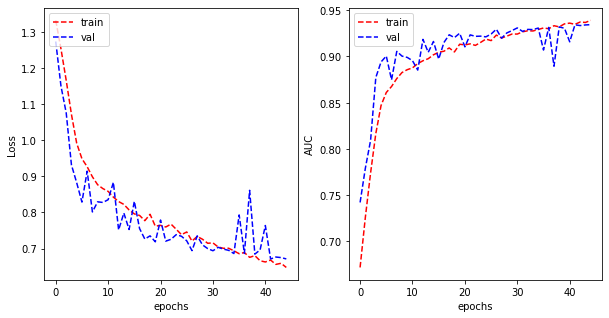

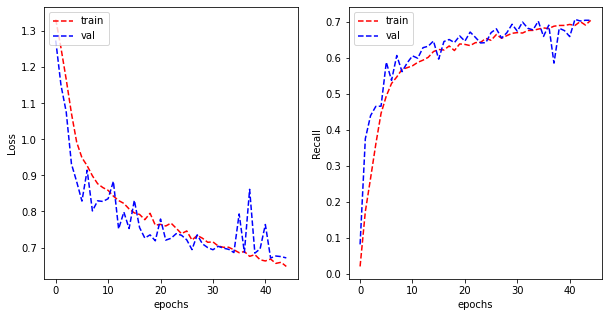

Validation F1-Score: 0.7593495974603851

Test Scores: 
              precision    recall  f1-score   support

           0       0.74      0.57      0.64       372
           1       0.66      0.84      0.74       504
           2       0.84      0.91      0.87       803
           3       0.55      0.35      0.43       301

    accuracy                           0.74      1980
   macro avg       0.70      0.67      0.67      1980
weighted avg       0.73      0.74      0.73      1980

[[211  48  64  49]
 [ 18 423  37  26]
 [  6  60 727  10]
 [ 50 107  38 106]]
____________________________________________________________________________________________________


In [14]:
optimizer_epochs = {'Adadelta': 300, 'Adagrad': 300, 'Adam':20, 'Adamax':25, 'Nadam': 15, 'RMSprop': 15, 'SGD': 45}
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'Adamax',  'Nadam', 'RMSprop', 'SGD']
for optimizer_ in optimizers:
    print(optimizer_)
    
    base_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=INPUT_DIM),

        tf.keras.layers.Conv2D(filters=36, kernel_size=4, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation='softmax'),
    ])

    
    base_model.compile(optimizer=optimizer_,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

    base_model_history = base_model.fit_generator(train_generator, validation_data = validation_generator, epochs=optimizer_epochs[optimizer_], verbose=0)



    history = base_model_history

    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                        metric_name='Accuracy', )


    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['auc'], history.history['val_auc'],
                        metric_name='AUC')

    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['recall'], history.history['val_recall'],
                        metric_name='Recall')

    print("Validation F1-Score: " + str(get_max_f1_score(base_model_history)))

    print()

    print("Test Scores: ")


    scores = base_model.evaluate_generator(test_generator)
    y_pred = base_model.predict(test_generator)

    # Code taken from Ruwan's troubleshooting post
    # setup data some placeholders
    batch_size_ = 1
    y_hat_all = list()
    y_all = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            y_hat = base_model.predict(x, verbose=0)
            y_hat = np.argmax(y_hat, axis = 1)
            y = np.argmax(y, axis = 1)
            y_hat_all = y_hat_all + y_hat.tolist()
            y_all = y_all + y.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break

    print(classification_report(y_all,y_hat_all))
    print(confusion_matrix(y_all, y_hat_all))


    
    print("____________________________________________________________________________________________________")

**Observations:**
 - Adadelta:
     - Still seems to be underfitting, more epochs will need to be added
     - F1-Score for epithelial cells is 0.84 which is better than the previous iteration, but the F1-Score for other cell types is still poor, and is 0.05 for "Others" 
 - Adagrad: 
     - As with Adadelta, still seems to be underftting, and more epochs will be necessary
     - The extra epochs do result in a better F1-Score overall for all cell types 
 - Adam 
     - There are still too many epochs, the model is slightly overfitting 
     - Performance is significantly better than previous iteration, with a much better macro average and weighted average. 
 - Adamax
     - There are slightly more epochs than necessary, and the model is slightly overfitting
     - The F1-Score for "Others" is signifcantly lower, from 0.45 to 0.35, while the F1-Scores for the others almost about the same
 - Nadam
     - There are still too many epochs, the model is slightly overfitting 
     - Performance is better overall, only slightly worse for "Others"
 - RMSprop
     - There are still too many epochs, the model is slightly overfitting 
     - Best performing so far, with the largest F1-Score for all cell types. 
 - SGD
     - Seems to be the best fit model
     - Performance is unchanged. 
     

Added padding to the CONV2D layers - the number of epochs has to increase for this

Reduced the number of optimizers for consideration

Adam


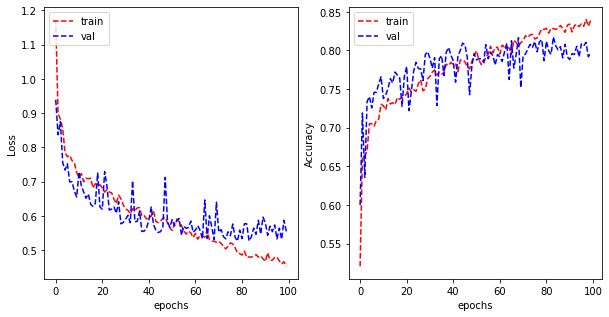

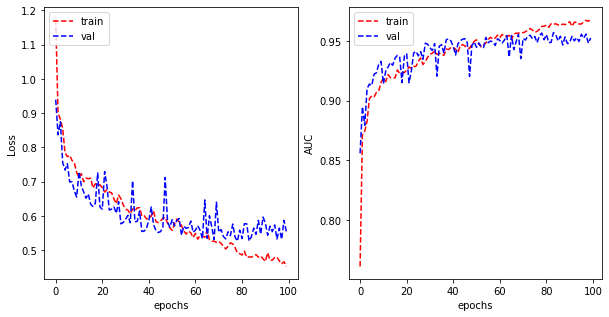

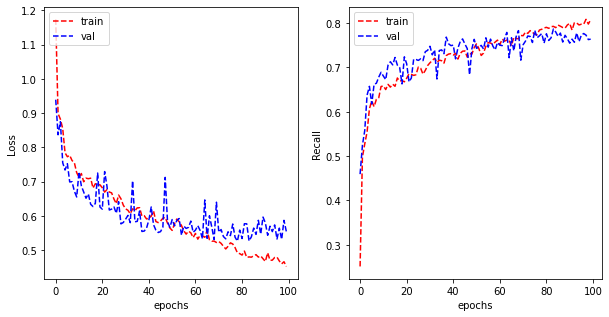

Validation F1-Score: 0.8134796121276087

Test Scores: 
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       372
           1       0.72      0.85      0.78       504
           2       0.91      0.88      0.89       803
           3       0.63      0.58      0.60       301

    accuracy                           0.79      1980
   macro avg       0.76      0.76      0.76      1980
weighted avg       0.80      0.79      0.79      1980

[[267  35  36  34]
 [ 18 427  15  44]
 [ 21  53 706  23]
 [ 28  80  19 174]]
____________________________________________________________________________________________________
Adamax


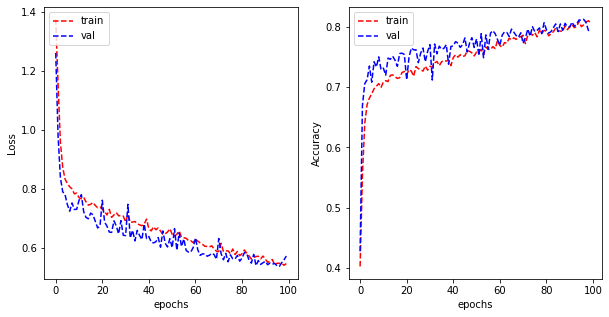

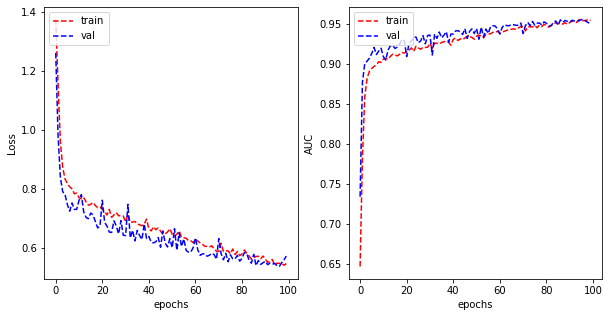

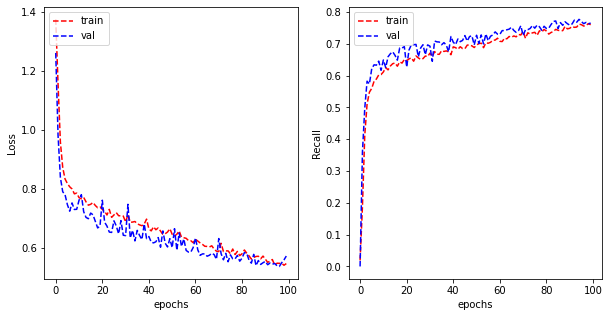

Validation F1-Score: 0.8073490757539094

Test Scores: 
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       372
           1       0.67      0.90      0.77       504
           2       0.90      0.89      0.89       803
           3       0.71      0.40      0.51       301

    accuracy                           0.78      1980
   macro avg       0.76      0.72      0.72      1980
weighted avg       0.79      0.78      0.77      1980

[[258  37  41  36]
 [ 23 455  15  11]
 [ 15  75 712   1]
 [ 42 116  24 119]]
____________________________________________________________________________________________________
Nadam


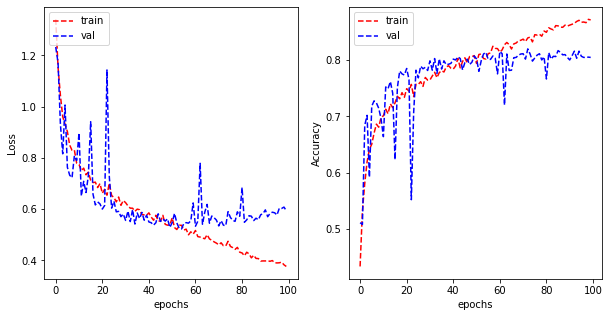

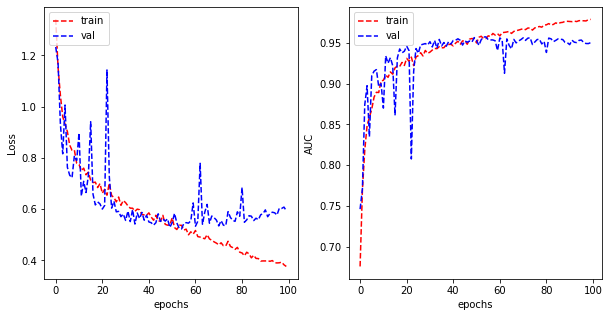

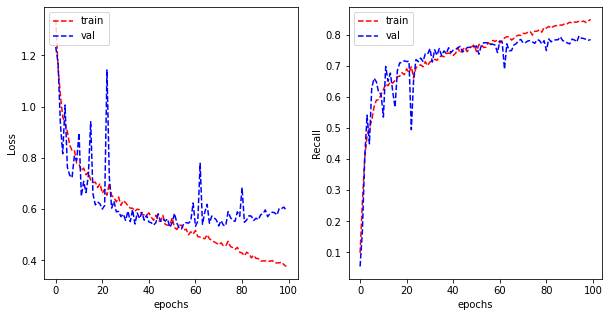

Validation F1-Score: 0.8141638480720699

Test Scores: 
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       372
           1       0.72      0.85      0.78       504
           2       0.92      0.87      0.90       803
           3       0.64      0.55      0.59       301

    accuracy                           0.79      1980
   macro avg       0.76      0.75      0.75      1980
weighted avg       0.79      0.79      0.79      1980

[[274  26  29  43]
 [ 30 428  14  32]
 [ 30  56 701  16]
 [ 38  81  17 165]]
____________________________________________________________________________________________________
RMSprop


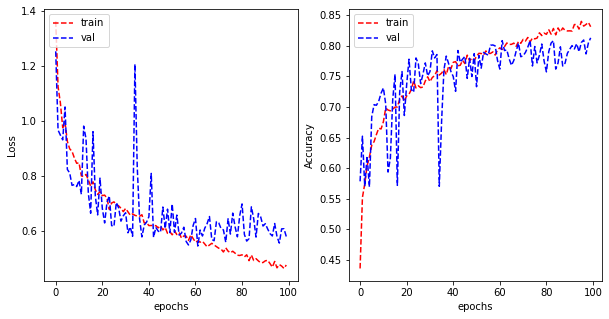

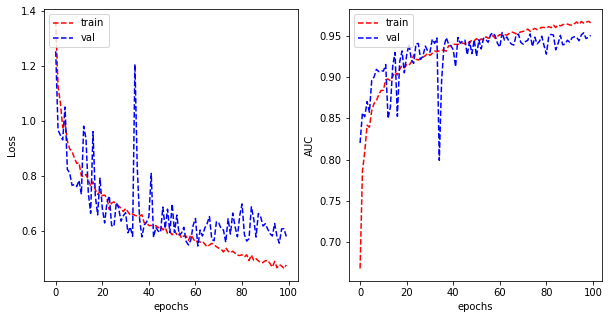

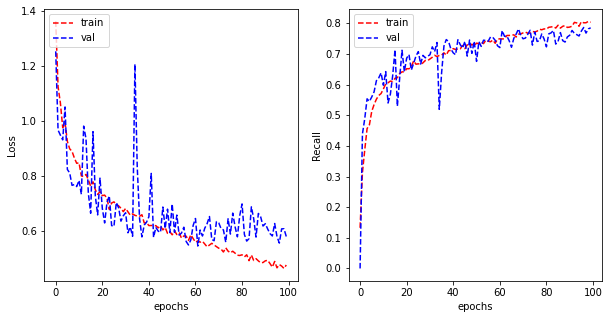

Validation F1-Score: 0.810529051877576

Test Scores: 
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       372
           1       0.72      0.86      0.78       504
           2       0.91      0.89      0.90       803
           3       0.78      0.45      0.57       301

    accuracy                           0.80      1980
   macro avg       0.78      0.75      0.75      1980
weighted avg       0.80      0.80      0.79      1980

[[292  35  31  14]
 [ 36 431  18  19]
 [ 33  48 717   5]
 [ 55  86  24 136]]
____________________________________________________________________________________________________
SGD


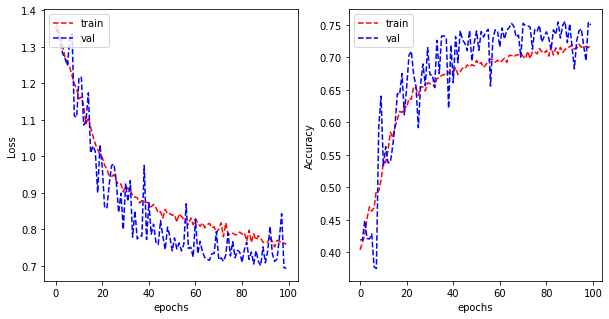

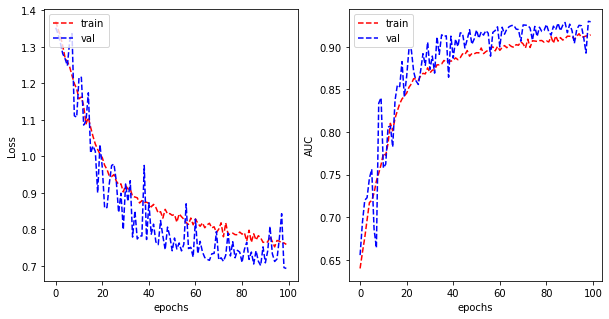

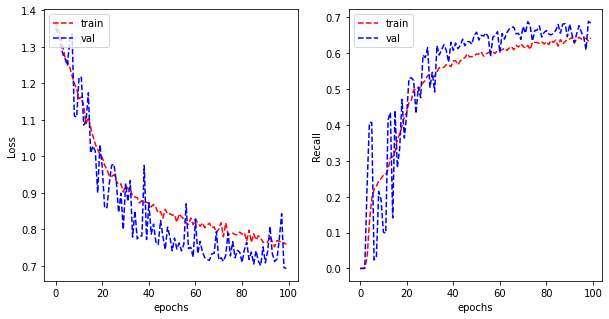

Validation F1-Score: 0.7484225035290768

Test Scores: 
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       372
           1       0.65      0.84      0.73       504
           2       0.81      0.92      0.86       803
           3       0.74      0.11      0.20       301

    accuracy                           0.72      1980
   macro avg       0.71      0.63      0.61      1980
weighted avg       0.73      0.72      0.69      1980

[[236  51  78   7]
 [ 31 423  46   4]
 [  8  54 740   1]
 [ 98 122  47  34]]
____________________________________________________________________________________________________


In [28]:
optimizer_epochs = { 'Adam':100, 'Adamax':100, 'Nadam': 100, 'RMSprop': 100, 'SGD': 100}
optimizers = ['Adam', 'Adamax', 'Nadam', 'RMSprop', 'SGD']
for optimizer_ in optimizers:
    print(optimizer_)
    
    base_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=INPUT_DIM),

        tf.keras.layers.Conv2D(filters=36, kernel_size=(4,4), activation="relu", padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation="relu", padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation='softmax'),
    ])

    
    base_model.compile(optimizer=optimizer_,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

    base_model_history = base_model.fit_generator(train_generator, validation_data = validation_generator, epochs=optimizer_epochs[optimizer_], verbose=0)

    history = base_model_history

    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                        metric_name='Accuracy', )


    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['auc'], history.history['val_auc'],
                        metric_name='AUC')

    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['recall'], history.history['val_recall'],
                        metric_name='Recall')


    print("Validation F1-Score: " + str(get_max_f1_score(base_model_history)))

    print()

    print("Test Scores: ")

    scores = base_model.evaluate_generator(test_generator)
    y_pred = base_model.predict(test_generator)

    # Code taken from Ruwan's troubleshooting post
    # setup data some placeholders
    batch_size_ = 1
    y_hat_all = list()
    y_all = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            y_hat = base_model.predict(x, verbose=0)
            y_hat = np.argmax(y_hat, axis = 1)
            y = np.argmax(y, axis = 1)
            y_hat_all = y_hat_all + y_hat.tolist()
            y_all = y_all + y.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break

    print(classification_report(y_all,y_hat_all))
    print(confusion_matrix(y_all, y_hat_all))
    
    print("____________________________________________________________________________________________________")

**Observations:**
 - Adam 
     - F1-score on the validation set is significantly higher, and the model seems to be just the right fit
     - F1-score for all cell types is higher, most notably for "Others"
     - Highest macro-average F1-score, meaning it's the best at classifying all cell types, not just epithelial
 - Adamax
     - Seems to b the best fit model, with a much higher F1-score on the validation set
     - Higher F1-score for all cell types than the previous iteration
 - Nadam
     - Model is slightly overfitting
     - Performance is much better overall, on par with Adam, only slightly differs in terms of classifying epithelial cells better and "Others" worse
 - RMSprop
     - F1-Score is igher for each cell type, and the model is on par with Adam and Nadam in terms of the F1-score, however it's slightly worse when classifying "Others"
 - SGD
     - Performance is worse

Trying a different activation function - tanh

Adam


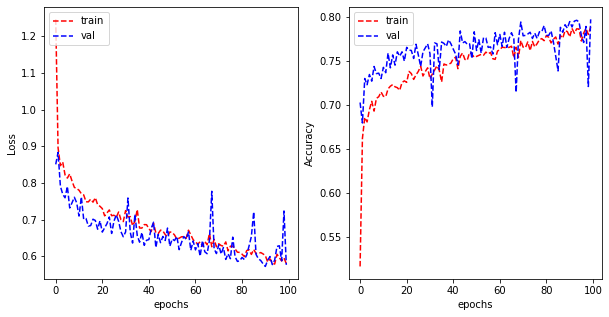

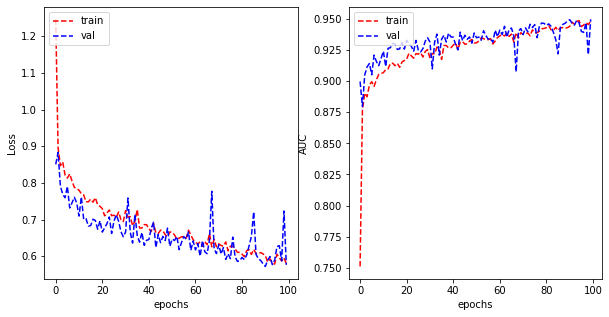

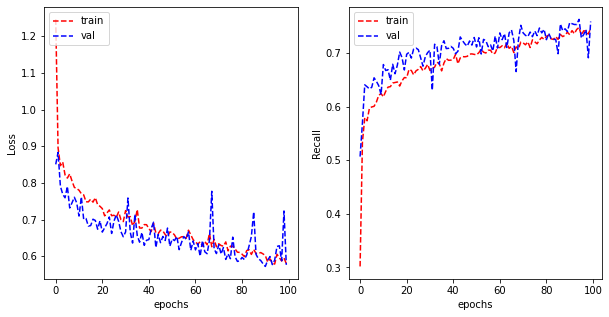

Validation F1-Score: 0.7922423013114044

Test Scores: 
              precision    recall  f1-score   support

           0       0.79      0.63      0.70       372
           1       0.71      0.84      0.77       504
           2       0.84      0.93      0.89       803
           3       0.64      0.42      0.51       301

    accuracy                           0.77      1980
   macro avg       0.74      0.71      0.72      1980
weighted avg       0.77      0.77      0.76      1980

[[234  40  62  36]
 [ 16 422  37  29]
 [  9  37 750   7]
 [ 38  95  41 127]]
____________________________________________________________________________________________________
Adamax


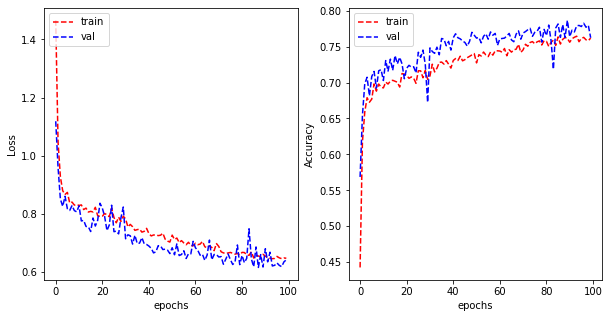

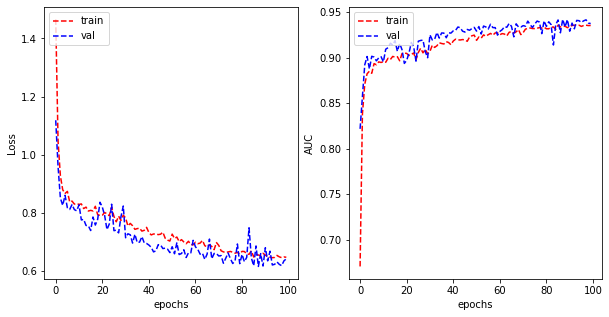

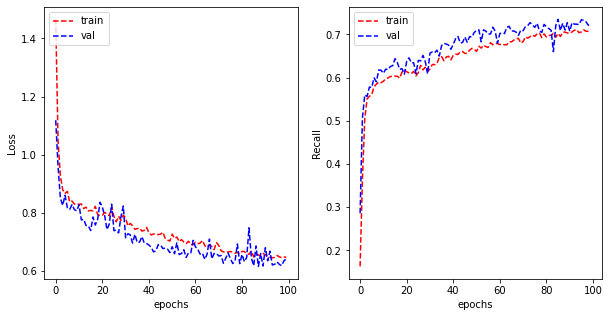

Validation F1-Score: 0.7769169137806957

Test Scores: 
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       372
           1       0.71      0.81      0.76       504
           2       0.83      0.93      0.88       803
           3       0.79      0.24      0.37       301

    accuracy                           0.75      1980
   macro avg       0.74      0.67      0.67      1980
weighted avg       0.76      0.75      0.73      1980

[[262  23  80   7]
 [ 49 410  37   8]
 [ 10  40 749   4]
 [ 91 102  35  73]]
____________________________________________________________________________________________________
Nadam


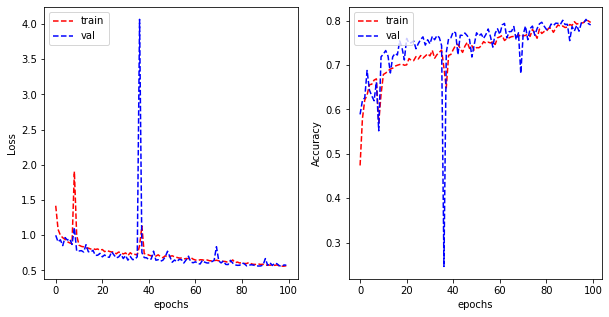

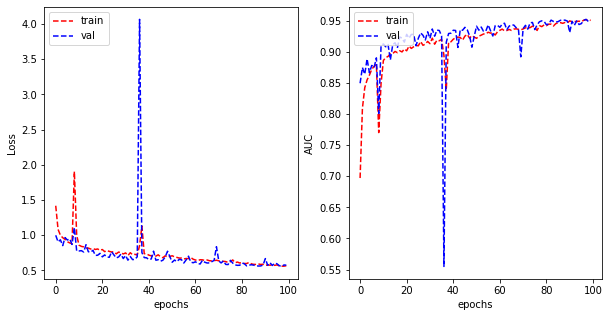

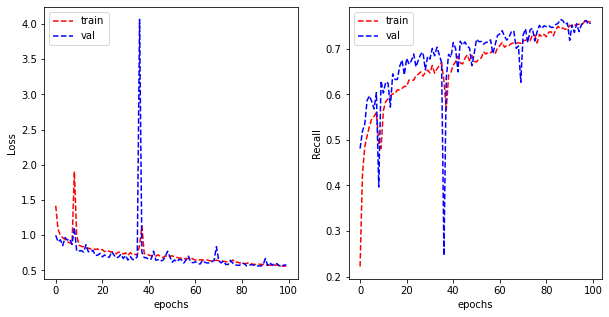

Validation F1-Score: 0.8004246410851541

Test Scores: 
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       372
           1       0.72      0.82      0.77       504
           2       0.83      0.94      0.88       803
           3       0.70      0.46      0.55       301

    accuracy                           0.78      1980
   macro avg       0.76      0.72      0.73      1980
weighted avg       0.78      0.78      0.77      1980

[[243  37  74  18]
 [ 20 411  42  31]
 [  3  35 755  10]
 [ 44  86  34 137]]
____________________________________________________________________________________________________
RMSprop


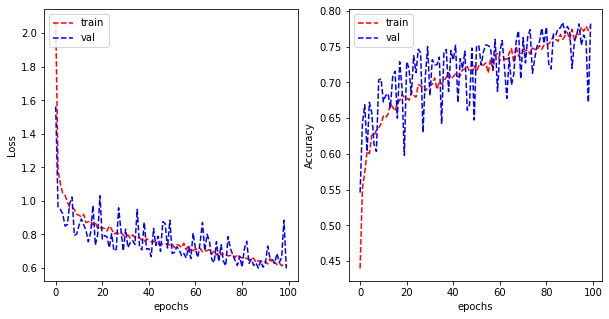

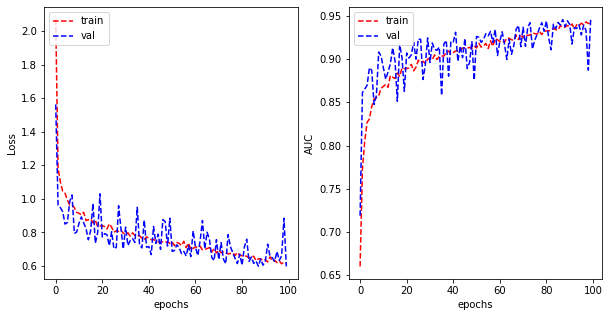

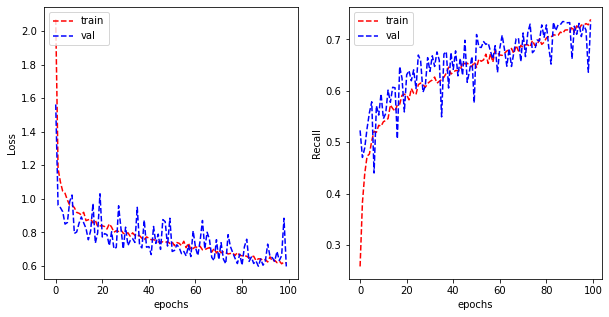

Validation F1-Score: 0.7800429291550667

Test Scores: 
              precision    recall  f1-score   support

           0       0.77      0.65      0.70       372
           1       0.72      0.82      0.77       504
           2       0.85      0.92      0.88       803
           3       0.66      0.49      0.56       301

    accuracy                           0.78      1980
   macro avg       0.75      0.72      0.73      1980
weighted avg       0.77      0.78      0.77      1980

[[241  28  72  31]
 [ 23 414  29  38]
 [ 10  51 735   7]
 [ 40  83  30 148]]
____________________________________________________________________________________________________
SGD


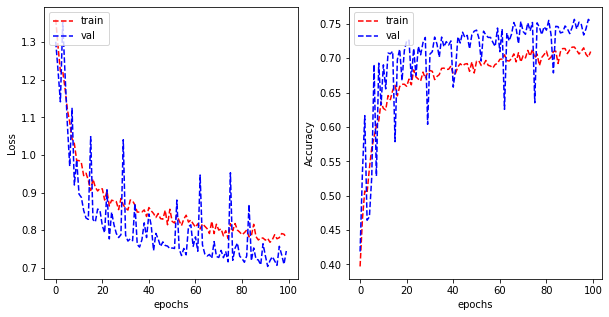

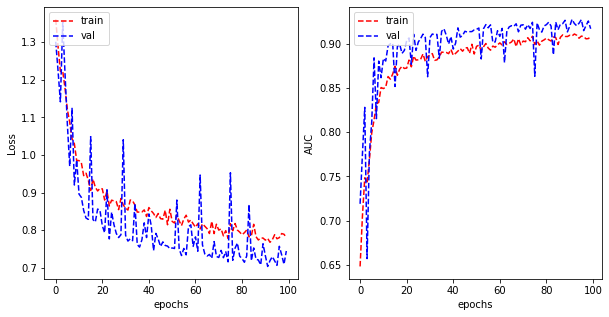

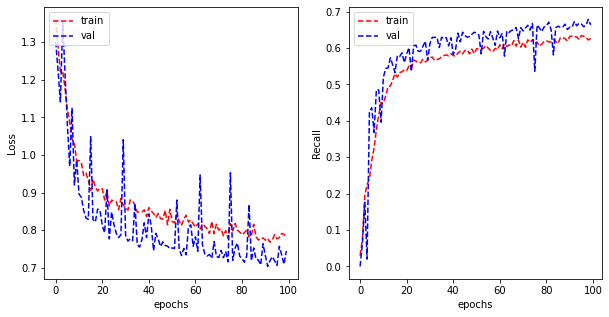

Validation F1-Score: 0.7393339050112776

Test Scores: 
              precision    recall  f1-score   support

           0       0.73      0.55      0.63       372
           1       0.58      0.93      0.72       504
           2       0.90      0.86      0.88       803
           3       0.59      0.25      0.35       301

    accuracy                           0.73      1980
   macro avg       0.70      0.65      0.64      1980
weighted avg       0.74      0.73      0.71      1980

[[205  81  45  41]
 [ 14 470  11   9]
 [ 19  95 687   2]
 [ 41 161  23  76]]
____________________________________________________________________________________________________


In [29]:
optimizer_epochs = { 'Adam':100, 'Adamax':100, 'Nadam': 100, 'RMSprop': 100, 'SGD': 100}
optimizers = ['Adam', 'Adamax', 'Nadam', 'RMSprop', 'SGD']
for optimizer_ in optimizers:
    print(optimizer_)
    
    base_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=INPUT_DIM),

        tf.keras.layers.Conv2D(filters=36, kernel_size=(4,4), activation="tanh", padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation="tanh", padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='tanh'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation='softmax'),
    ])

    
    base_model.compile(optimizer=optimizer_,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

    base_model_history = base_model.fit_generator(train_generator, validation_data = validation_generator, epochs=optimizer_epochs[optimizer_], verbose=0)

    history = base_model_history

    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                        metric_name='Accuracy', )


    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['auc'], history.history['val_auc'],
                        metric_name='AUC')

    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                        history.history['recall'], history.history['val_recall'],
                        metric_name='Recall')


    print("Validation F1-Score: " + str(get_max_f1_score(base_model_history)))

    print()

    print("Test Scores: ")

    scores = base_model.evaluate_generator(test_generator)
    y_pred = base_model.predict(test_generator)

    # Code taken from Ruwan's troubleshooting post
    # setup data some placeholders
    batch_size_ = 1
    y_hat_all = list()
    y_all = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            y_hat = base_model.predict(x, verbose=0)
            y_hat = np.argmax(y_hat, axis = 1)
            y = np.argmax(y, axis = 1)
            y_hat_all = y_hat_all + y_hat.tolist()
            y_all = y_all + y.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break

    print(classification_report(y_all,y_hat_all))
    print(confusion_matrix(y_all, y_hat_all))
    
    print("____________________________________________________________________________________________________")

**Observations:**
 - Performance is worse for all optimizers
 - ReLU seems to be the better choice, which might be down to it's property of being able to prevent the vanishing gradient problem

## Final Custom-Tuned Model
 - We will now re run our final custom model with the tuned parameters, and the 'Adam' optimizer

In [35]:
# Final tuned model
optimizer_epochs = {'Adam':100}
optimizer_ = 'Adam'

print(optimizer_)

base_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),

    tf.keras.layers.Conv2D(filters=36, kernel_size=(4,4), activation="relu", padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation="relu", padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax'),
])


base_model.compile(optimizer=optimizer_,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

base_model_history = base_model.fit_generator(train_generator, validation_data = validation_generator, epochs=optimizer_epochs[optimizer_], verbose=0)

history = base_model_history

Adam


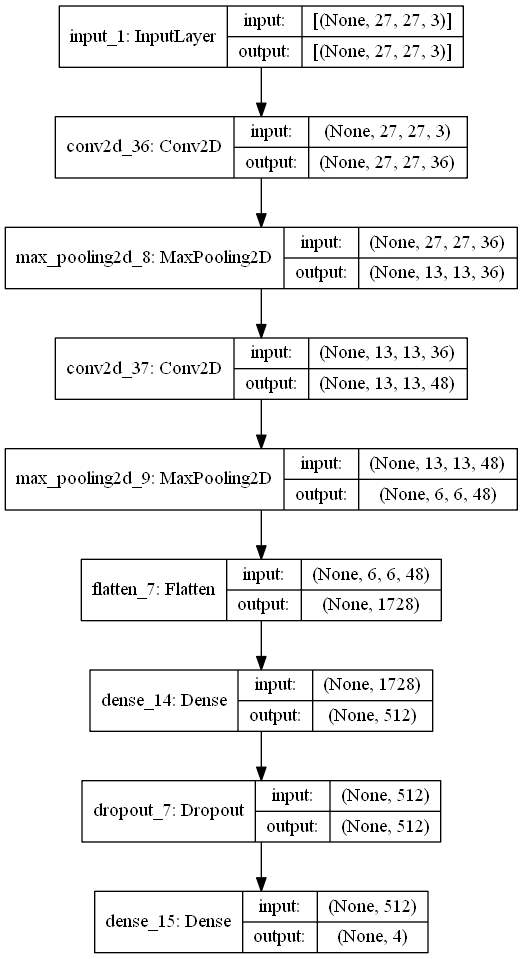

In [36]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

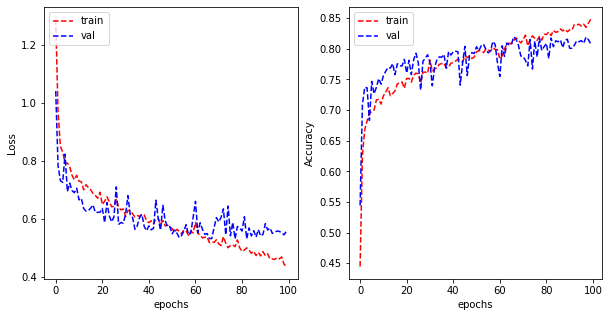

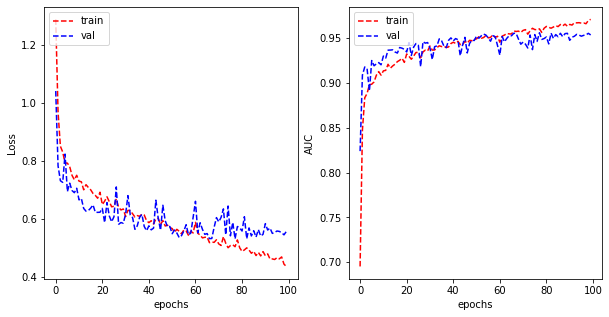

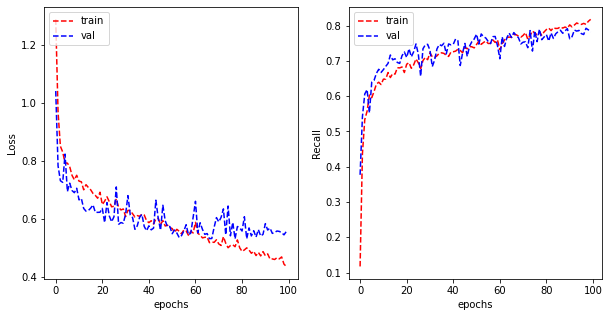

Validation F1-Score: 0.8172549005986867

Test Scores: 
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       372
           1       0.73      0.83      0.78       504
           2       0.91      0.88      0.90       803
           3       0.73      0.50      0.59       301

    accuracy                           0.80      1980
   macro avg       0.77      0.76      0.76      1980
weighted avg       0.80      0.80      0.79      1980

[[303  22  33  14]
 [ 41 419  17  27]
 [ 28  51 710  14]
 [ 50  83  19 149]]


In [37]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy', )


plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['auc'], history.history['val_auc'],
                    metric_name='AUC')

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['recall'], history.history['val_recall'],
                    metric_name='Recall')


print("Validation F1-Score: " + str(get_max_f1_score(base_model_history)))

print()

print("Test Scores: ")

scores = base_model.evaluate_generator(test_generator)
y_pred = base_model.predict(test_generator)

# Code taken from Ruwan's troubleshooting post
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = base_model.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

print(classification_report(y_all,y_hat_all))
print(confusion_matrix(y_all, y_hat_all))


**Observations:**
 - Adam is the best optimizer for this problem
 - Improved the overall F1-Score for all cell types
 - Improved weighted-average F1-Score from 0.68 to 0.8
 - Improved the macro-average F1-Score from 0.63 to 0.76

# AlexNet 

We used a model configuration from this research paper - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4977982/, which does a similar task to what we are trying to do here.

In [31]:
data = pd.read_csv('./data_labels_mainData.csv')

In [32]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)

In [33]:
INPUT_DIM = (27,27,3)

In [34]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')
test_data['cellType'] = test_data['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range = 90)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 128

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

batch_size = 1
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
# Using the Adagrad optimizer as per the paper
alexnet_model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(filters=3, kernel_size=(27,27), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape = (27,27,3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding="same",strides = 1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = 2),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu",padding="same",strides = 1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides = 2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation= 'relu',padding="same", strides = 1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.AveragePooling2D(pool_size = (3,3), strides = 2),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax'),
])

opt = tf.keras.optimizers.Adagrad(learning_rate=0.001)
alexnet_model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

alexnet_model_history = alexnet_model.fit_generator(train_generator, validation_data = validation_generator, epochs=750, verbose=0)

history = alexnet_model_history

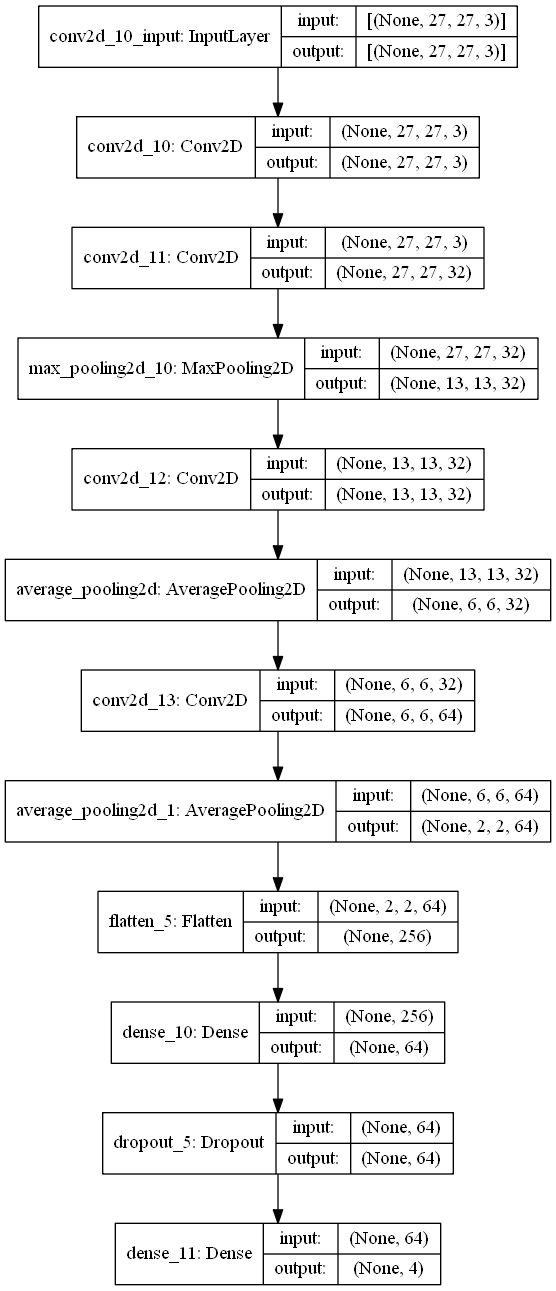

In [46]:
tf.keras.utils.plot_model(alexnet_model, show_shapes=True)

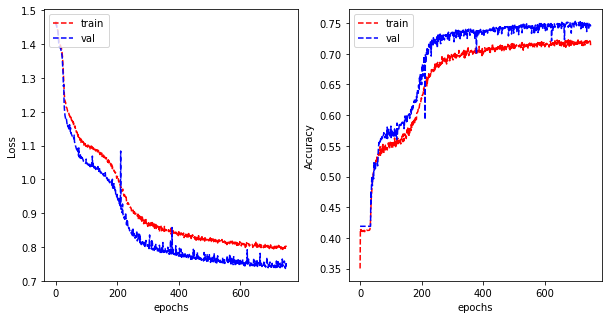

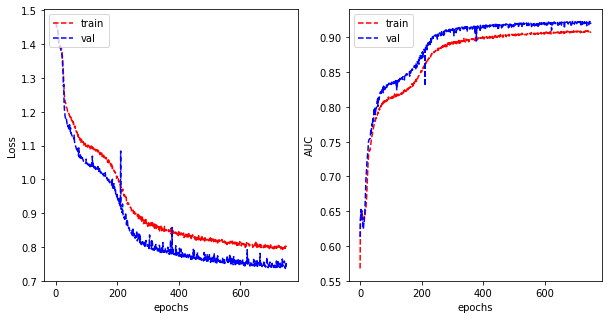

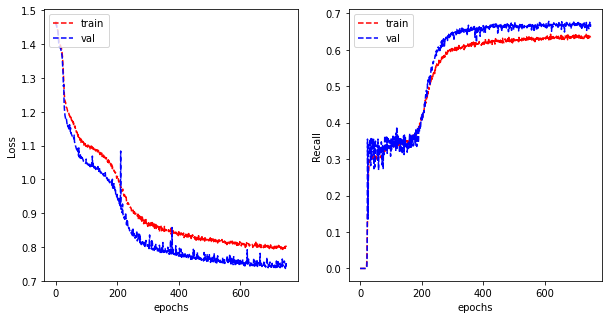

Validation F1-Score: 0.7353989288625614

Test Scores: 
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       372
           1       0.58      0.90      0.70       504
           2       0.88      0.87      0.88       803
           3       0.67      0.22      0.33       301

    accuracy                           0.72      1980
   macro avg       0.70      0.64      0.63      1980
weighted avg       0.74      0.72      0.70      1980

[[213  85  49  25]
 [ 24 452  21   7]
 [ 19  85 699   0]
 [ 54 158  24  65]]
____________________________________________________________________________________________________


In [23]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy', )


plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['auc'], history.history['val_auc'],
                    metric_name='AUC')

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['recall'], history.history['val_recall'],
                    metric_name='Recall')


print("Validation F1-Score: " + str(get_max_f1_score(alexnet_model_history)))

print()

print("Test Scores: ")


scores = alexnet_model.evaluate_generator(test_generator)
y_pred = alexnet_model.predict(test_generator)

# Code taken from Ruwan's troubleshooting post
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = alexnet_model.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

print(classification_report(y_all,y_hat_all))
print(confusion_matrix(y_all, y_hat_all))
print("____________________________________________________________________________________________________")

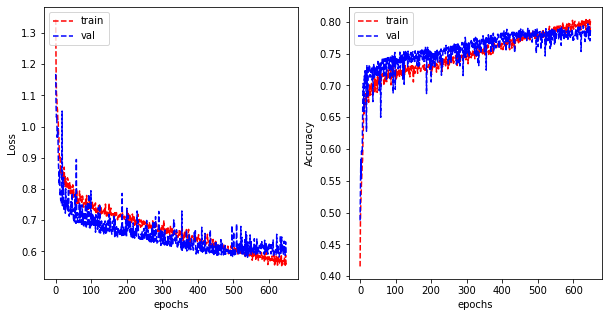

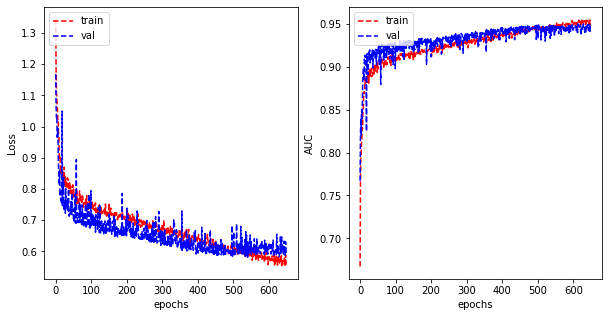

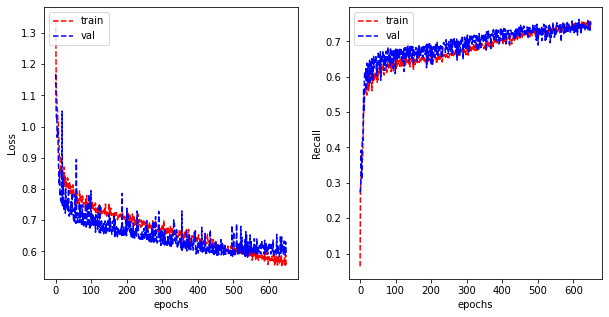

Validation F1-Score: 0.789902722732636

Test Scores: 
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       372
           1       0.73      0.82      0.77       504
           2       0.86      0.93      0.89       803
           3       0.68      0.41      0.51       301

    accuracy                           0.78      1980
   macro avg       0.75      0.72      0.72      1980
weighted avg       0.77      0.78      0.77      1980

[[268  32  56  16]
 [ 26 412  31  35]
 [ 15  38 743   7]
 [ 62  79  38 122]]
____________________________________________________________________________________________________


In [30]:
# Using Adamax as an optimizer
    
alexnet_model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(filters=3, kernel_size=(27,27), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape = (27,27,3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding="same",strides = 1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = 2),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu",padding="same",strides = 1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides = 2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation= 'relu',padding="same", strides = 1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.AveragePooling2D(pool_size = (3,3), strides = 2),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax'),
])

opt = tf.keras.optimizers.Adamax(learning_rate=0.001)
alexnet_model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

alexnet_model_history = alexnet_model.fit_generator(train_generator, validation_data = validation_generator, epochs=650, verbose=0)

history = alexnet_model_history

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy', )


plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['auc'], history.history['val_auc'],
                    metric_name='AUC')

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['recall'], history.history['val_recall'],
                    metric_name='Recall')


print("Validation F1-Score: " + str(get_max_f1_score(alexnet_model_history)))

print()

print("Test Scores: ")

#f1_score = 2*((scores[4]*scores[3])/(scores[4]+scores[3]))
#score = alexnet_model.evaluate_generator(test_generator)
#print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

scores = alexnet_model.evaluate_generator(test_generator)
y_pred = alexnet_model.predict(test_generator)

# Code taken from Ruwan's troubleshooting post
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = alexnet_model.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

print(classification_report(y_all,y_hat_all))
print(confusion_matrix(y_all, y_hat_all))
print("____________________________________________________________________________________________________")

**Observations:**
 - The F1-score performance is worse than the final custom-tuned model for all cell types and on both types of average, even after training for 650 epochs

# FCRN+CNN

We used the FCRN+CNN model configuration from this research paper - https://ieeexplore-ieee-org.ezproxy.lib.rmit.edu.au/document/8707397, which does the same task as what we are doing here. 

In [ ]:
FCRN_CNN_model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(filters=3, kernel_size=(27,27), activation="relu", padding="same", input_shape = (27,27,3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding="same",strides = 1),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu",padding="same",strides = 1),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(1,7), activation="relu",padding="same",strides = 1),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(1,7), activation="relu",padding="same",strides = 1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = 1, padding = "same"),
    
    tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation="relu",padding="same",strides = 1),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same",strides = 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = 2, padding = "same"),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same",strides = 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = 2, padding = "same"),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same",strides = 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax'),
])


FCRN_CNN_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])

FCRN_CNN_model_history = FCRN_CNN_model.fit_generator(train_generator, validation_data = validation_generator, epochs=1000, verbose=0)

history = FCRN_CNN_model_history

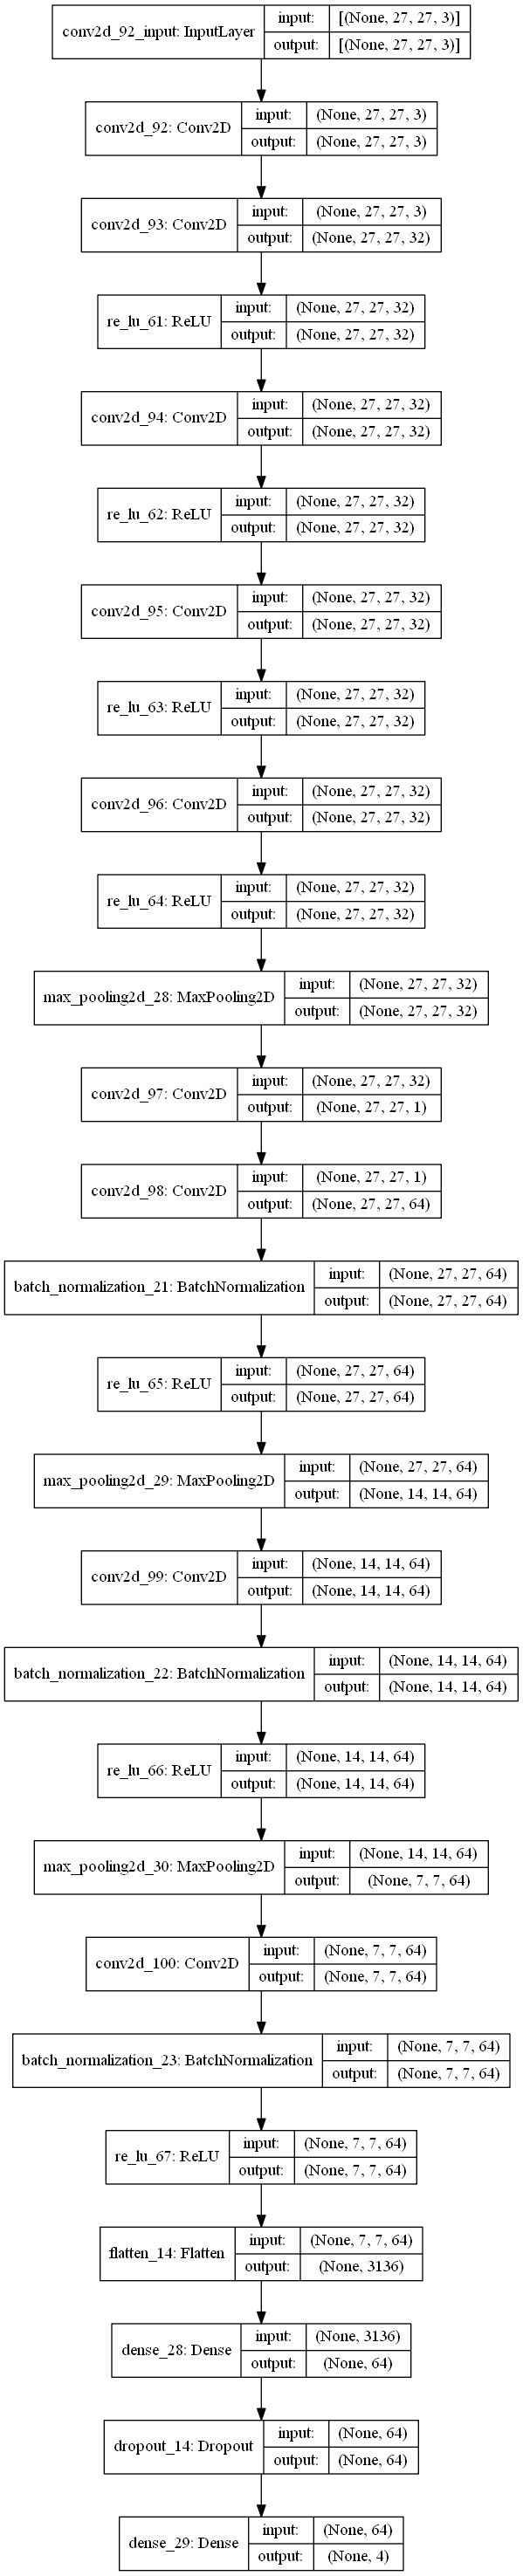

In [130]:
tf.keras.utils.plot_model(FCRN_CNN_model, show_shapes=True)

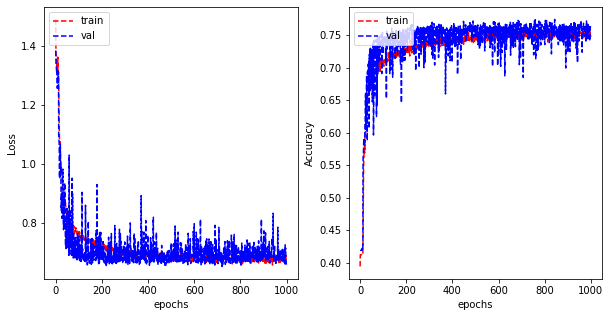

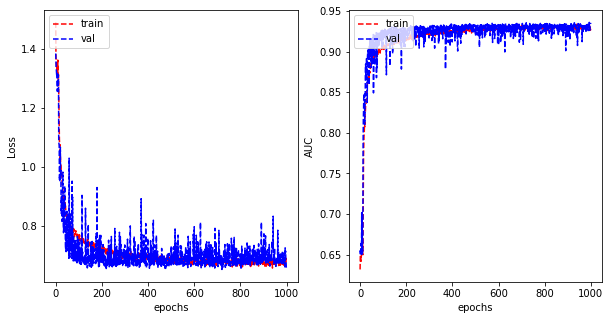

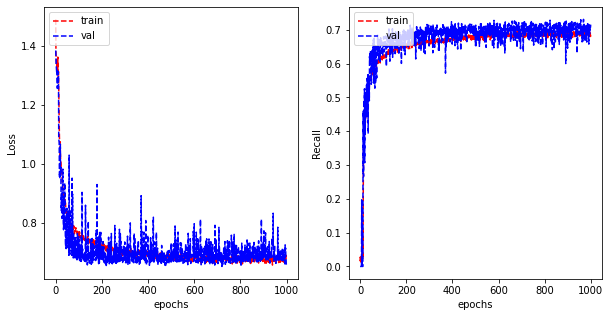

Validation F1-Score: 0.768404086111775

Test Scores: 
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       372
           1       0.66      0.86      0.74       504
           2       0.84      0.92      0.88       803
           3       0.73      0.23      0.35       301

    accuracy                           0.75      1980
   macro avg       0.73      0.66      0.66      1980
weighted avg       0.75      0.75      0.72      1980

[[240  42  77  13]
 [ 30 433  31  10]
 [  8  57 736   2]
 [ 75 128  30  68]]
____________________________________________________________________________________________________


In [20]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy', )


plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['auc'], history.history['val_auc'],
                    metric_name='AUC')

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['recall'], history.history['val_recall'],
                    metric_name='Recall')


print("Validation F1-Score: " + str(get_max_f1_score(FCRN_model_history)))

print()

print("Test Scores: ")

#f1_score = 2*((scores[4]*scores[3])/(scores[4]+scores[3]))
#score = FCRN_model.evaluate_generator(test_generator)
#print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

scores = FCRN_CNN_model.evaluate_generator(test_generator)
y_pred = FCRN_CNN_model.predict(test_generator)

# Code taken from Ruwan's troubleshooting post
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = FCRN_CNN_model.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

print(classification_report(y_all,y_hat_all))
print(confusion_matrix(y_all, y_hat_all))
print("____________________________________________________________________________________________________")

**Observations:**
 - The F1-score performance is worse than the final custom-tuned model for all cell types and on both types of average, even after training for 1000 epochs
 - It is worth noting that we were not able to replicate the performance that is mentioned in the paper. This might be due to simplification assumed in the padding and strides in the layers, which is due to a difference in the version of tensorflow that is being used here.

## Final Model Comparison

First we get the classification report metrics for each model

### Custom-Tuned Model

In [51]:
scores = base_model.evaluate_generator(test_generator)
y_pred = base_model.predict(test_generator)

# Code taken from Ruwan's troubleshooting post
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = base_model.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

print(classification_report(y_all,y_hat_all))
base_model_report = classification_report(y_all, y_hat_all, output_dict=True )

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       372
           1       0.73      0.83      0.78       504
           2       0.91      0.88      0.90       803
           3       0.73      0.50      0.59       301

    accuracy                           0.80      1980
   macro avg       0.77      0.76      0.76      1980
weighted avg       0.80      0.80      0.79      1980



### AlexNet Model

In [53]:
scores = alexnet_model.evaluate_generator(test_generator)
y_pred = alexnet_model.predict(test_generator)

# Code taken from Ruwan's troubleshooting post
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = alexnet_model.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

print(classification_report(y_all,y_hat_all))
alexnet_model_report = classification_report(y_all, y_hat_all, output_dict=True )

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       372
           1       0.73      0.82      0.77       504
           2       0.86      0.93      0.89       803
           3       0.68      0.41      0.51       301

    accuracy                           0.78      1980
   macro avg       0.75      0.72      0.72      1980
weighted avg       0.77      0.78      0.77      1980



### FCRN+CNN Model

In [55]:
scores = FCRN_CNN_model.evaluate_generator(test_generator)
y_pred = FCRN_CNN_model.predict(test_generator)

# Code taken from Ruwan's troubleshooting post
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = FCRN_CNN_model.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

print(classification_report(y_all,y_hat_all))
FCRN_model_report = classification_report(y_all, y_hat_all, output_dict=True )

              precision    recall  f1-score   support

           0       0.68      0.65      0.66       372
           1       0.66      0.86      0.74       504
           2       0.84      0.92      0.88       803
           3       0.73      0.23      0.35       301

    accuracy                           0.75      1980
   macro avg       0.73      0.66      0.66      1980
weighted avg       0.75      0.75      0.72      1980



### Comparative Evaluation

We now compare each model by their different performance metrics for classifying each cell type. The main performance metric we are judging these models on is the F1-Score.

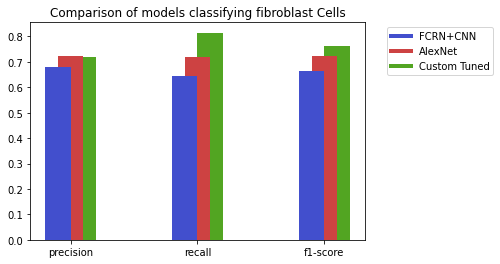

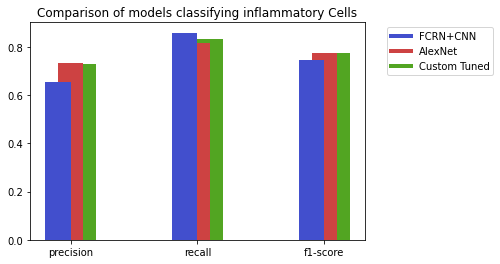

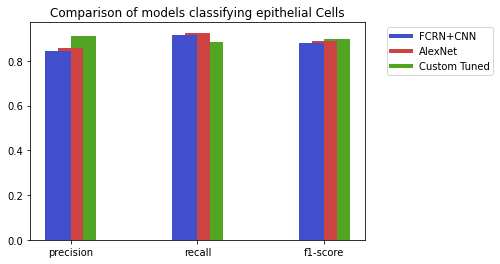

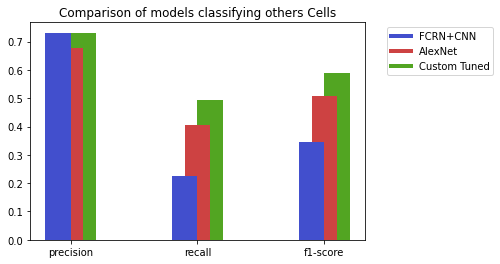

In [131]:
cellType_dict = {'fibroblast':0, 'inflammatory': 1, 'epithelial': 2, 'others': 3}

for cellType in cellType_dict.keys():
    metrics = ['precision', 'recall', 'f1-score']

    base_metric_values = []
    for metric in metrics:
        base_metric_values.append(base_model_report[str(cellType_dict[cellType])][metric])

    alexnet_metric_values = []
    for metric in metrics:
        alexnet_metric_values.append(alexnet_model_report[str(cellType_dict[cellType])][metric])

    FCRN_metric_values = []
    for metric in metrics:
        FCRN_metric_values.append(FCRN_model_report[str(cellType_dict[cellType])][metric])

    plt.bar(metrics, base_metric_values, align = 'edge', width = 0.2, color = (0.321, 0.647, 0.133))
    plt.bar(metrics, alexnet_metric_values, align = 'center', width = 0.2, color = (0.803, 0.258, 0.258))
    plt.bar(metrics, FCRN_metric_values, align = 'edge', width = -0.2, color =(0.258, 0.309, 0.803))



    cmap = plt.cm.coolwarm
    custom_lines = [Line2D([0], [0], color=(0.258, 0.309, 0.803), lw=4),
                    Line2D([0], [0], color=(0.803, 0.258, 0.258), lw=4),
                    Line2D([0], [0], color=(0.321, 0.647, 0.133), lw=4)]

    plt.legend(custom_lines, ['FCRN+CNN', 'AlexNet', 'Custom Tuned'], bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title("Comparison of models classifying "+ cellType + " Cells")

    plt.show()

**Observations:**
 - There is very little difference between the 3 models for the F1-Score of epithelial cell classification
 - As mentioned previously, the Custom Tuned model outperforms the other models when looking at the F1-score for all different cell types.

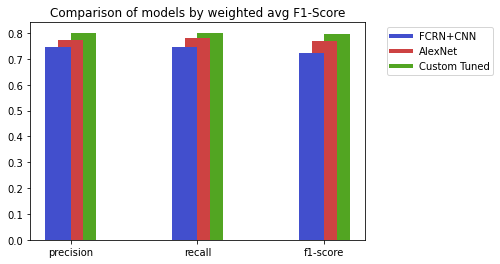

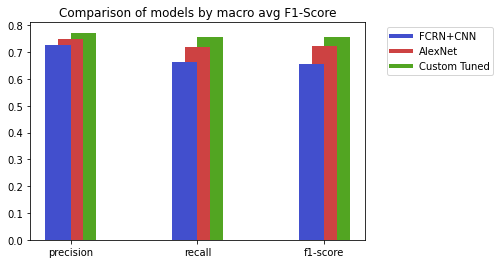

In [132]:
f1_types = ['weighted avg', 'macro avg']

for f1_type in f1_types:
    metrics = ['precision', 'recall', 'f1-score']

    base_metric_values = []
    for metric in metrics:
        base_metric_values.append(base_model_report[f1_type][metric])

    alexnet_metric_values = []
    for metric in metrics:
        alexnet_metric_values.append(alexnet_model_report[f1_type][metric])

    FCRN_metric_values = []
    for metric in metrics:
        FCRN_metric_values.append(FCRN_model_report[f1_type][metric])

    plt.bar(metrics, base_metric_values, align = 'edge', width = 0.2, color = (0.321, 0.647, 0.133))
    plt.bar(metrics, alexnet_metric_values, align = 'center', width = 0.2, color = (0.803, 0.258, 0.258))
    plt.bar(metrics, FCRN_metric_values, align = 'edge', width = -0.2, color =(0.258, 0.309, 0.803))



    cmap = plt.cm.coolwarm
    custom_lines = [Line2D([0], [0], color=(0.258, 0.309, 0.803), lw=4),
                    Line2D([0], [0], color=(0.803, 0.258, 0.258), lw=4),
                    Line2D([0], [0], color=(0.321, 0.647, 0.133), lw=4)]

    plt.legend(custom_lines, ['FCRN+CNN', 'AlexNet', 'Custom Tuned'], bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title("Comparison of models by "+ f1_type + " F1-Score")

    plt.show()

**Observations:**
 - Our main performance metric, the Macro-Average F1-Score has the Custom Tuned model as the best model here.
 - The Custom-Tuned model also outperforms the other two when looking at the weighted-average, so it is an all-round better solution

# Ultimate Judgement

As noted by Janoqczyk and Madabhusi “regions of cancer are typically manifested in the epithelium” (Pg. 38, 2016). This is reflected strongly in the main dataset provided, insofar as all of the patch samples which have been manually identified as cancerous are also of epithelial type. Therefore, as a part of our ultimate judgement, we used the spatially-constrained model in conjunction with the custom-tuned model to make a decision on the classification of cell type. This was done by using both models to make a prediction on data, and where they both disagree as to whether a cell is cancerous (epithelial), we use the model that classifies an image as cancerous. This is because we would rather have more false positives, and people getting tested thoroughly and diagnosed than false negatives. 

In order to do this, we need both models to make a prediction on the data

In [4]:
def make_ultimate_judgement(sc_softmax, base_model, test_generator):

    sc_softmax_pred = sc_softmax.predict(test_generator)
    base_model_pred = base_model.predict(test_generator)

    
    sc_softmax_final_pred = []
    base_model_final_pred = []

    for i in range(len(sc_softmax_pred)):
        sc_softmax_max_value = max(list(sc_softmax_pred[i]))
        sc_softmax_max_index = list(sc_softmax_pred[i]).index(sc_softmax_max_value)

        base_model_max_value = max(list(base_model_pred[i]))
        base_model_max_index = list(base_model_pred[i]).index(base_model_max_value)

        # Now that we have the predictions from the classifiers, we can enforce our rule from above

        # '1' here means cancerous for the sc_softmax model, and '2' means epithelial for the base_model
        if sc_softmax_max_index == 1 and base_model_max_index != 2:
            base_model_max_index = 2

        if base_model_max_index == 2 and sc_softmax_max_index != 1:
            sc_softmax_max_index = 1

        base_model_final_pred.append(base_model_max_index)
        sc_softmax_final_pred.append(sc_softmax_max_index)
        
    return sc_softmax_final_pred, base_model_final_pred

This function takes in both the models and the data and uses them both to make a judgement as outlined above

# References

 - Géron, A., 2019. Hands-on machine learning with Scikit-Learn and TensorFlow. 2nd ed. Sebastopol: O'Reilly, p.463.

 - Sirinukunwattana, K., Raza, S., Tsang, Y., Snead, D., Cree, I. and Rajpoot, N., 2016. Locality Sensitive Deep Learning for Detection and Classification of Nuclei in Routine Colon Cancer Histology Images. IEEE Transactions on Medical Imaging, 35(5), pp.1196-1206.

 - Araújo, T., Aresta, G., Castro, E., Rouco, J., Aguiar, P., Eloy, C., Polónia, A. and Campilho, A., 2017. Classification of breast cancer histology images using Convolutional Neural Networks. PLOS ONE, 12(6), p.e0177544.

 - Janowczyk, A. and Madabhushi, A., 2016. Deep learning for digital pathology image analysis: A comprehensive tutorial with selected use cases. Journal of Pathology Informatics, 7(1), pp.29-47.

 - A. Hamad, I. Ersoy and F. Bunyak, "Improving Nuclei Classification Performance in H&E Stained Tissue Images Using Fully Convolutional Regression Network and Convolutional Neural Network," 2018 IEEE Applied Imagery Pattern Recognition Workshop (AIPR), 2018, pp. 1-6, doi: 10.1109/AIPR.2018.8707397.
